
## QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

---

## Requirements

1. Scrape and prepare your own data.

2. **Create and compare at least two models for each section**. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing (e.g. Ridge, logistic regression, KNN, SVM, etc).
   - Section 1: Job Salary Trends
   - Section 2: Job Category Factors

3. Prepare a polished Jupyter Notebook with your analysis for a peer audience of data scientists. 
   - Make sure to clearly describe and label each section.
   - Comment on your code so that others could, in theory, replicate your work.

4. A brief writeup in an executive summary, written for a non-technical audience.
   - Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

#### BONUS

5. Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions.

6. Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

---

In [1]:
# Data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# Plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

# Make sure charts appear in the notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Stats/regressions packages
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, roc_curve, auc, classification_report
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# NLP packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import naive_bayes

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Enable viewing of all columns for DataFrames
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('webdata.csv')

In [3]:
print(df.shape)
df.head()

(2775, 11)


Unnamed: 0                                       Title  \
0           0                 Business Analyst    (AGILE)   
1           1                 Business Analyst    (AGILE)   
2           2                 Business Analyst    (AGILE)   
3           3                            Business Analyst   
4           4  IT Business Analyst - Regulatory Reporting   

                                           Company  \
0             KELLY SERVICES (SINGAPORE) PTE. LTD.   
1             KELLY SERVICES (SINGAPORE) PTE. LTD.   
2             KELLY SERVICES (SINGAPORE) PTE. LTD.   
3  ACRONIS ASIA RESEARCH AND DEVELOPMENT PTE. LTD.   
4            OPTIMUM SOLUTIONS (SINGAPORE) PTE LTD   

                                            Location Salary from Salary to  \
0          ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960      $4,000    $6,000   
1          ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960      $6,000    $9,000   
2          ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960      $9,000   $13,500   
3     SUNTEC TOWER THREE, 8 TEMASEK BOULEVARD 038988      $5,000    $7,000   
4  PLAZA 8 @ CBP, 1 CHANGI BUSINESS PARK CRESCENT...      $5,500    $8,000   

  Salary Type Employment Type          Seniority  \
0     Monthly        Contract       Professional   
1     Monthly        Contract       Professional   
2     Monthly        Contract       Professional   
3     Monthly       Full Time          Executive   
4     Monthly       Full Time  Fresh/entry level   

                                             Summary  \
0   Delivery experience in Agile is a must as new...   
1   Delivery experience in Agile is a must as new...   
2   Delivery experience in Agile is a must as new...   
3  As a Business Analyst, you will be responsible...   
4  Optimum Solutions (Company Registration Number...   

                                        Requirements  
0  Requirements Requirements:     Acted as a Scru...  
1  Requirements Requirements:     Acted as a Scru...  
2  Requirements Requirements:   Acted as a Scrum ...  
3  Requirements 3+ years of experience in a busin...  
4  RequirementsJob Description:   Functional expe...

In [4]:
df.isnull().sum()

Unnamed: 0           0
Title               67
Company             67
Location            67
Salary from        305
Salary to          305
Salary Type        304
Employment Type     67
Seniority          152
Summary             67
Requirements       258
dtype: int64

In [5]:
# Dropping the Unnamed: 0 column, rows with null values and duplicates
df.drop(columns='Unnamed: 0', inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(keep='first', inplace=True)

In [6]:
print(df.shape)
df.info()

(1407, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1407 entries, 0 to 2773
Data columns (total 10 columns):
Title              1407 non-null object
Company            1407 non-null object
Location           1407 non-null object
Salary from        1407 non-null object
Salary to          1407 non-null object
Salary Type        1407 non-null object
Employment Type    1407 non-null object
Seniority          1407 non-null object
Summary            1407 non-null object
Requirements       1407 non-null object
dtypes: object(10)
memory usage: 120.9+ KB


In [7]:
df.head()

Title  \
0                 Business Analyst    (AGILE)   
1                 Business Analyst    (AGILE)   
2                 Business Analyst    (AGILE)   
3                            Business Analyst   
4  IT Business Analyst - Regulatory Reporting   

                                           Company  \
0             KELLY SERVICES (SINGAPORE) PTE. LTD.   
1             KELLY SERVICES (SINGAPORE) PTE. LTD.   
2             KELLY SERVICES (SINGAPORE) PTE. LTD.   
3  ACRONIS ASIA RESEARCH AND DEVELOPMENT PTE. LTD.   
4            OPTIMUM SOLUTIONS (SINGAPORE) PTE LTD   

                                            Location Salary from Salary to  \
0          ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960      $4,000    $6,000   
1          ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960      $6,000    $9,000   
2          ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960      $9,000   $13,500   
3     SUNTEC TOWER THREE, 8 TEMASEK BOULEVARD 038988      $5,000    $7,000   
4  PLAZA 8 @ CBP, 1 CHANGI BUSINESS PARK CRESCENT...      $5,500    $8,000   

  Salary Type Employment Type          Seniority  \
0     Monthly        Contract       Professional   
1     Monthly        Contract       Professional   
2     Monthly        Contract       Professional   
3     Monthly       Full Time          Executive   
4     Monthly       Full Time  Fresh/entry level   

                                             Summary  \
0   Delivery experience in Agile is a must as new...   
1   Delivery experience in Agile is a must as new...   
2   Delivery experience in Agile is a must as new...   
3  As a Business Analyst, you will be responsible...   
4  Optimum Solutions (Company Registration Number...   

                                        Requirements  
0  Requirements Requirements:     Acted as a Scru...  
1  Requirements Requirements:     Acted as a Scru...  
2  Requirements Requirements:   Acted as a Scrum ...  
3  Requirements 3+ years of experience in a busin...  
4  RequirementsJob Description:   Functional expe...

<div class="alert alert-warning">
    
Strange postings with similar title, company, location, employment type, seniority, summary and requirements but with differing salary amounts.

</div>

In [8]:
df.iloc[:3,:]

Title                               Company  \
0  Business Analyst    (AGILE)  KELLY SERVICES (SINGAPORE) PTE. LTD.   
1  Business Analyst    (AGILE)  KELLY SERVICES (SINGAPORE) PTE. LTD.   
2  Business Analyst    (AGILE)  KELLY SERVICES (SINGAPORE) PTE. LTD.   

                                    Location Salary from Salary to  \
0  ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960      $4,000    $6,000   
1  ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960      $6,000    $9,000   
2  ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960      $9,000   $13,500   

  Salary Type Employment Type     Seniority  \
0     Monthly        Contract  Professional   
1     Monthly        Contract  Professional   
2     Monthly        Contract  Professional   

                                             Summary  \
0   Delivery experience in Agile is a must as new...   
1   Delivery experience in Agile is a must as new...   
2   Delivery experience in Agile is a must as new...   

                                        Requirements  
0  Requirements Requirements:     Acted as a Scru...  
1  Requirements Requirements:     Acted as a Scru...  
2  Requirements Requirements:   Acted as a Scrum ...

In [9]:
# Identifying the Job Titles where they seem to be same job but with differing Salaries
df['Combine'] = df['Title'] + df['Company'] + df['Location'] + df['Employment Type'] + df['Seniority'] + df['Summary'] + df['Requirements']

repeats = list(set(df.groupby('Combine').filter(lambda x: len(x)>1)['Combine']))

# Combining the similar jobs and keeping the min. salary for 'Salary from' and max. for 'Salary to' columns
index_drop = []
temp = pd.DataFrame(columns=df.columns)

# Creating temp DataFrame to house the combined job role as 1 observation
for repeat in repeats:
    index_drop.extend(list(df[df['Combine'] == repeat].index))
    temp = temp.append({
        'Title':df[df['Combine'] == repeat]['Title'].min(),
        'Company':df[df['Combine'] == repeat]['Company'].min(),
        'Location':df[df['Combine'] == repeat]['Location'].min(),
        'Salary from':df[df['Combine'] == repeat]['Salary from'].min(),
        'Salary to':df[df['Combine'] == repeat]['Salary to'].max(),
        'Salary Type':df[df['Combine'] == repeat]['Salary Type'].min(),
        'Employment Type':df[df['Combine'] == repeat]['Employment Type'].min(),
        'Seniority':df[df['Combine'] == repeat]['Seniority'].min(),
        'Summary':df[df['Combine'] == repeat]['Summary'].min(),
        'Requirements':df[df['Combine'] == repeat]['Requirements'].min(),
        'Combine':df[df['Combine'] == repeat]['Combine'].min(),
    }, ignore_index=True)
    
# Dropping the multiple job role observations & concatenating the combined job roles
df.drop(index_drop, inplace=True)
df = pd.concat([df, temp], axis=0)
df.drop(columns='Combine', inplace=True)

In [10]:
df.shape

(1384, 10)

In [11]:
# Converting Salary Type to numeric: 1 for monthly, 12 for annually
df['Salary Type'] = df['Salary Type'].apply(lambda x: 1 if x=='Monthly' else 12 if x=='Annually' else 0)

# Converting Salary to Monthly & float dtype and creating a new column for average monthly Salary
cols = ['Salary from', 'Salary to']

for col in cols:
    df[col] = df[col].str.replace('$','')
    df[col] = df[col].str.replace(',','').astype(float)
    df[col] = df[col] / df['Salary Type']

# Creating a new column for average monthly salary
df['Salary avg'] = df[['Salary from', 'Salary to']].mean(axis=1)

# Converting Title, Company, Summary and Requirements columns to lowercase
titlecol = ['Title', 'Company', 'Summary', 'Requirements']

# Extracting Postal Code & Sector Code from Location
df['Postal Code'] = df['Location'].apply(lambda x: x[-6:] if x[-6:].isdigit() else 0)
df['Sector Code'] = df['Postal Code'].apply(lambda x: str(x)[:2] if len(str(x)) == 6 else 0)

for col in titlecol:
    df[col] = df[col].apply(lambda x: x.lower())

In [12]:
# Creating dictionary for Postal District from Postal Codes
# https://en.wikipedia.org/wiki/Postal_codes_in_Singapore

district_dict = {
    '01':'01',
    '02':'01',
    '03':'01',
    '04':'01',
    '05':'01',
    '06':'01',
    '07':'02',
    '08':'02',
    '14':'03',
    '15':'03',
    '16':'03',
    '09':'04',
    '10':'04',
    '11':'05',
    '12':'05',
    '13':'05',
    '17':'06',
    '18':'07',
    '19':'07',
    '20':'08',
    '21':'08',
    '22':'09',
    '23':'09',
    '24':'10',
    '25':'10',
    '26':'10',
    '27':'10',
    '28':'11',
    '29':'11',
    '30':'11',
    '31':'12',
    '32':'12',
    '33':'12',
    '34':'13',
    '35':'13',
    '36':'13',
    '37':'13',
    '38':'14', 
    '39':'14',
    '40':'14',
    '41':'14',
    '42':'15',
    '43':'15',
    '44':'15',
    '45':'15',
    '46':'16',
    '47':'16',
    '48':'16',
    '49':'17',
    '50':'17',
    '81':'17',
    '51':'18',
    '52':'18',
    '53':'19',
    '54':'19',
    '55':'19',
    '82':'19',
    '56':'20',
    '57':'20',
    '58':'21',
    '59':'21',
    '60':'22',
    '61':'22',
    '62':'22',
    '63':'22',
    '64':'22',
    '65':'23',
    '66':'23',
    '67':'23',
    '68':'23',
    '69':'24',
    '70':'24',
    '71':'24',
    '72':'25',
    '73':'25',
    '77':'26',
    '78':'26',
    '75':'27',
    '76':'27',
    '79':'28',
    '80':'28'
}

df['District'] = df['Sector Code'].map(district_dict)
df.head()

Title  \
2                 business analyst    (agile)   
3                            business analyst   
4  it business analyst - regulatory reporting   
5                            business analyst   
6                            business analyst   

                                           Company  \
2             kelly services (singapore) pte. ltd.   
3  acronis asia research and development pte. ltd.   
4            optimum solutions (singapore) pte ltd   
5                      tangspac consulting pte ltd   
6                   peoplebank singapore pte. ltd.   

                                            Location  Salary from  Salary to  \
2          ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960       9000.0    13500.0   
3     SUNTEC TOWER THREE, 8 TEMASEK BOULEVARD 038988       5000.0     7000.0   
4  PLAZA 8 @ CBP, 1 CHANGI BUSINESS PARK CRESCENT...       5500.0     8000.0   
5               THE OCTAGON, 105 CECIL STREET 069534       8500.0    10000.0   
6           ROBINSON CENTRE, 61 ROBINSON ROAD 068893       5500.0     7200.0   

   Salary Type      Employment Type                       Seniority  \
2            1             Contract                    Professional   
3            1            Full Time                       Executive   
4            1            Full Time               Fresh/entry level   
5            1  Contract, Full Time  Professional, Senior Executive   
6            1             Contract                Senior Executive   

                                             Summary  \
2   delivery experience in agile is a must as new...   
3  as a business analyst, you will be responsible...   
4  optimum solutions (company registration number...   
5  job objectives •             analyses business...   
6   understanding the needs of multiple stakehold...   

                                        Requirements  Salary avg Postal Code  \
2  requirements requirements:   acted as a scrum ...     11250.0      018960   
3  requirements 3+ years of experience in a busin...      6000.0      038988   
4  requirementsjob description:   functional expe...      6750.0      486025   
5  requirementskey requirements •             aro...      9250.0      069534   
6  requirements minimally 5 years’ experience dev...      6350.0      068893   

  Sector Code District  
2          01       01  
3          03       01  
4          48       16  
5          06       01  
6          06       01

In [13]:
df[df['Salary avg'] > 30000]

Title  \
259                     senior business systems analyst   
571   new grad, senior software engineer (master's d...   
1824                     sr clinical research associate   
1936                                    research fellow   
2048                                 anaplan consultant   

                                         Company  \
259   dtcc data repository (singapore) pte. ltd.   
571                  visa worldwide pte. limited   
1824        inc research cro singapore pte. ltd.   
1936            national university of singapore   
2048               scanomi consultancy pte. ltd.   

                                          Location  Salary from  Salary to  \
259             SGX CENTRE I, 2 SHENTON WAY 068804      50000.0    75000.0   
571                        71 ROBINSON ROAD 068895      57000.0    80000.0   
1824                  137 TELOK AYER STREET 068602      80000.0    90000.0   
1936               21 LOWER KENT RIDGE ROAD 119077      48000.0    78000.0   
2048  SUNTEC TOWER TWO, 9 TEMASEK BOULEVARD 038989       5000.0    66000.0   

      Salary Type       Employment Type  \
259             1             Full Time   
571             1             Full Time   
1824            1  Permanent, Full Time   
1936            1             Full Time   
2048            1             Full Time   

                                      Seniority  \
259                            Senior Executive   
571                           Fresh/entry level   
1824  Professional, Executive, Senior Executive   
1936                              Non-executive   
2048                               Professional   

                                                Summary  \
259   business unit description: ad derivatives is r...   
571   common purpose, uncommon opportunity. everyone...   
1824  the senior clinical research associate i (sr c...   
1936  the research fellow will be expected to work o...   
2048  core responsibilities: you will provide: produ...   

                                           Requirements  Salary avg  \
259   requirementsqualifications  minimum of 8 years...     62500.0   
571   requirementsso what are we looking for in a ne...     68500.0   
1824  requirementsrequirements: ba/bs degree in scie...     85000.0   
1936  requirementsqualifications  phd in either epid...     63000.0   
2048  requirements advanced excel/financial modellin...     35500.0   

     Postal Code Sector Code District  
259       068804          06       01  
571       068895          06       01  
1824      068602          06       01  
1936      119077          11       05  
2048      038989          03       01

In [14]:
# Some of the Salaries seem to be inflated
# either by Commissions or incorrectly tagged as Monthly
# dropping these rows

df.drop(df[df['Salary avg'] > 30000].index, inplace=True)
df.shape

(1379, 14)

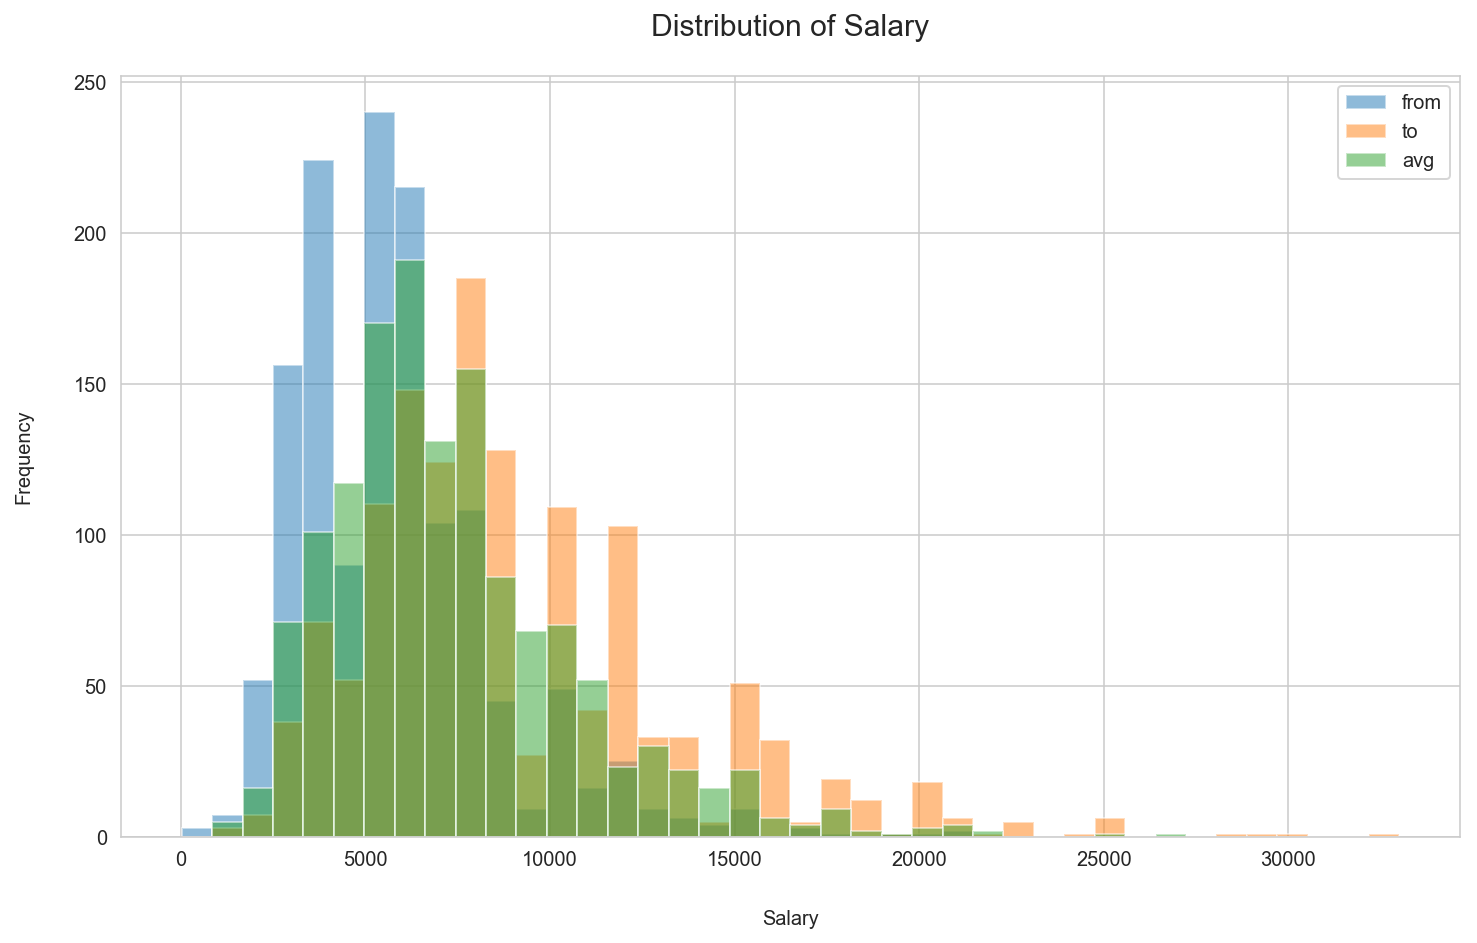

In [15]:
# Plotting distribution of salaries
plt.figure(figsize=(12,7))

# Ensuring that the bin widths are consistent between the histograms
# Put the datasets together into a big one and determine the bins edges
bins = np.histogram(np.hstack((df['Salary from'],df['Salary to'],df['Salary avg'])), bins=40)[1]

plt.hist(df['Salary from'],bins = bins, label='from', alpha=0.5)
plt.hist(df['Salary to'],bins = bins, label='to', alpha=0.5)
plt.hist(df['Salary avg'],bins = bins, label='avg', alpha=0.5)
plt.title('Distribution of Salary', fontsize=15, pad=20)
plt.ylabel('Frequency', labelpad=20)
plt.xlabel('Salary', labelpad=20)
plt.legend(loc='Upper Right')

plt.show()

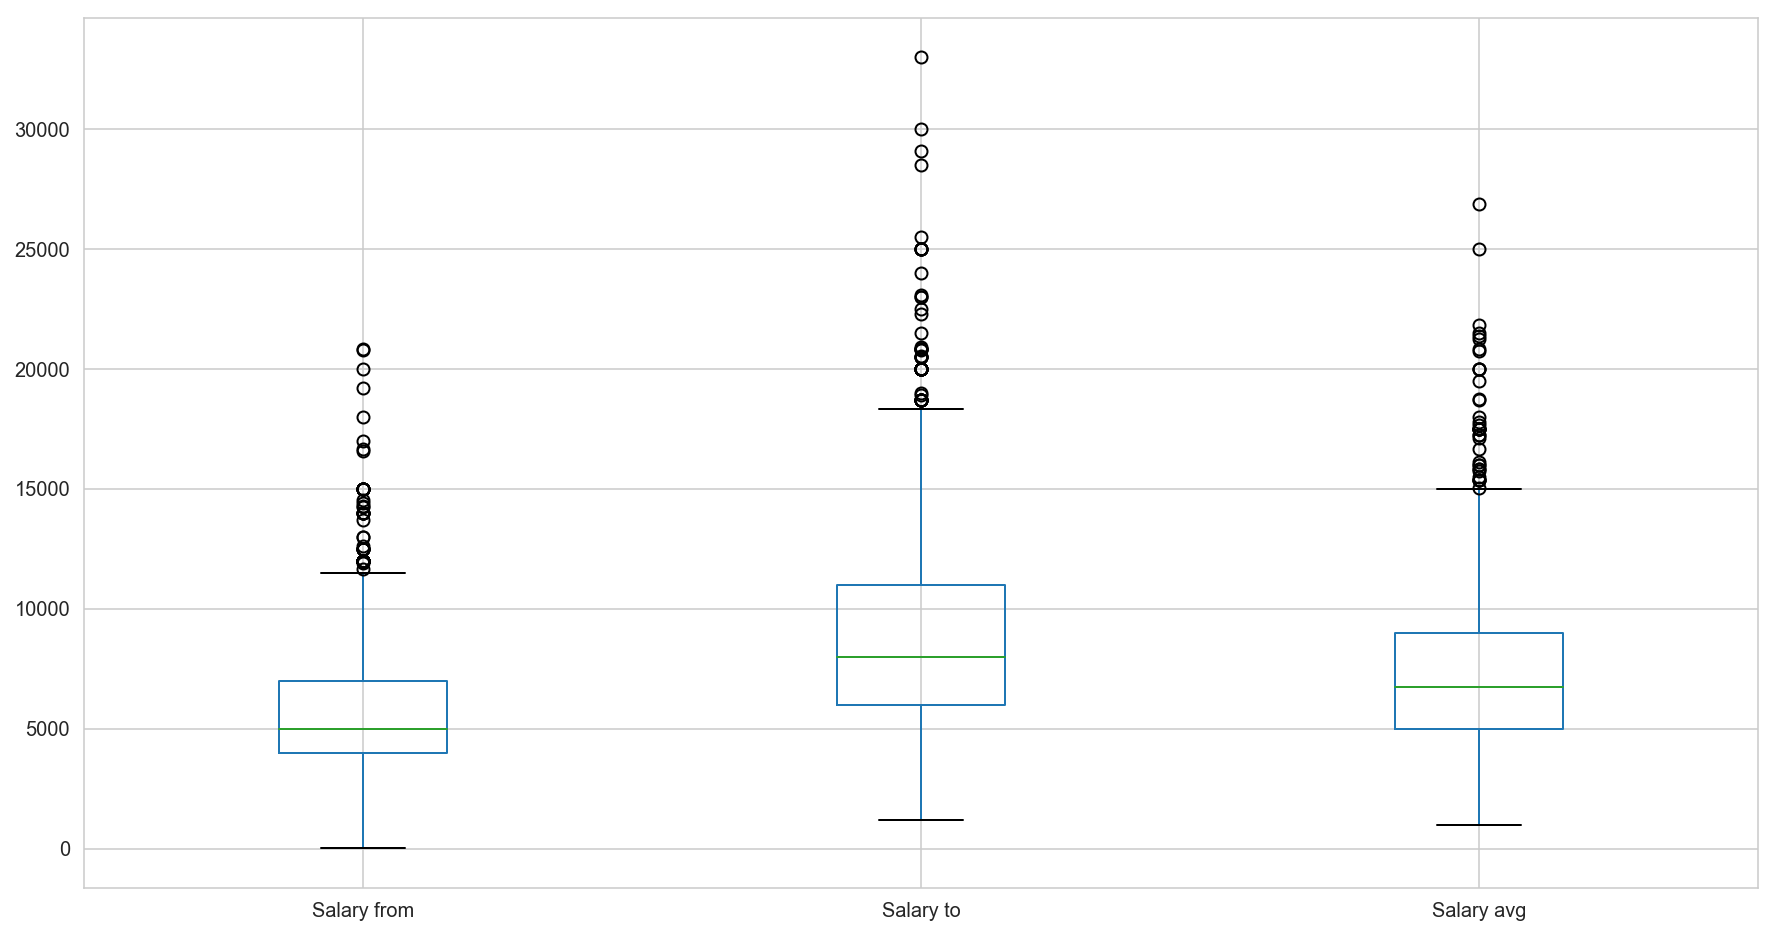

In [16]:
# Plotting boxplots of the Salary
df[['Salary from', 'Salary to', 'Salary avg']].plot(kind='box', figsize=(15,8))
plt.show()

In [17]:
districtsalary = df.groupby('District')['Salary avg'].mean().reset_index().sort_values(by='Salary avg', ascending=False)
districtsalary.head()

District   Salary avg
0        01  8389.163548
3        04  8059.846154
6        07  7788.215686
16       17  7700.000000
18       19  7625.000000

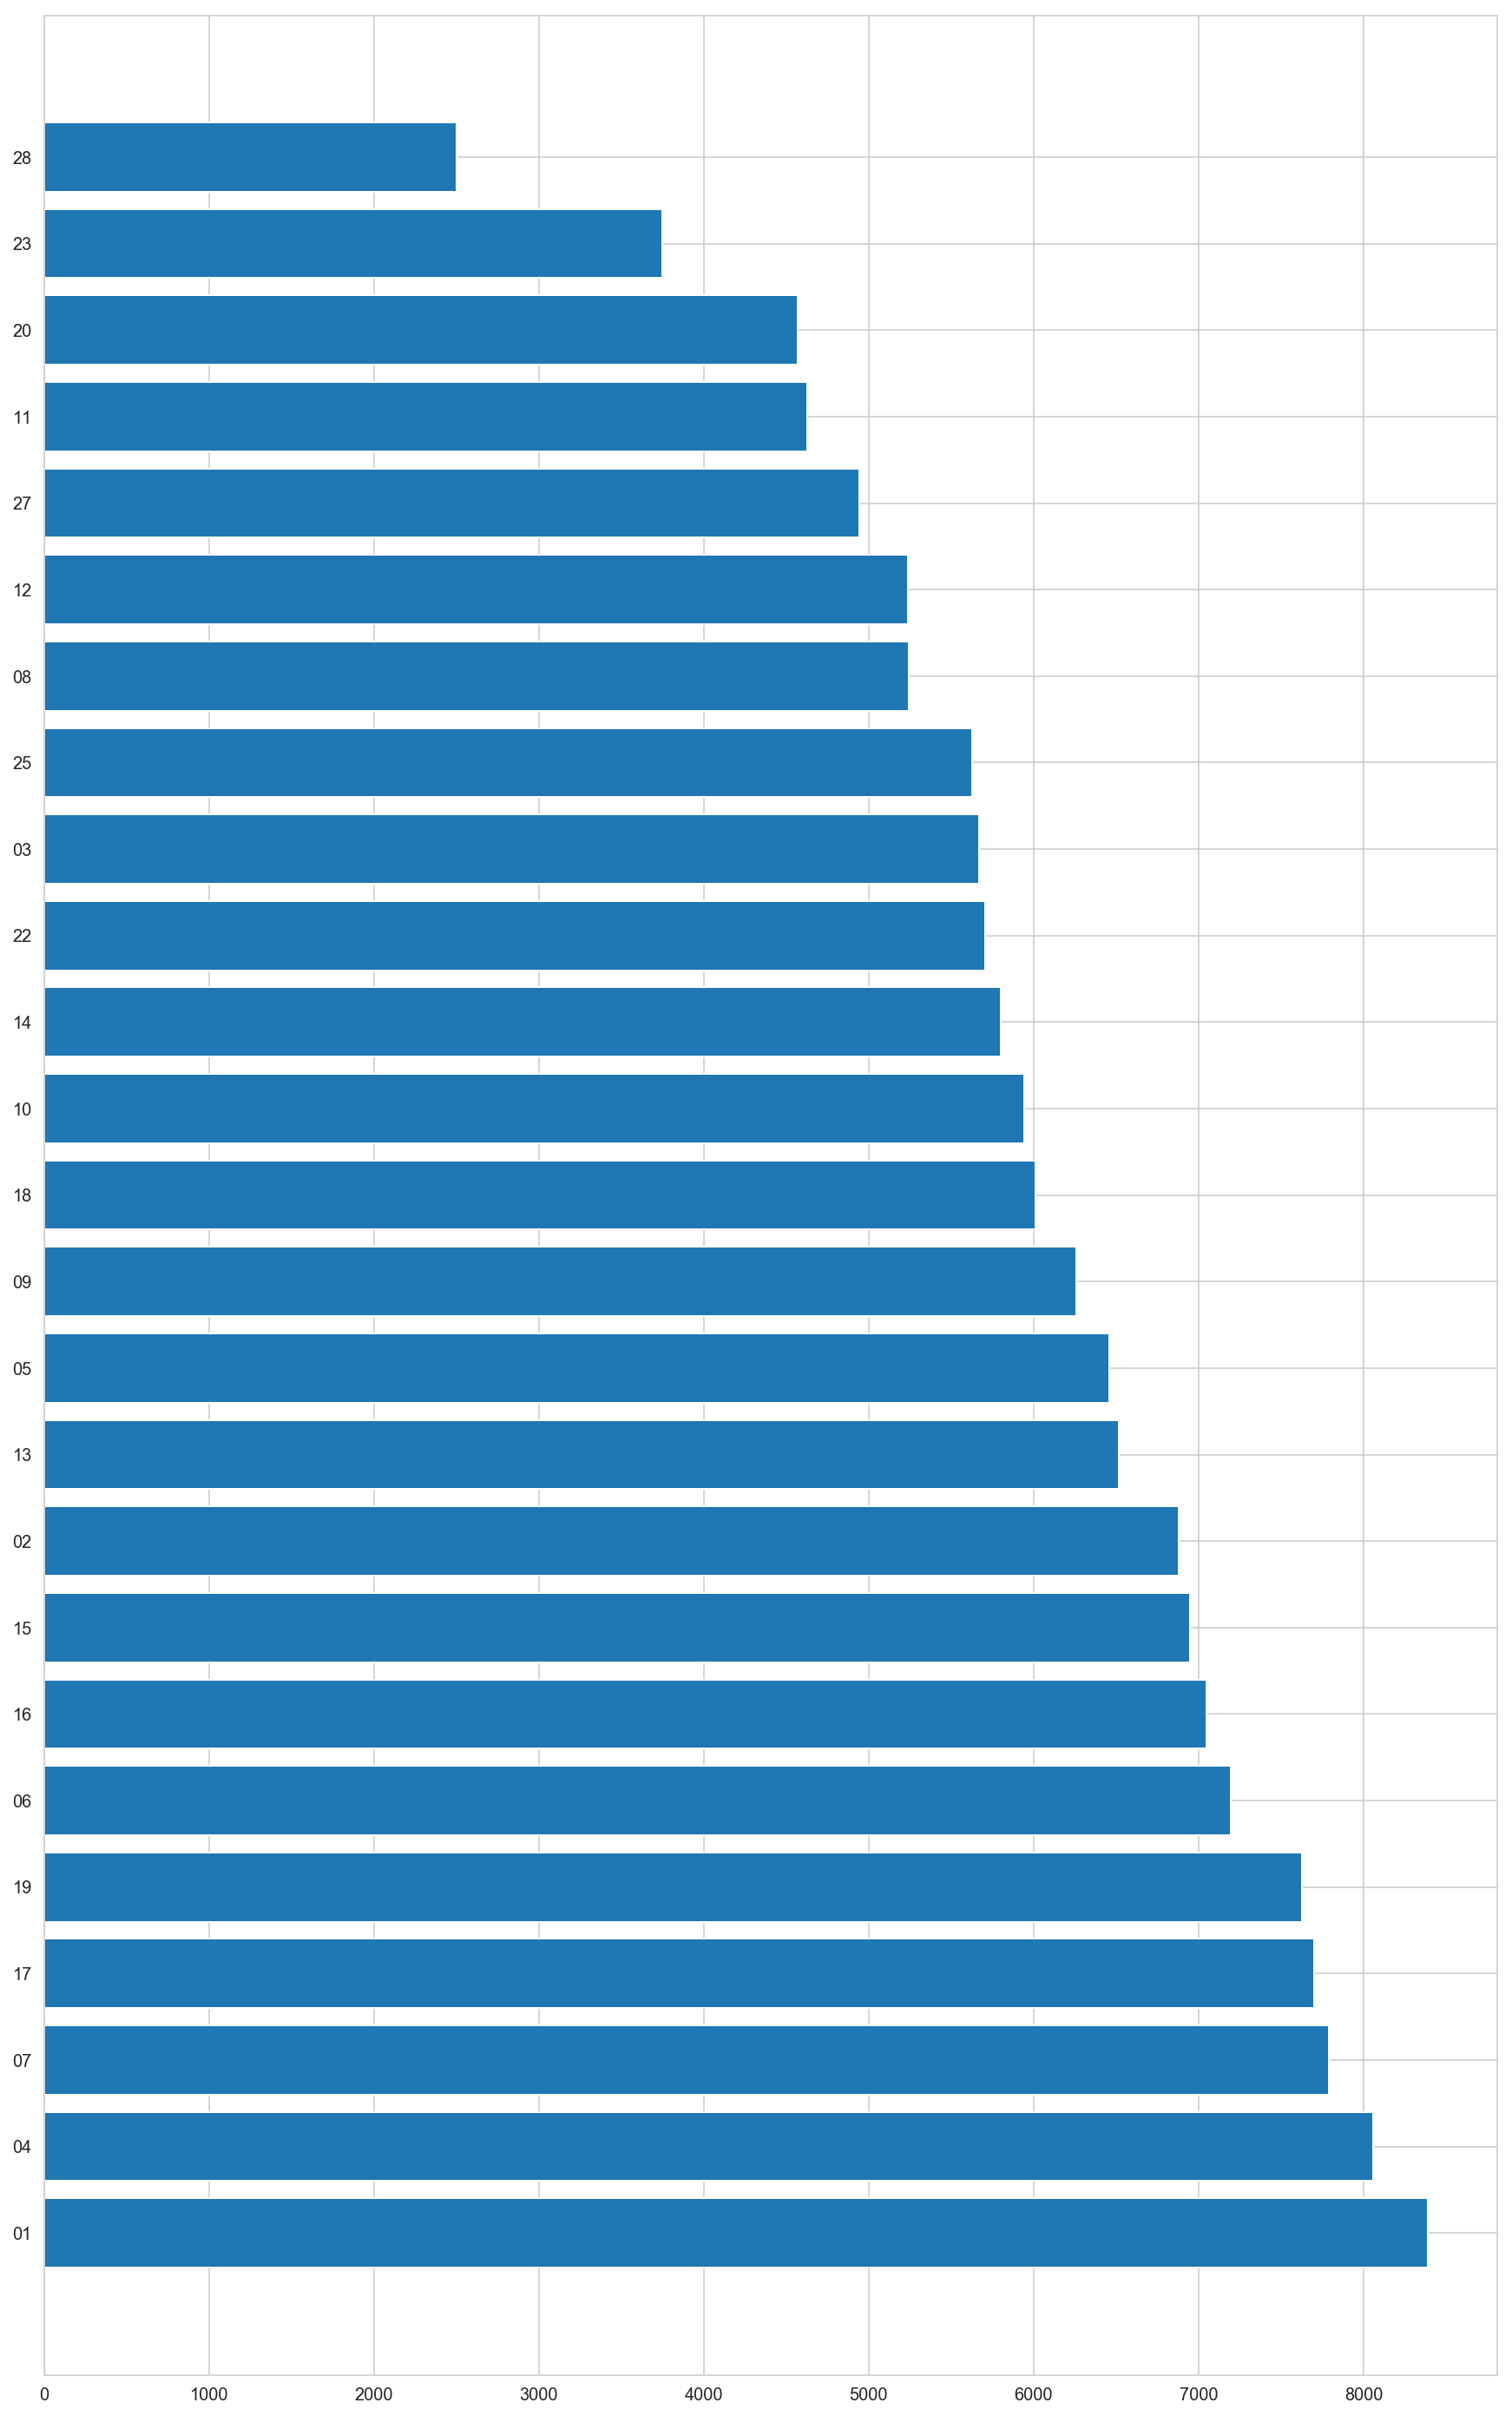

In [18]:
# Visualizing Salary across the Sector Codes

plt.figure(figsize=(15,25))
y_pos = np.arange(len(districtsalary['District']))
plt.barh(y=y_pos, width=districtsalary['Salary avg'], align='center')
plt.yticks(y_pos, districtsalary['District'])
plt.show()

<div class="alert alert-warning">
    
Seems like salary in District 01 which is Sector Codes: 01, 02, 03, 04, 05, 06

The general location of that District is: Raffles Place, Cecil, Marina, People's Park

This is not unexpected as that's the Central Business District (CBD) area and people who work there tend to draw higher salaries in general.

</div>

In [19]:
# Cleaning up the Requirements column as it seems that they all start with 'requirements'
df['Requirements'] = df['Requirements'].apply(lambda x: x[len('requirements'):] if x.startswith('requirements') else x)
df.head()

Title  \
2                 business analyst    (agile)   
3                            business analyst   
4  it business analyst - regulatory reporting   
5                            business analyst   
6                            business analyst   

                                           Company  \
2             kelly services (singapore) pte. ltd.   
3  acronis asia research and development pte. ltd.   
4            optimum solutions (singapore) pte ltd   
5                      tangspac consulting pte ltd   
6                   peoplebank singapore pte. ltd.   

                                            Location  Salary from  Salary to  \
2          ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960       9000.0    13500.0   
3     SUNTEC TOWER THREE, 8 TEMASEK BOULEVARD 038988       5000.0     7000.0   
4  PLAZA 8 @ CBP, 1 CHANGI BUSINESS PARK CRESCENT...       5500.0     8000.0   
5               THE OCTAGON, 105 CECIL STREET 069534       8500.0    10000.0   
6           ROBINSON CENTRE, 61 ROBINSON ROAD 068893       5500.0     7200.0   

   Salary Type      Employment Type                       Seniority  \
2            1             Contract                    Professional   
3            1            Full Time                       Executive   
4            1            Full Time               Fresh/entry level   
5            1  Contract, Full Time  Professional, Senior Executive   
6            1             Contract                Senior Executive   

                                             Summary  \
2   delivery experience in agile is a must as new...   
3  as a business analyst, you will be responsible...   
4  optimum solutions (company registration number...   
5  job objectives •             analyses business...   
6   understanding the needs of multiple stakehold...   

                                        Requirements  Salary avg Postal Code  \
2   requirements:   acted as a scrum master role ...     11250.0      018960   
3   3+ years of experience in a business analysis...      6000.0      038988   
4  job description:   functional experience/exper...      6750.0      486025   
5  key requirements •             around 10 years...      9250.0      069534   
6   minimally 5 years’ experience developing it s...      6350.0      068893   

  Sector Code District  
2          01       01  
3          03       01  
4          48       16  
5          06       01  
6          06       01

<div class="alert alert-warning">
    
### Building the models

We would be attempting to test various models to accurately predict salary based on various individual features:

- Title
- Company
- Location
- Employment Type
- Seniority
- Summary
- Requirements

After which, we would be attempting to blend and mix the various features together and apply the best few models on the enhanced dataset to see if we are able to get better results.

</div>

In [20]:
def show_predictions(regressor, name):
    plt.figure(figsize=(12,8))
    predictions = y=regressor.predict(X_test)
    colouring = np.where(predictions < y_test, 'green', 'red')
    plt.scatter(x=y_test, y=predictions, c=colouring)
    plt.title(name + " (Predictions vs Actual)")
    plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], linestyle='dotted', c='black')
    plt.xlabel("Actual")
    plt.ylabel(name + " predictions")
    plt.annotate("Predicted salary too high\n(bad)", xy=(y_test.min(), y_test.max()), color='red')
    plt.annotate("Predicted salary too low\n(ok)", xy=(y_test.max(),y_test.min()), color='green')
    
def plot_residuals(regressor, name):
    plt.figure(figsize=(12,8))
    residuals = y_test - regressor.predict(X_test)
    sns.distplot(residuals)
    plt.title('Distribution plot of Residuals for ' + name,fontsize=15, pad=20)
    plt.ylabel('Density', labelpad=15)
    plt.xlabel('Residuals', labelpad=15)
    plt.show()

In [21]:
# Creating a feature set based on the Title to predict salary

cvec = CountVectorizer()
titles = cvec.fit_transform(df['Title'])

In [24]:
titles.shape

(1379, 843)

In [25]:
titles = pd.DataFrame(titles.todense(), columns=cvec.get_feature_names())

In [26]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = titles

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=1000, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

Cross-validated scores: [ 0.29905827  0.36088894  0.18097883  0.25388743  0.14738871  0.14733205
  0.26411528 -0.01853205  0.35902359  0.39684603]
Mean Cross-validated scores: 0.23909870757323448
Std Cross-validated scores: 0.12046663871930294
Train score: 0.8335567863658765
Test score: 0.19029876295793546
Train Mean Squared Error: 2050730.763707838
Train Mean Squared Error: 7501506.528155379


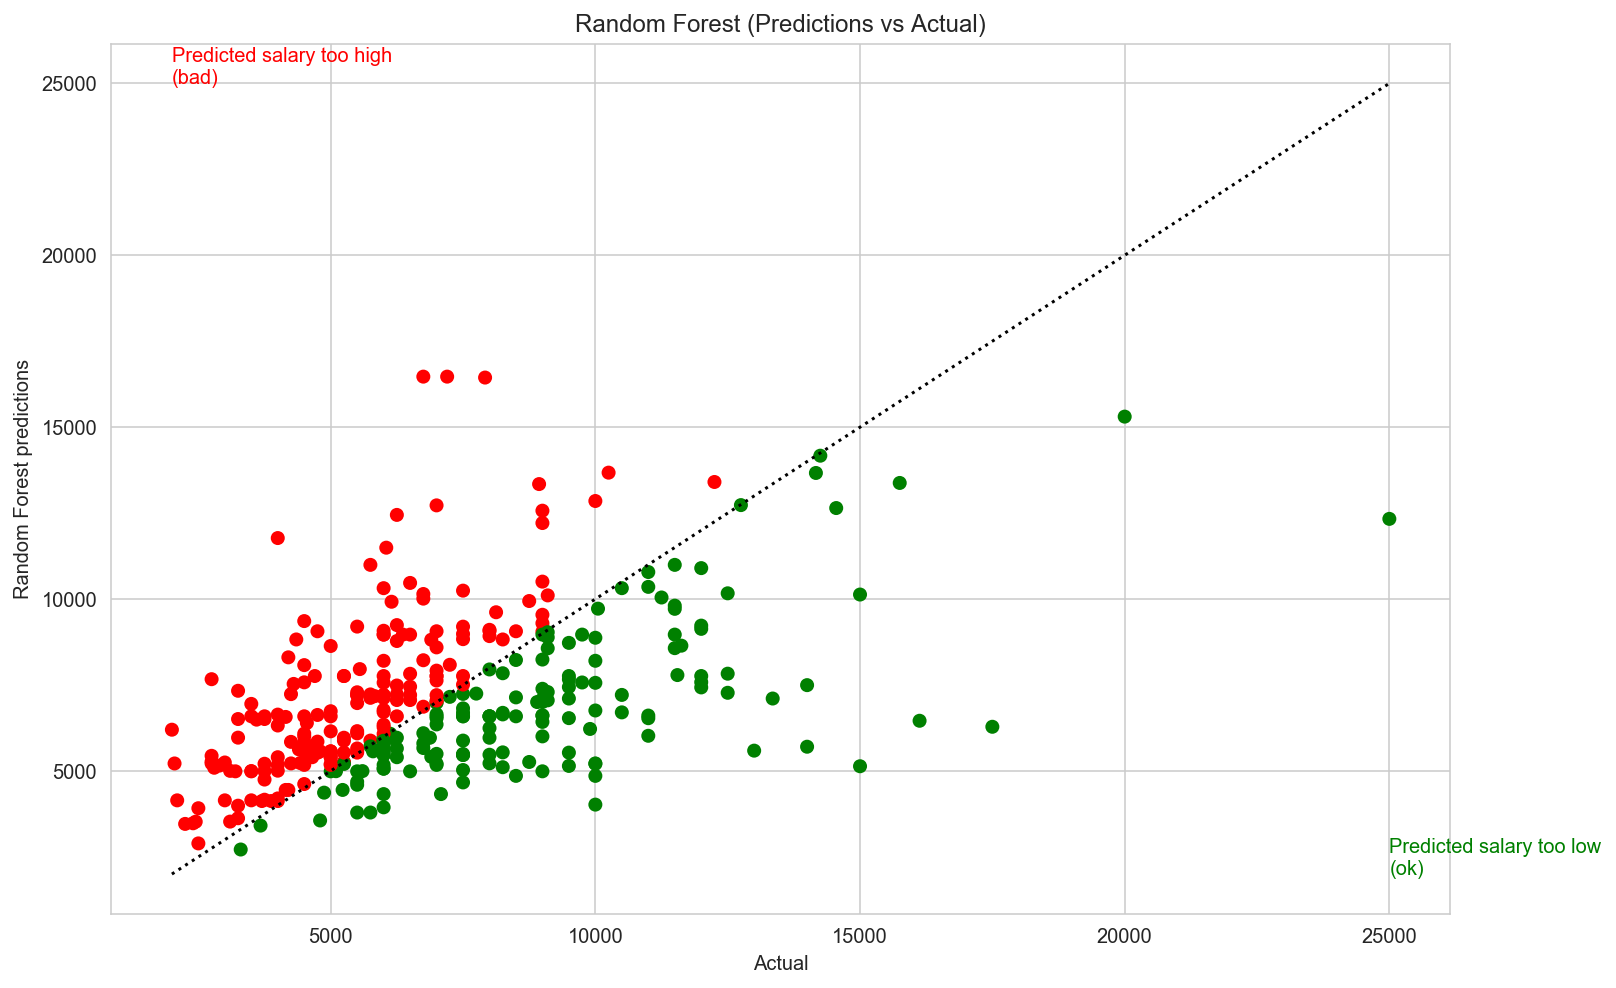

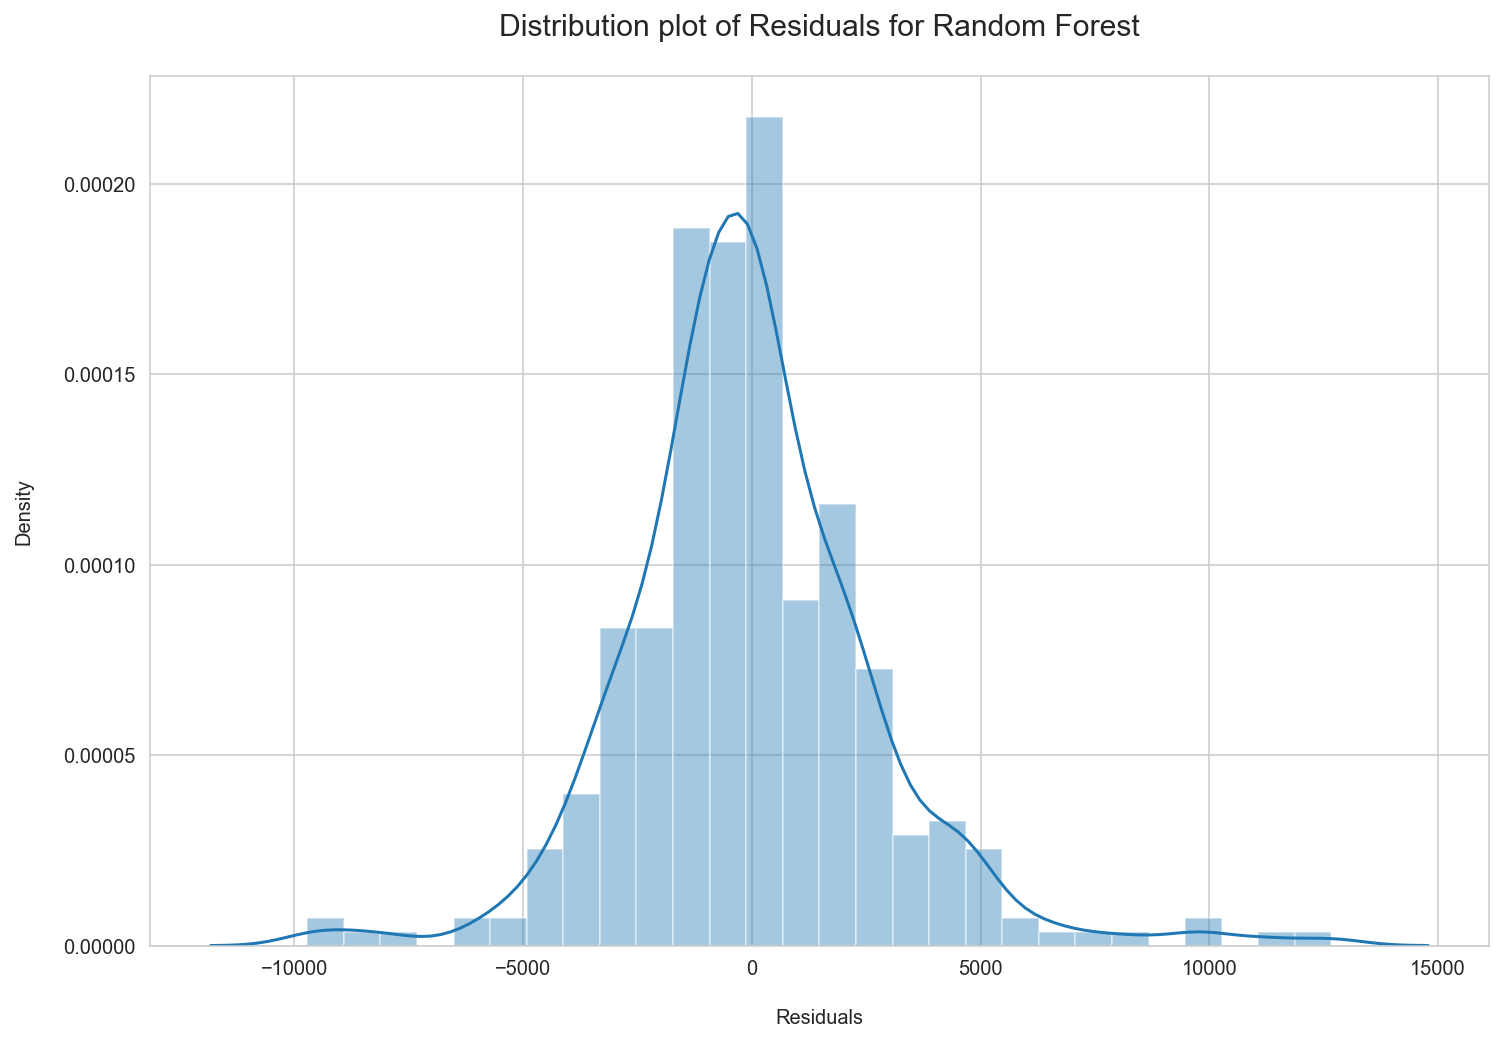

In [28]:
show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [29]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

10.824329645824813


.........[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.1s finished


In [30]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

Cross-validated scores: [0.45496628 0.19501561 0.24469927 0.25660871 0.25449792 0.23528406
 0.26802673 0.08885672 0.31104025 0.4089411 ]
Mean Cross-validated scores: 0.2717936649788199
Std Cross-validated scores: 0.0979151096896906
Train score: 0.4055511737504266
Test score: 0.29858403556454416
Train Mean Squared Error: 7324146.589237027
Train Mean Squared Error: 6498293.685935946


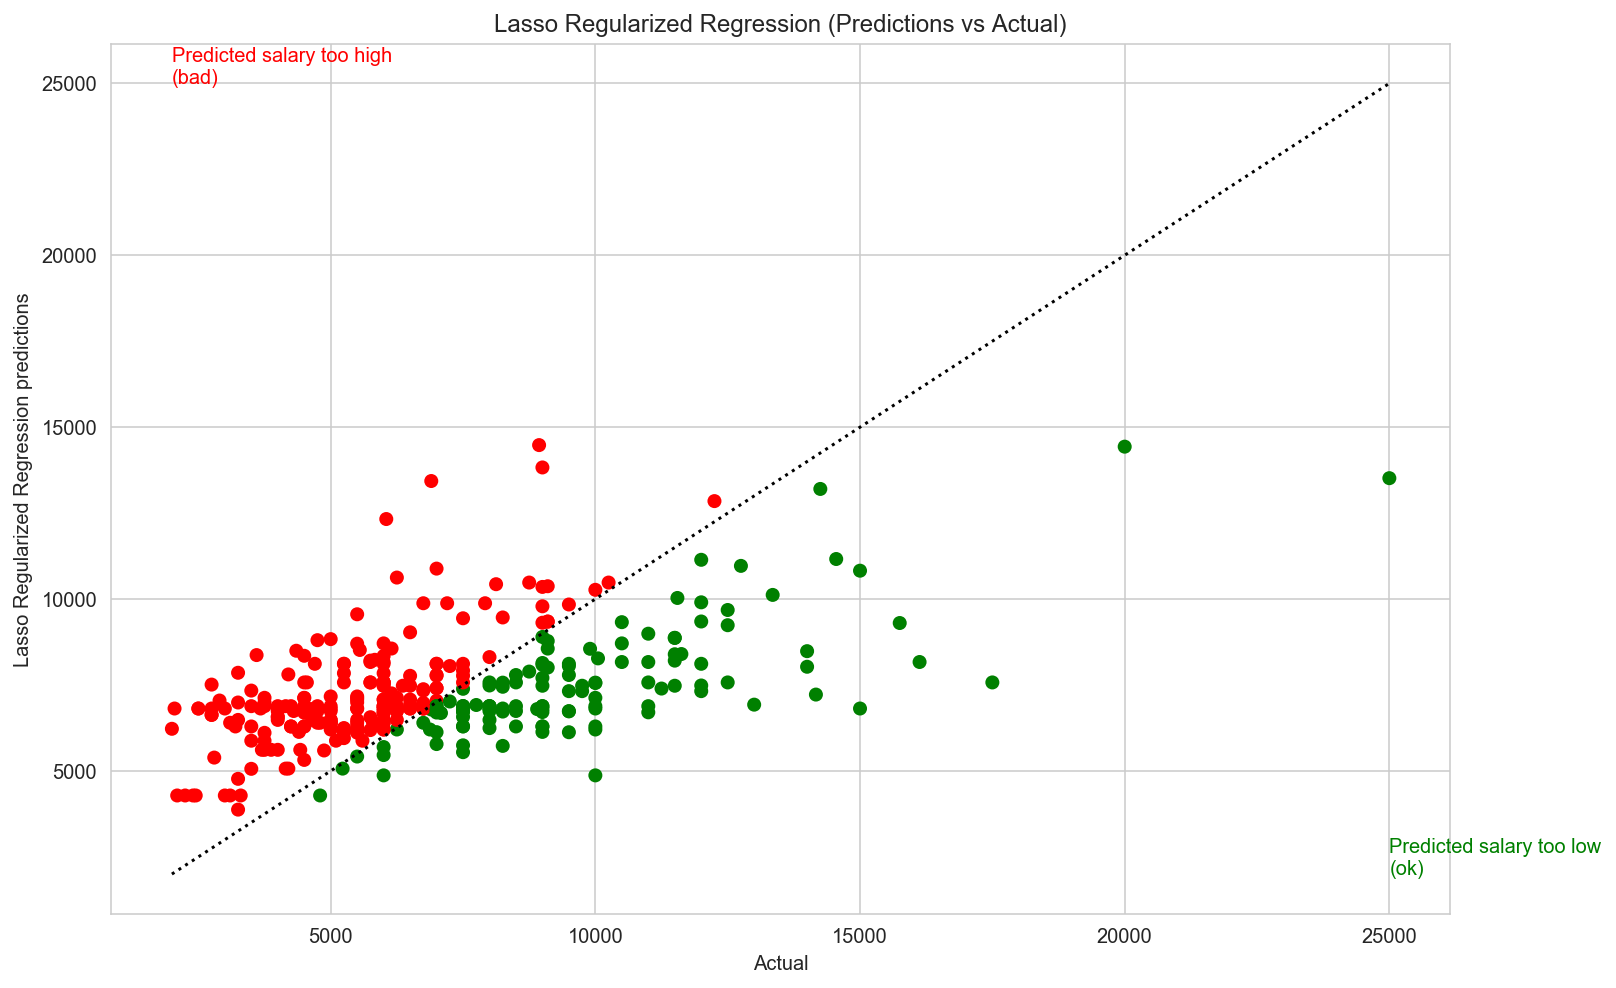

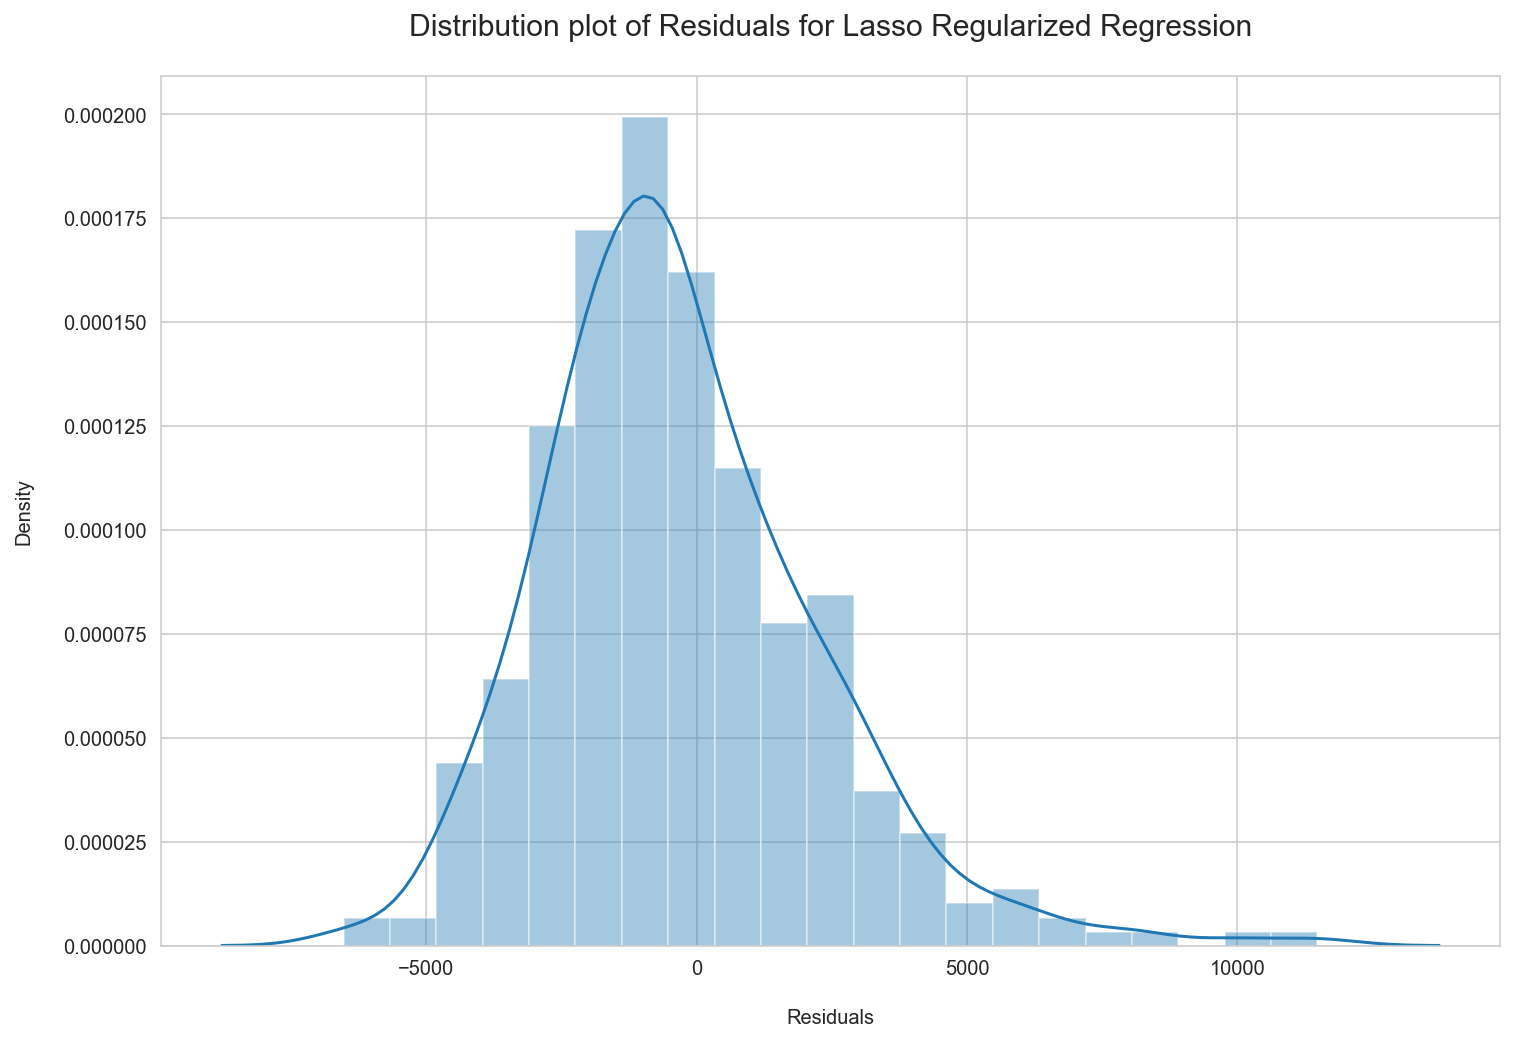

In [31]:
show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

Cross-validated scores: [0.44453332 0.22087965 0.32778352 0.34017007 0.25235614 0.29178491
 0.31249823 0.09600582 0.3684019  0.39137724]
Mean Cross-validated scores: 0.3045790810508495
Std Cross-validated scores: 0.09298476436105714
Train score: 0.5340902473873379
Test score: 0.31382142853071004
Train Mean Squared Error: 5740429.074474507
Train Mean Squared Error: 6357126.305205091


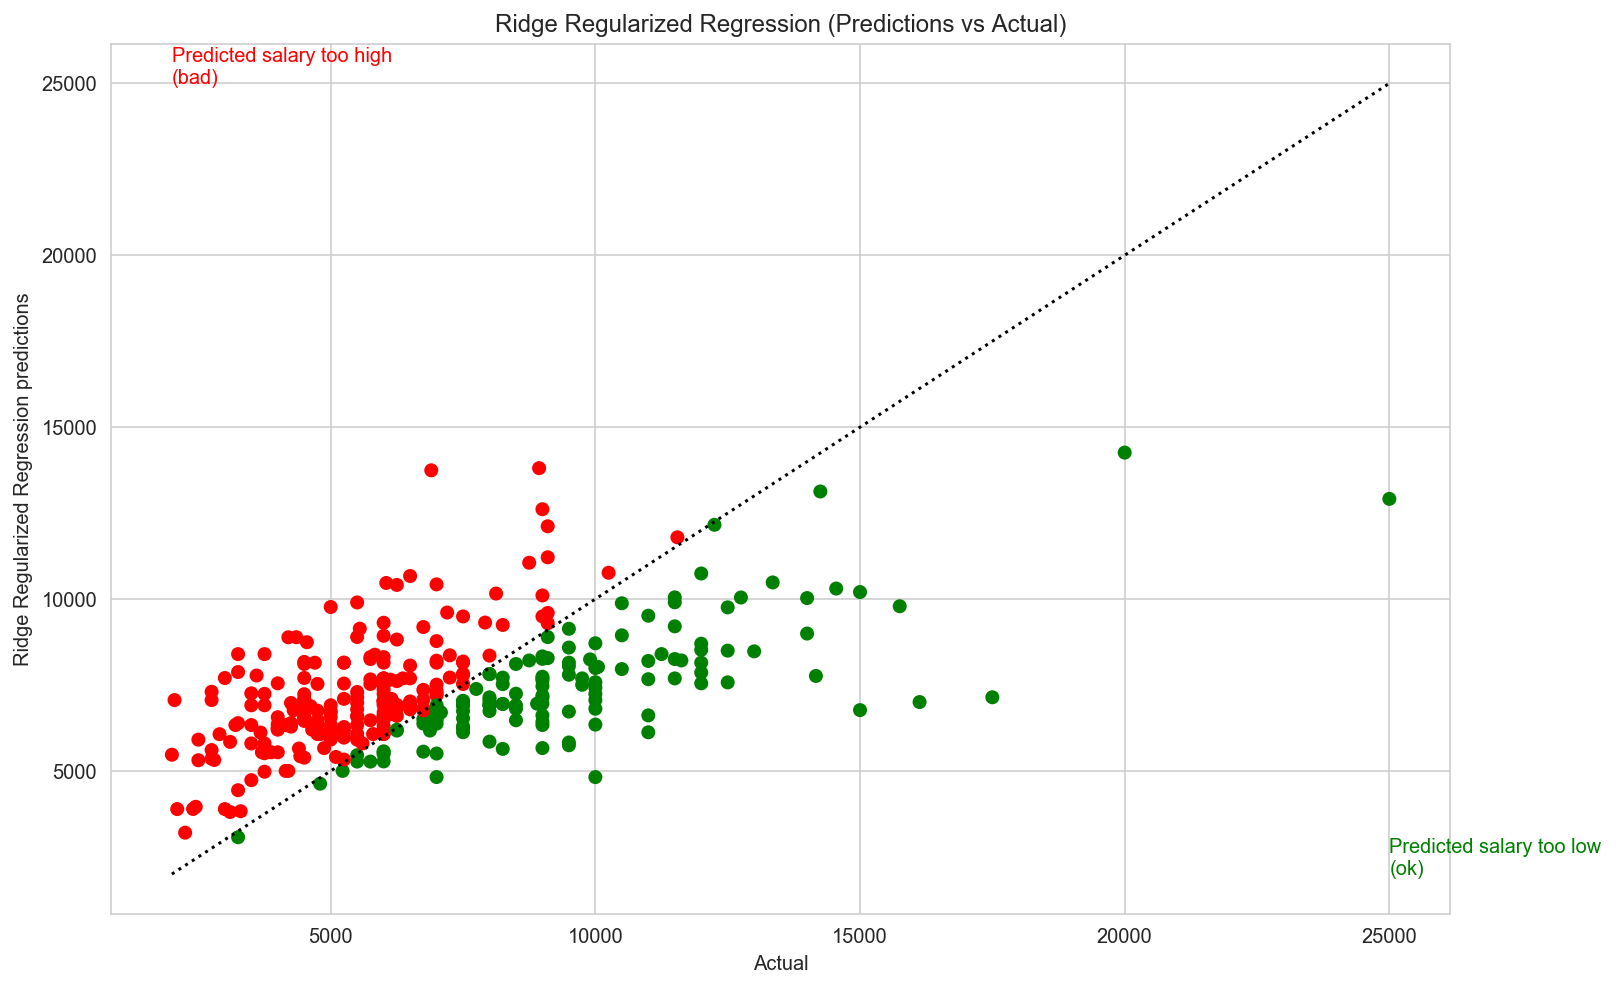

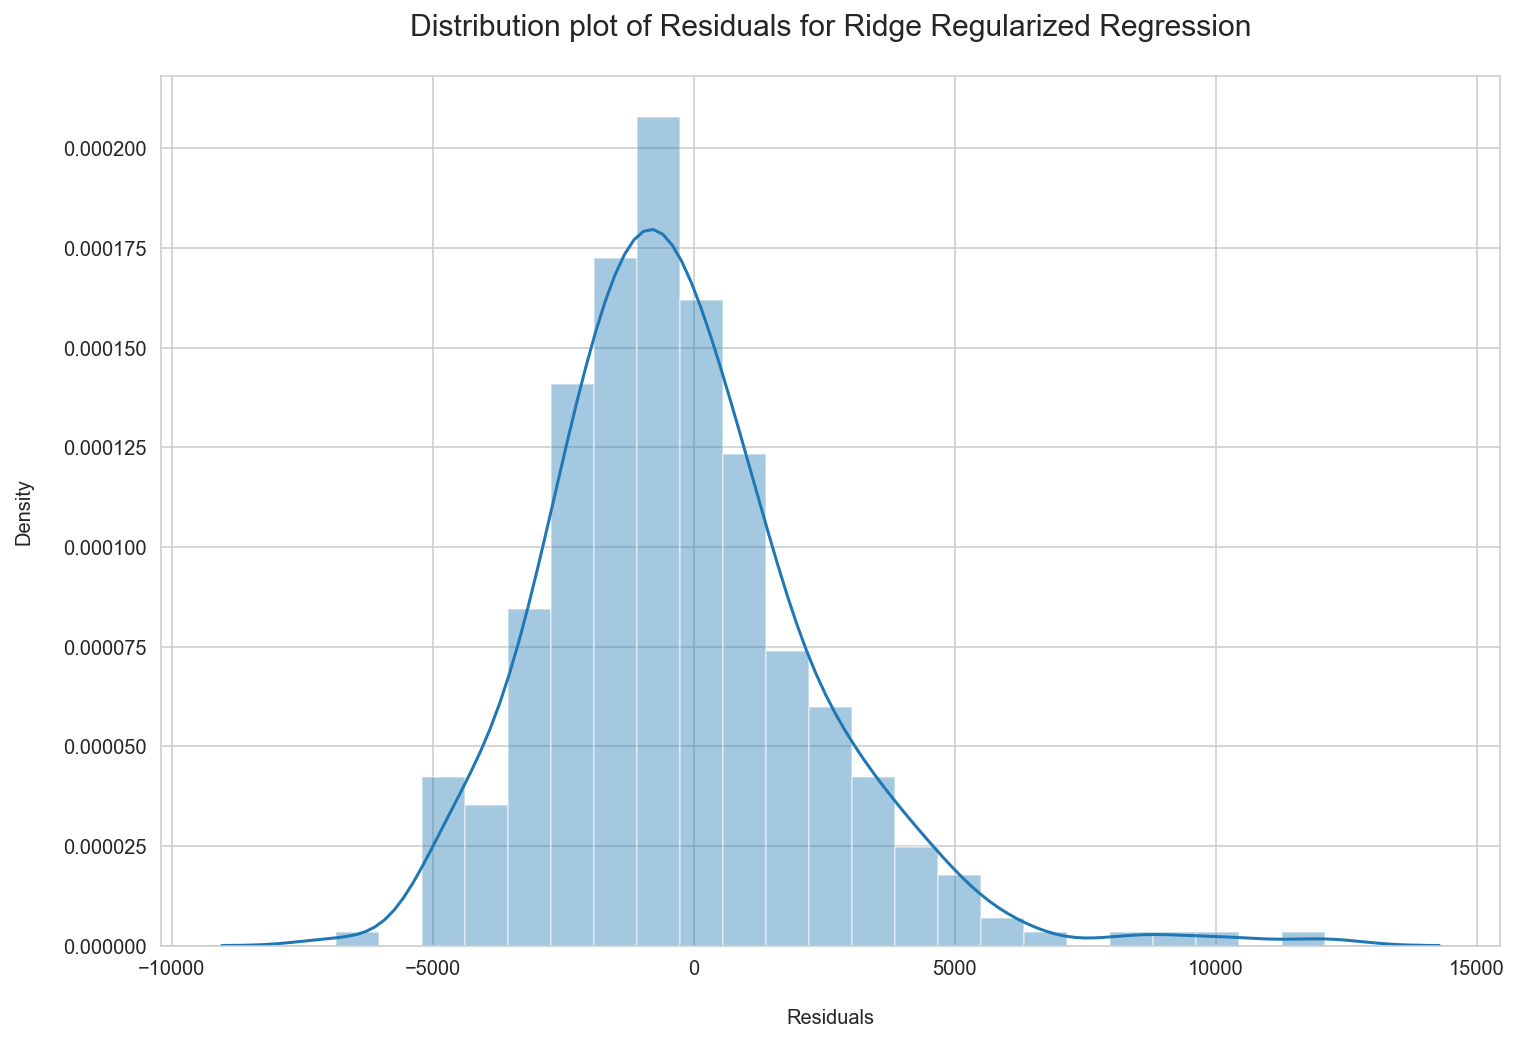

In [32]:
# Applying Ridge Regularized Linear Regression

# Finding an optimal value for the ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(-2, 7, 50)

clf = RidgeCV(alphas=ridge_alphas).fit(X_train, y_train)

# Applying the optimal alpha into Ridge Regression
ridge_reg = Ridge()

ridge_reg.set_params(alpha=clf.alpha_)

scores = cross_val_score(ridge_reg, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

ridge_reg.fit(X_train, y_train)

print("Train score:", ridge_reg.score(X_train, y_train))
print("Test score:", ridge_reg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, ridge_reg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, ridge_reg.predict(X_test)))

show_predictions(ridge_reg, 'Ridge Regularized Regression')
plot_residuals(ridge_reg, 'Ridge Regularized Regression')

In [36]:
# Creating a feature set based on Location to predict Salary
# Using Sector Code which is derived from the postal codes obtained in the Location column

locations = pd.get_dummies(df['District'])
locations.shape

(1379, 25)

In [34]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = locations

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [ 0.03960005  0.08033537  0.03905805  0.08223025  0.08513293  0.01766888
  0.00591257 -0.01600137  0.06023229  0.06345841]
Mean Cross-validated scores: 0.045762744071126196
Std Cross-validated scores: 0.03297377779209928
Train score: 0.08868872547982098
Test score: 0.02875390762082719
Train Mean Squared Error: 11228178.218671363
Train Mean Squared Error: 8998144.709576705


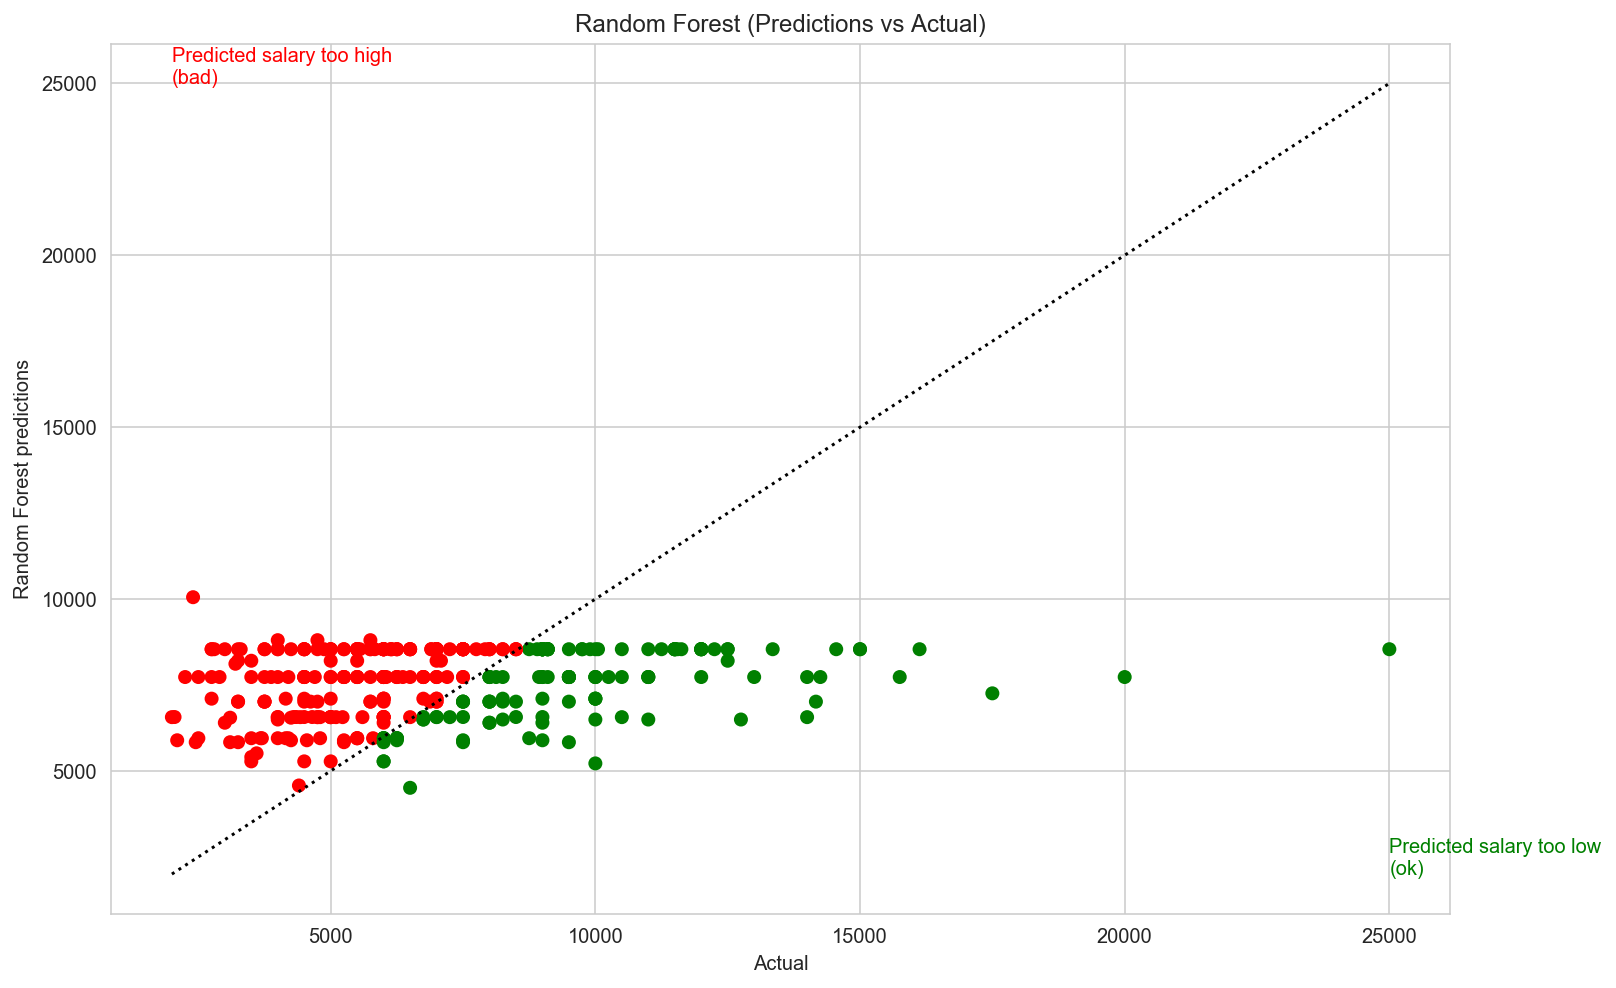

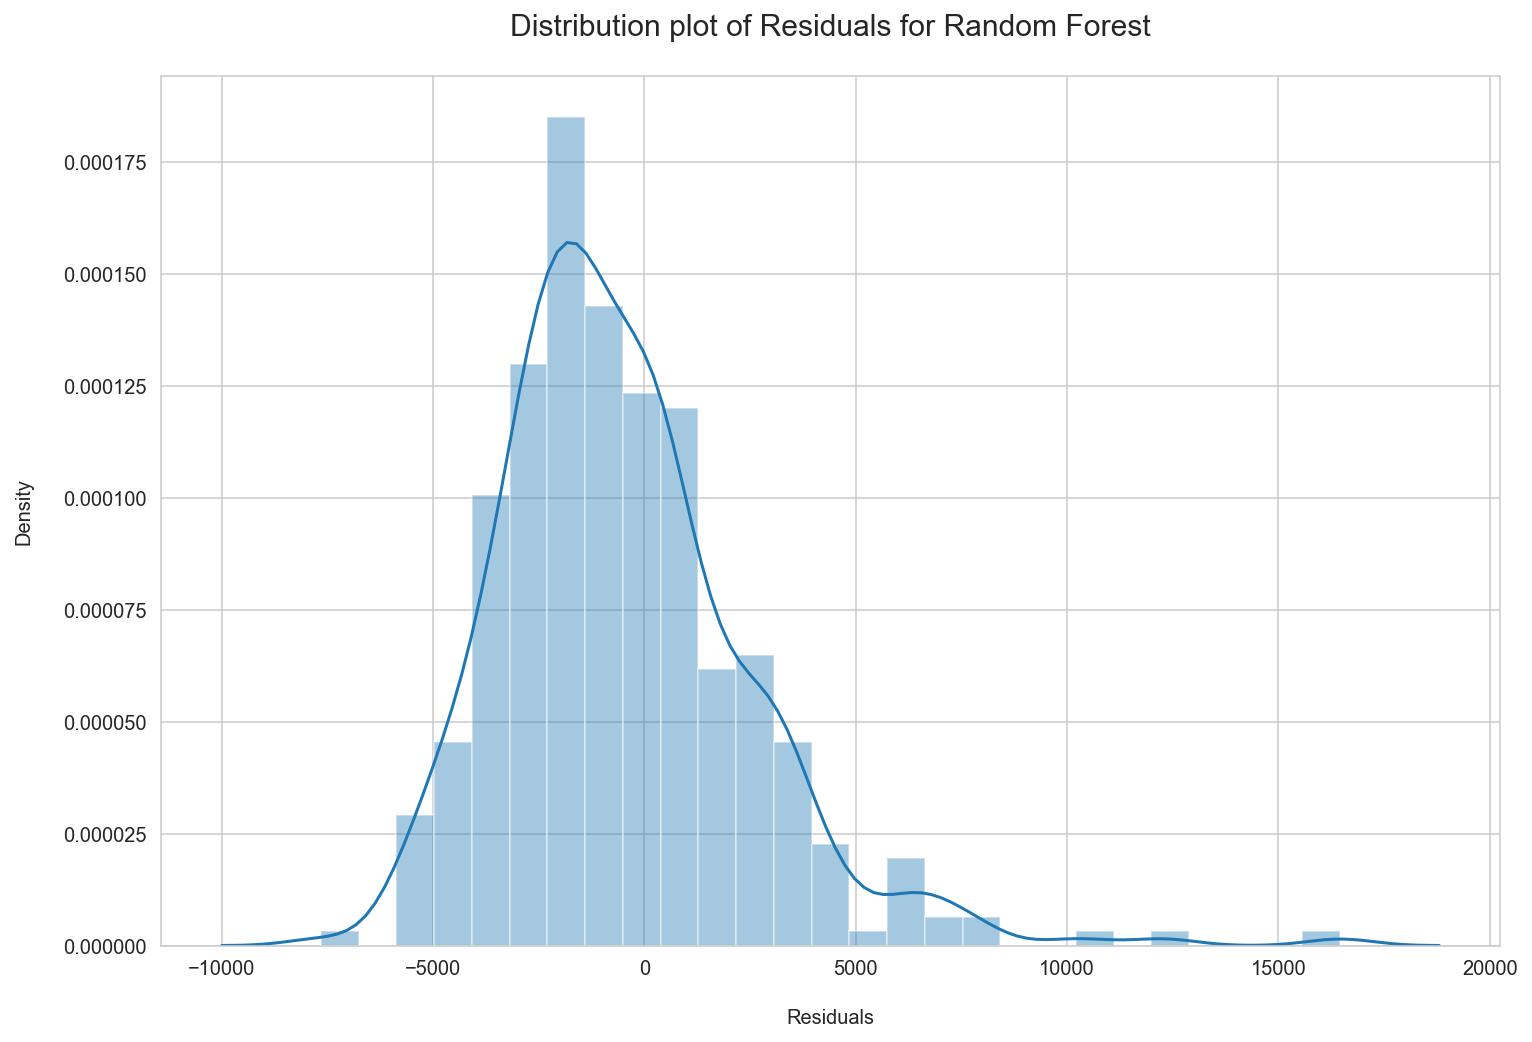

In [35]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=1000, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [37]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.6177432410751263


............................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


Cross-validated scores: [ 0.03949267  0.07857287  0.03821757  0.08149271  0.08325211  0.01911251
  0.00523155 -0.01690831  0.06177813  0.06593403]
Mean Cross-validated scores: 0.045617584444592366
Std Cross-validated scores: 0.03286132532730636
Train score: 0.08938383605205191
Test score: 0.02425528548599254
Train Mean Squared Error: 11219613.828429619
Train Mean Squared Error: 9039822.35778612


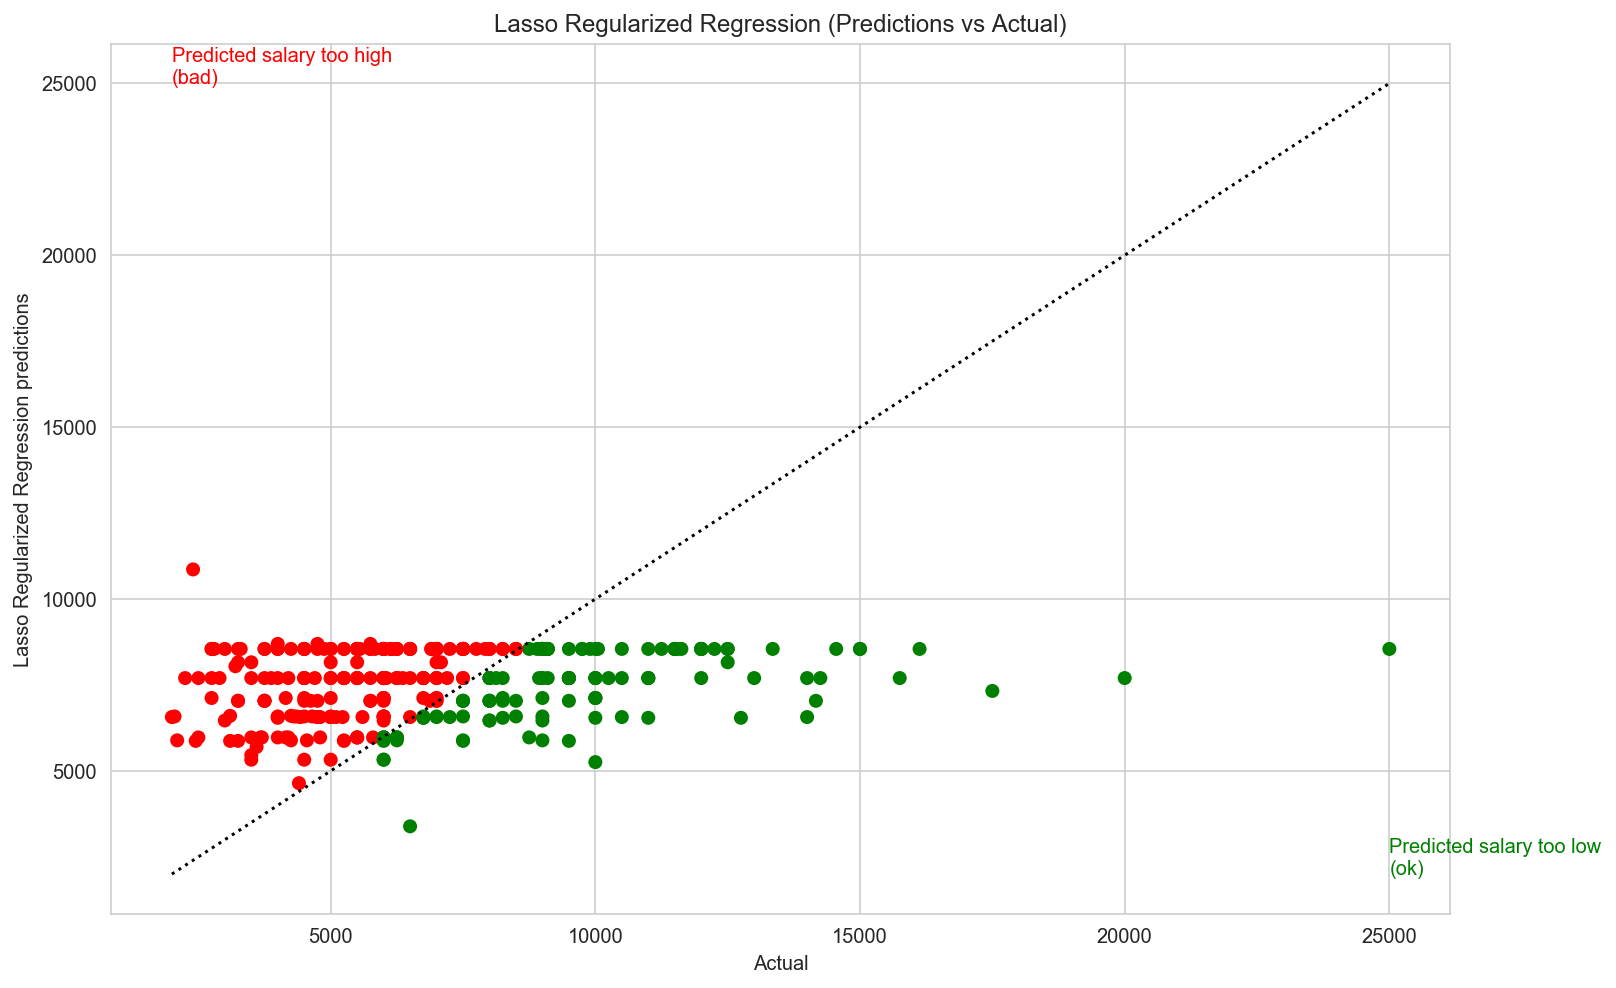

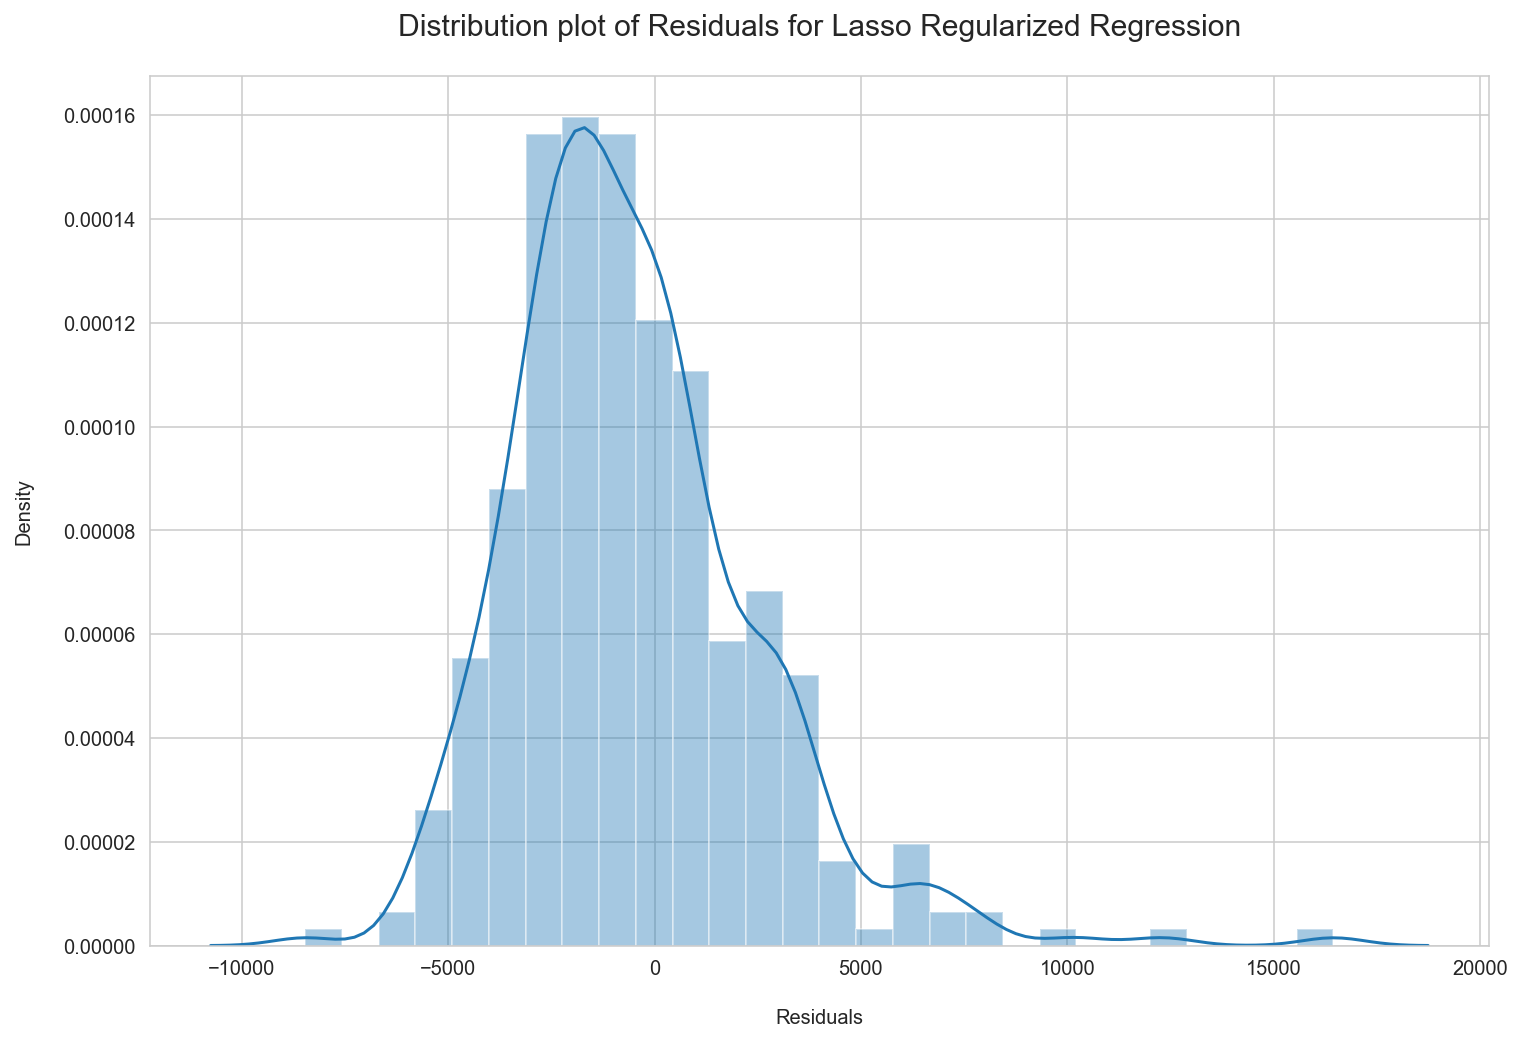

In [38]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

Cross-validated scores: [ 0.0382267   0.07058685  0.03775585  0.07828847  0.06320199  0.04092023
  0.03188498 -0.01916998  0.06921441  0.08155869]
Mean Cross-validated scores: 0.04924681951482439
Std Cross-validated scores: 0.028707894425354104
Train score: 0.07974537411427285
Test score: 0.04256987238996568
Train Mean Squared Error: 11338368.38729124
Train Mean Squared Error: 8870146.202019686


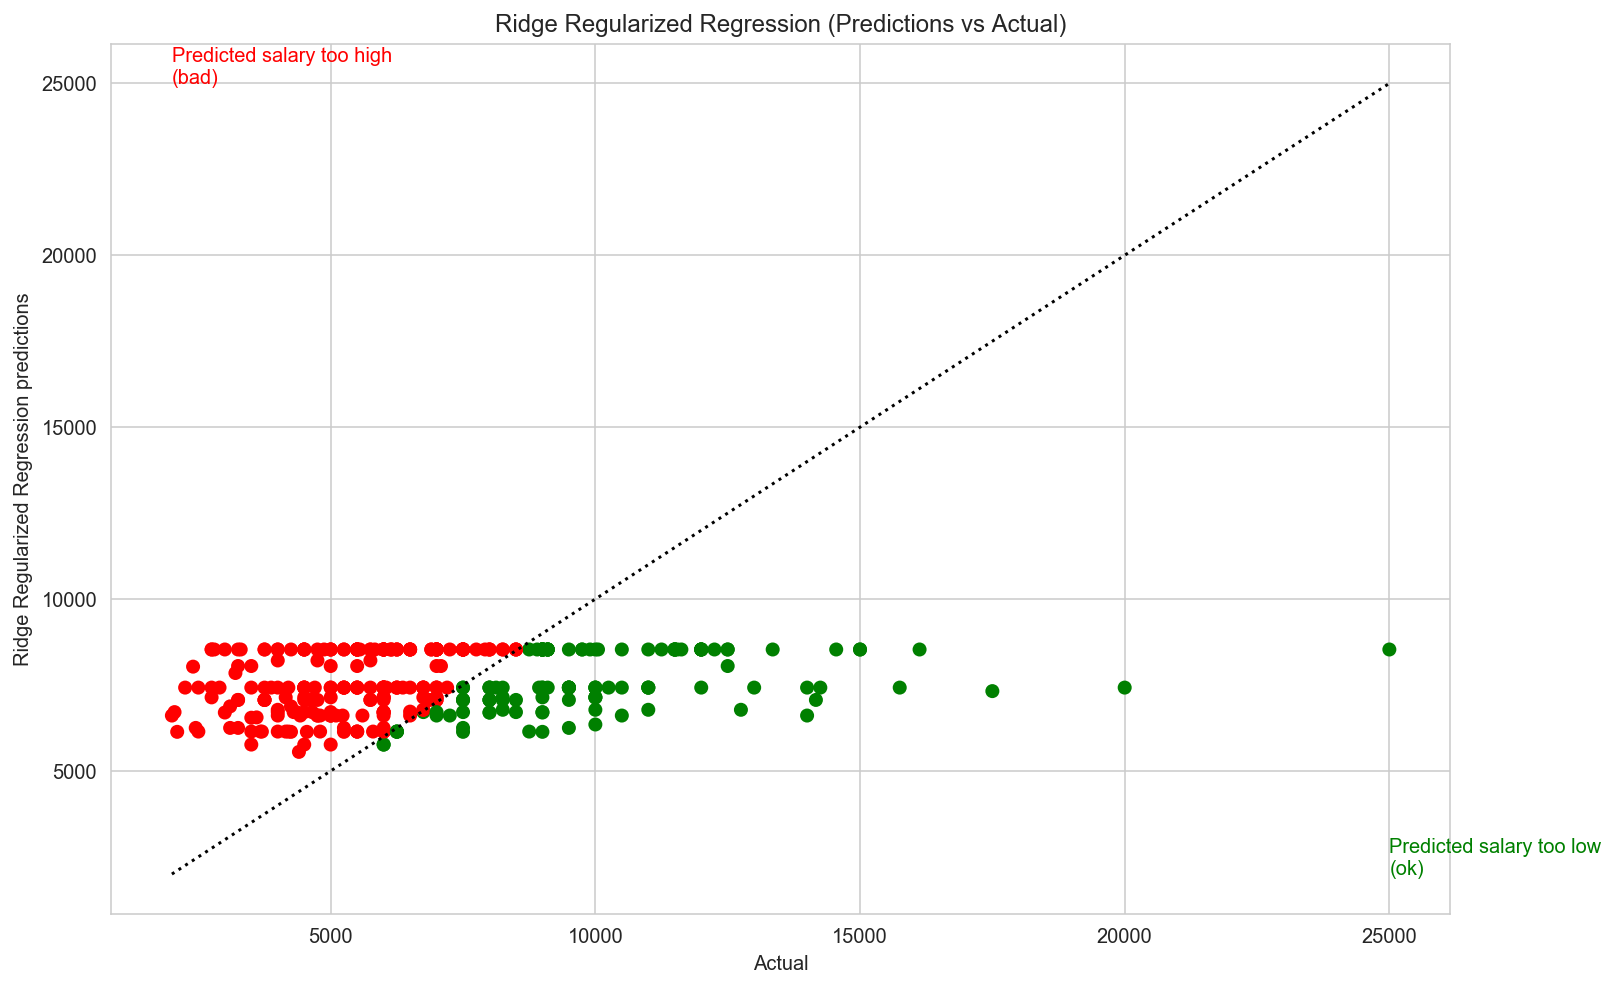

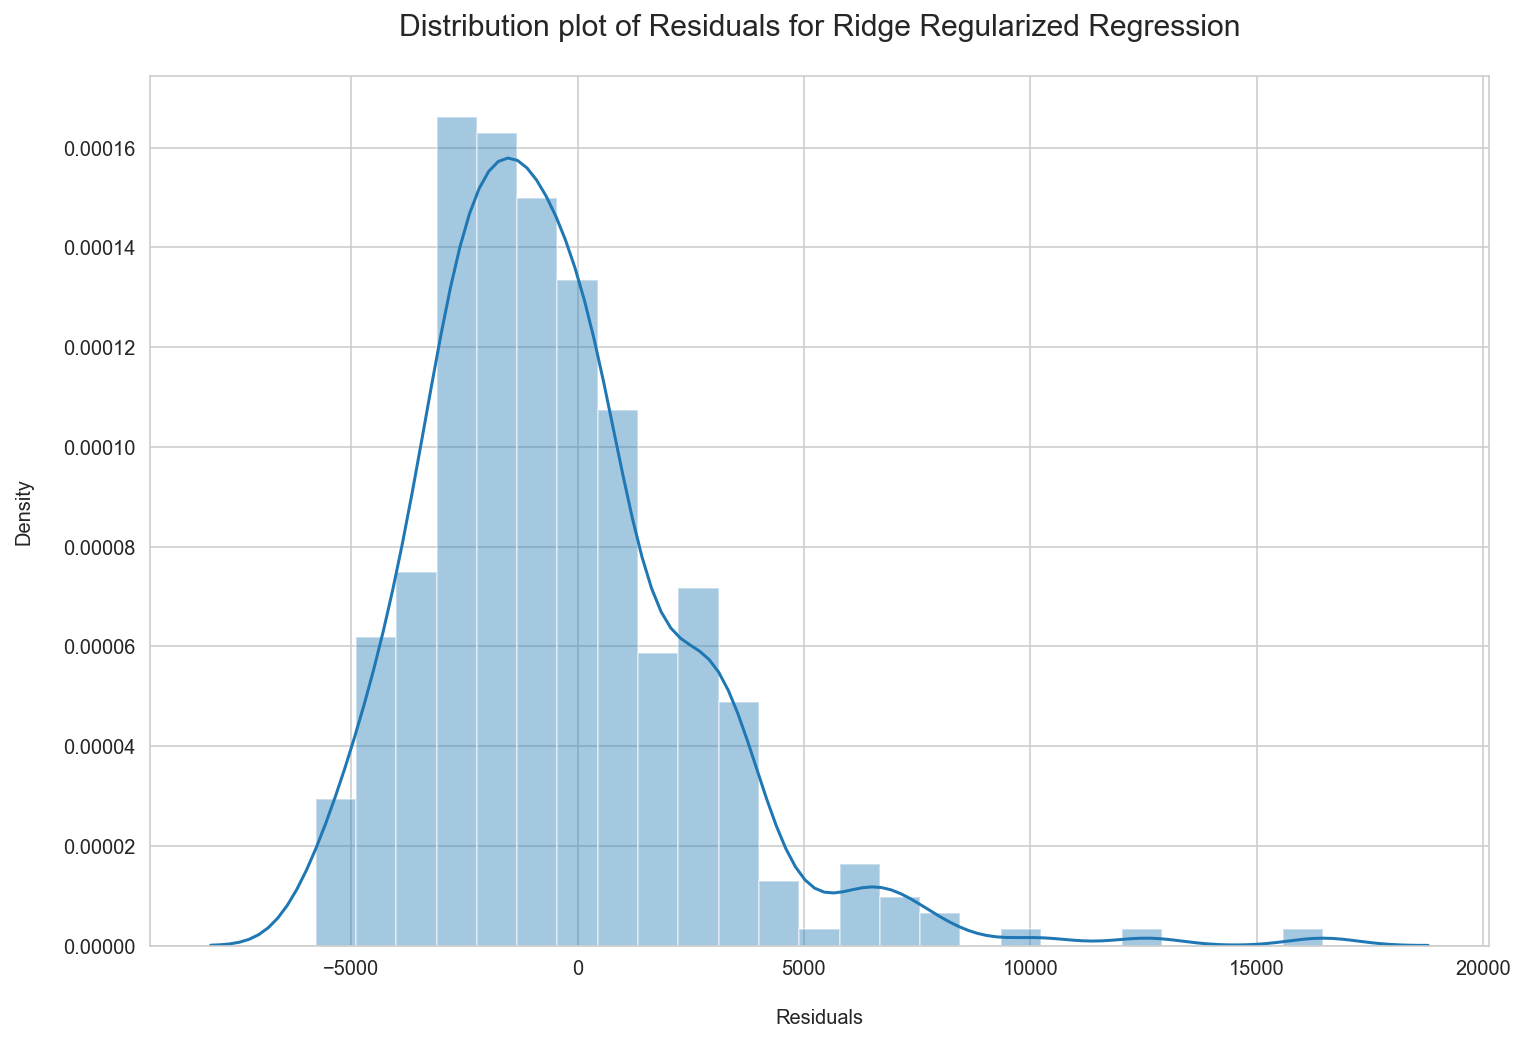

In [39]:
# Applying Ridge Regularized Linear Regression

# Finding an optimal value for the ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(-2, 7, 50)

clf = RidgeCV(alphas=ridge_alphas).fit(X_train, y_train)

# Applying the optimal alpha into Ridge Regression
ridge_reg = Ridge()

ridge_reg.set_params(alpha=clf.alpha_)

scores = cross_val_score(ridge_reg, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

ridge_reg.fit(X_train, y_train)

print("Train score:", ridge_reg.score(X_train, y_train))
print("Test score:", ridge_reg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, ridge_reg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, ridge_reg.predict(X_test)))

show_predictions(ridge_reg, 'Ridge Regularized Regression')
plot_residuals(ridge_reg, 'Ridge Regularized Regression')

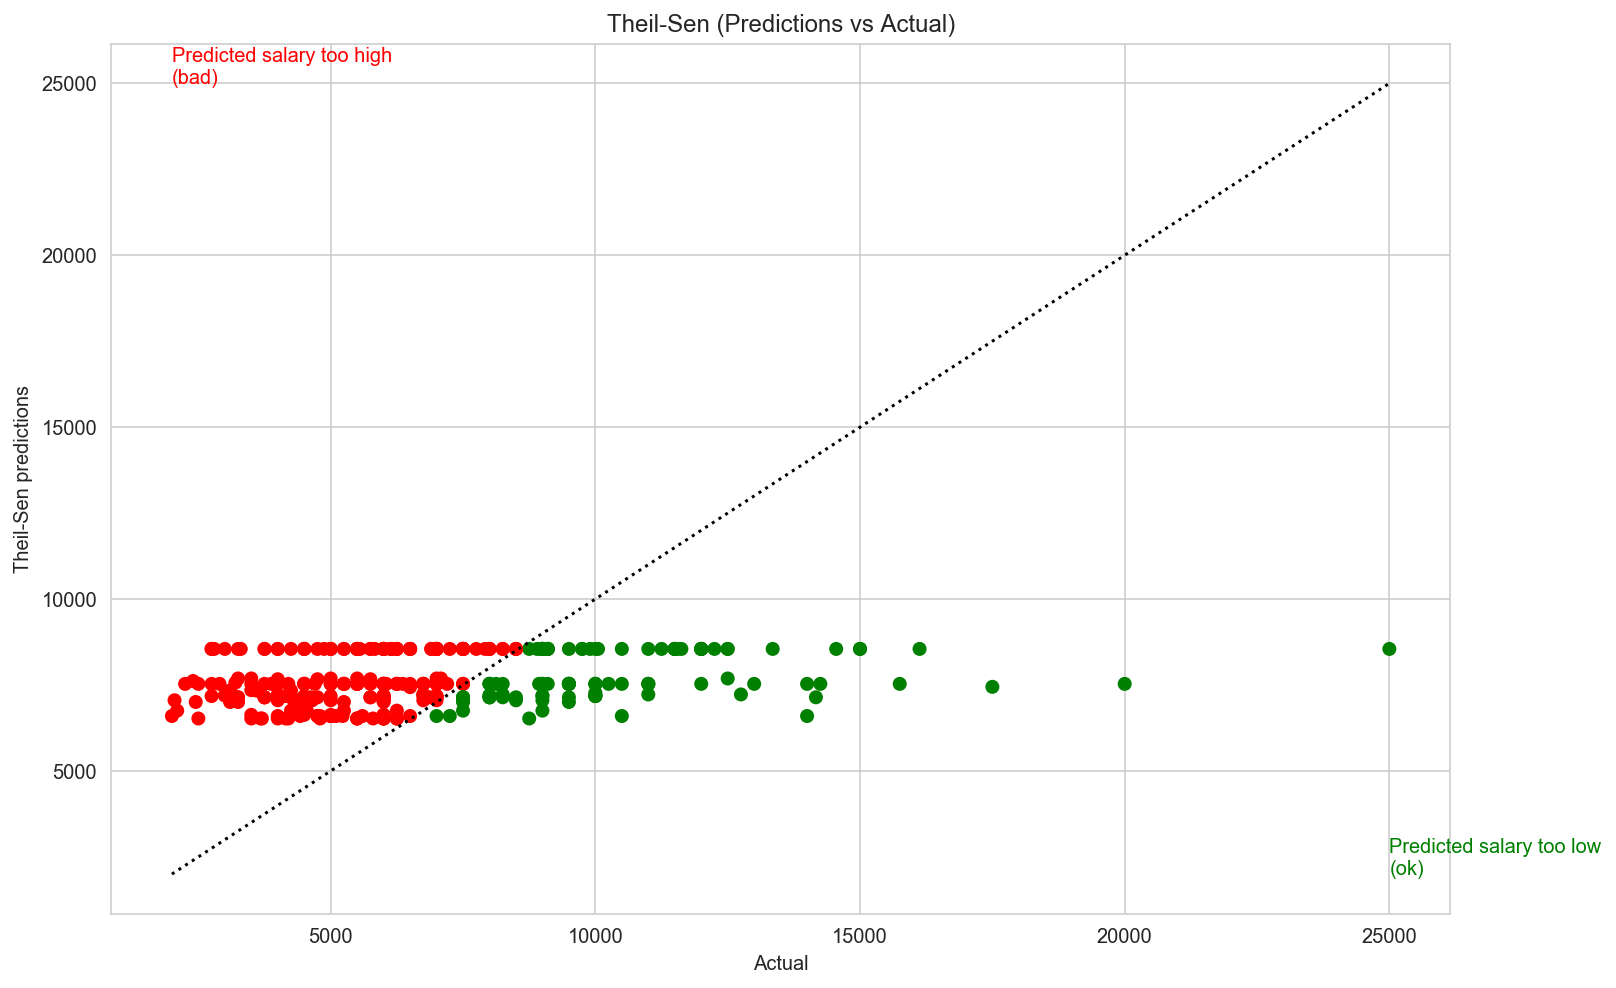

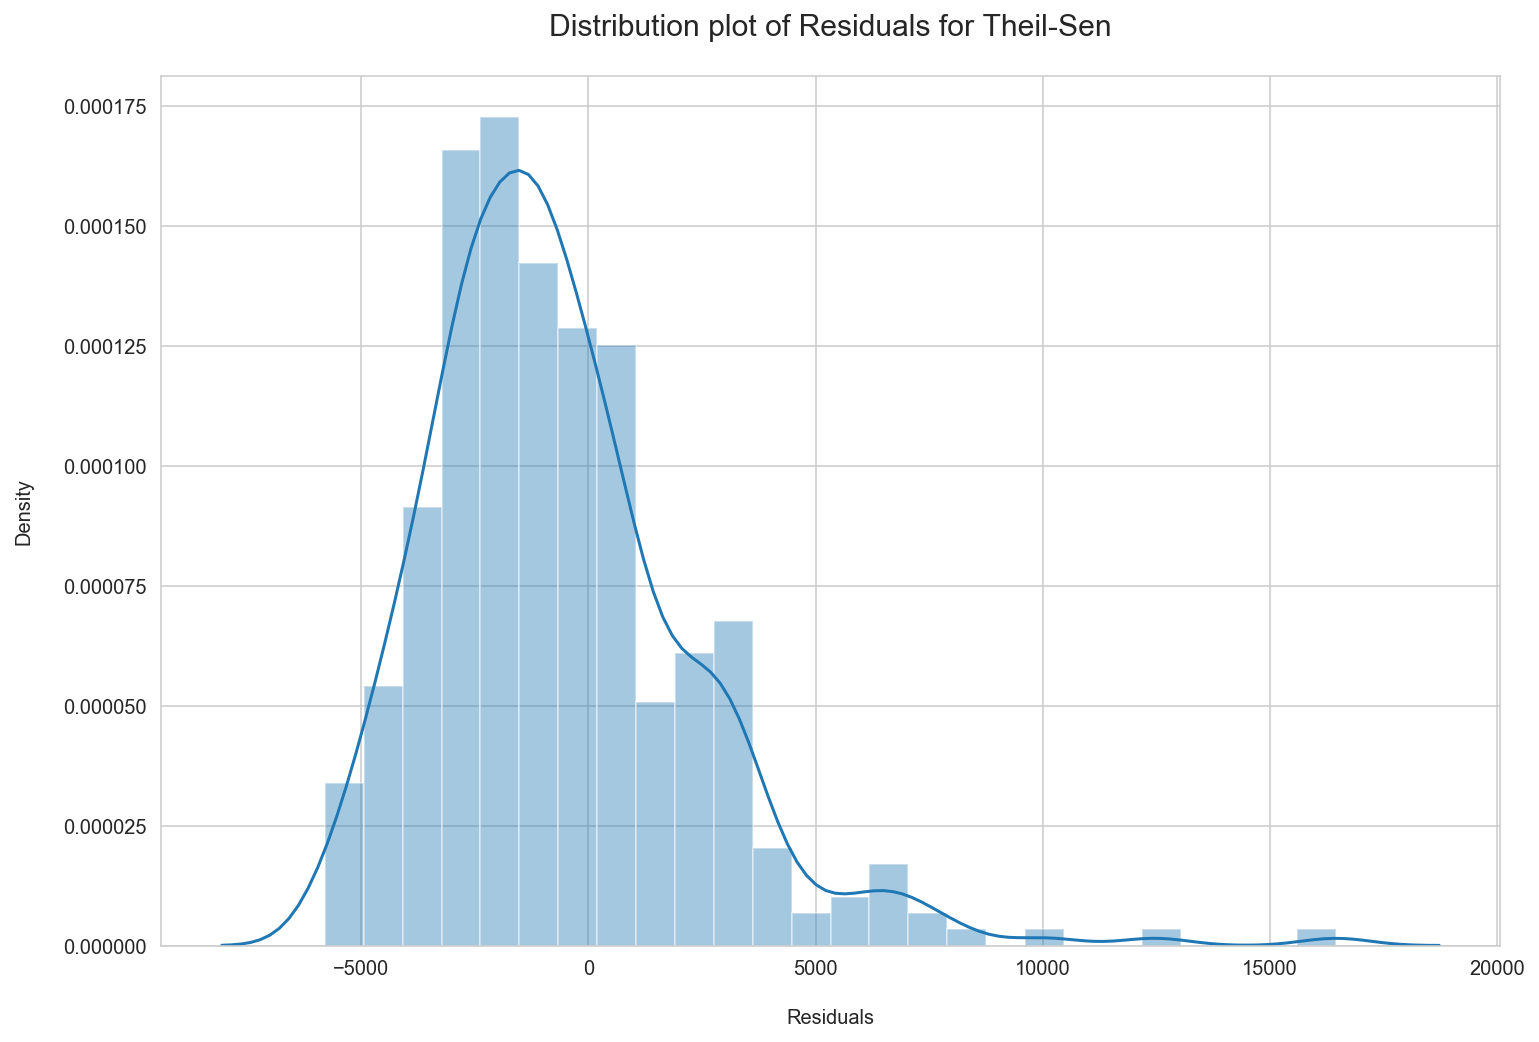

In [41]:
# Using TheilSen Regressor

ts = TheilSenRegressor()

ts.fit(X_train, y_train)

show_predictions(ts, 'Theil-Sen')
plot_residuals(ts, 'Theil-Sen')

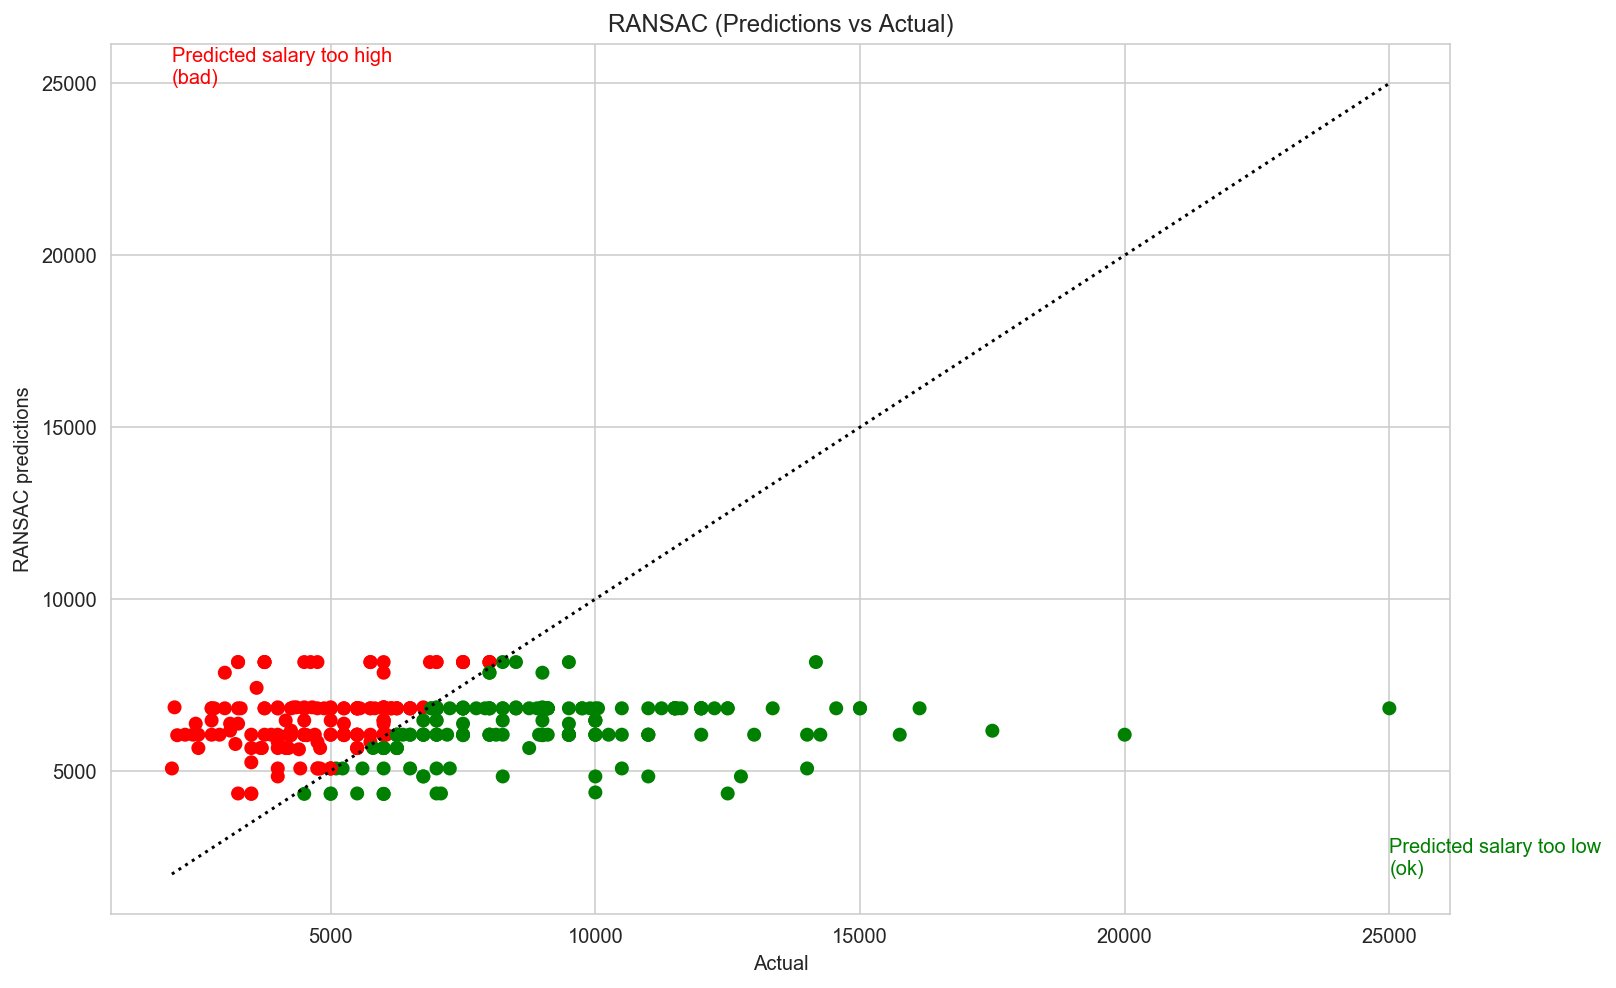

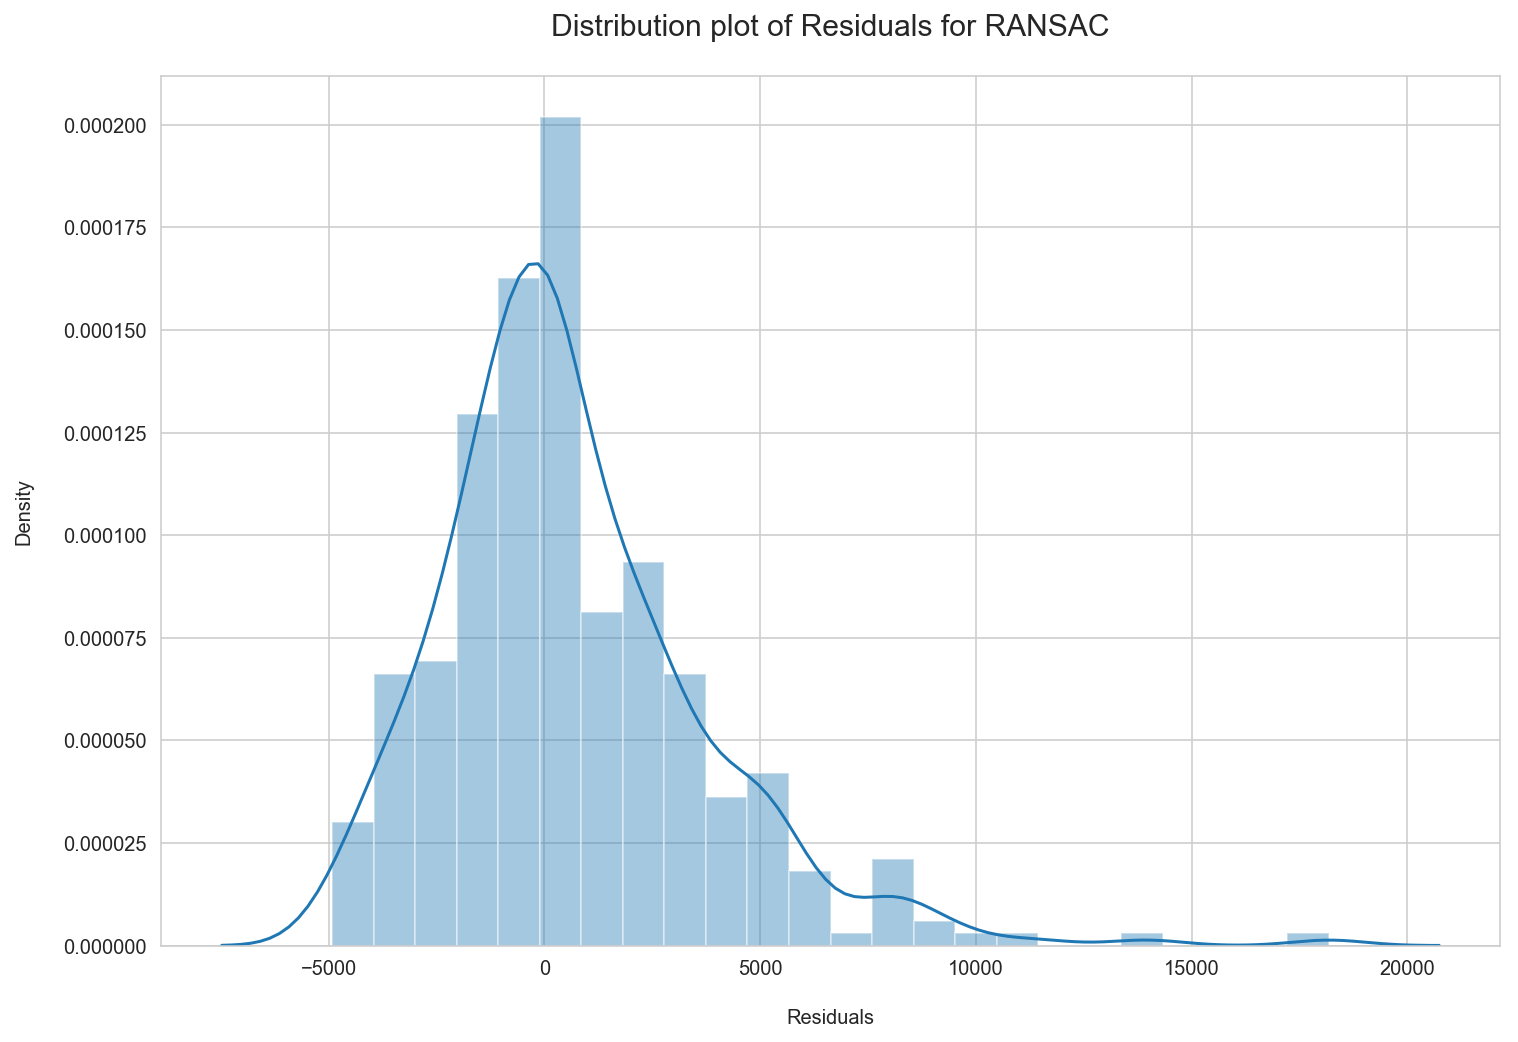

In [42]:
# Using RANSAC Regressor

ransac = RANSACRegressor()

ransac.fit(X_train, y_train)

show_predictions(ransac, 'RANSAC')
plot_residuals(ransac, 'RANSAC')

<div class="alert alert-warning">
    
Looking at the Random Forest, Lasso, Ridge and Robust Regression models, it seems that the results for the various linear models are somewhat similar. The best model seems to be the Random Forest Regressor, as such, for the rest of the features, we will be applying the Random Forest Regressor and only the Lasso from the Linear models as a comparison. 

</div>

In [43]:
# Creating a feature set based on the Company to predict salary

cvec = CountVectorizer()
companies = cvec.fit_transform(df['Company'])
print(companies.shape)
companies = pd.DataFrame(companies.todense(), columns=cvec.get_feature_names())

(1379, 826)


In [44]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = companies

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [0.27845317 0.13992864 0.28345917 0.15620242 0.0720472  0.07722763
 0.30281409 0.04764119 0.08953702 0.23908555]
Mean Cross-validated scores: 0.16863960812130716
Std Cross-validated scores: 0.09368620725317174
Train score: 0.6224430264784826
Test score: 0.19828705161105845
Train Mean Squared Error: 4651843.014489022
Train Mean Squared Error: 7427498.737702815


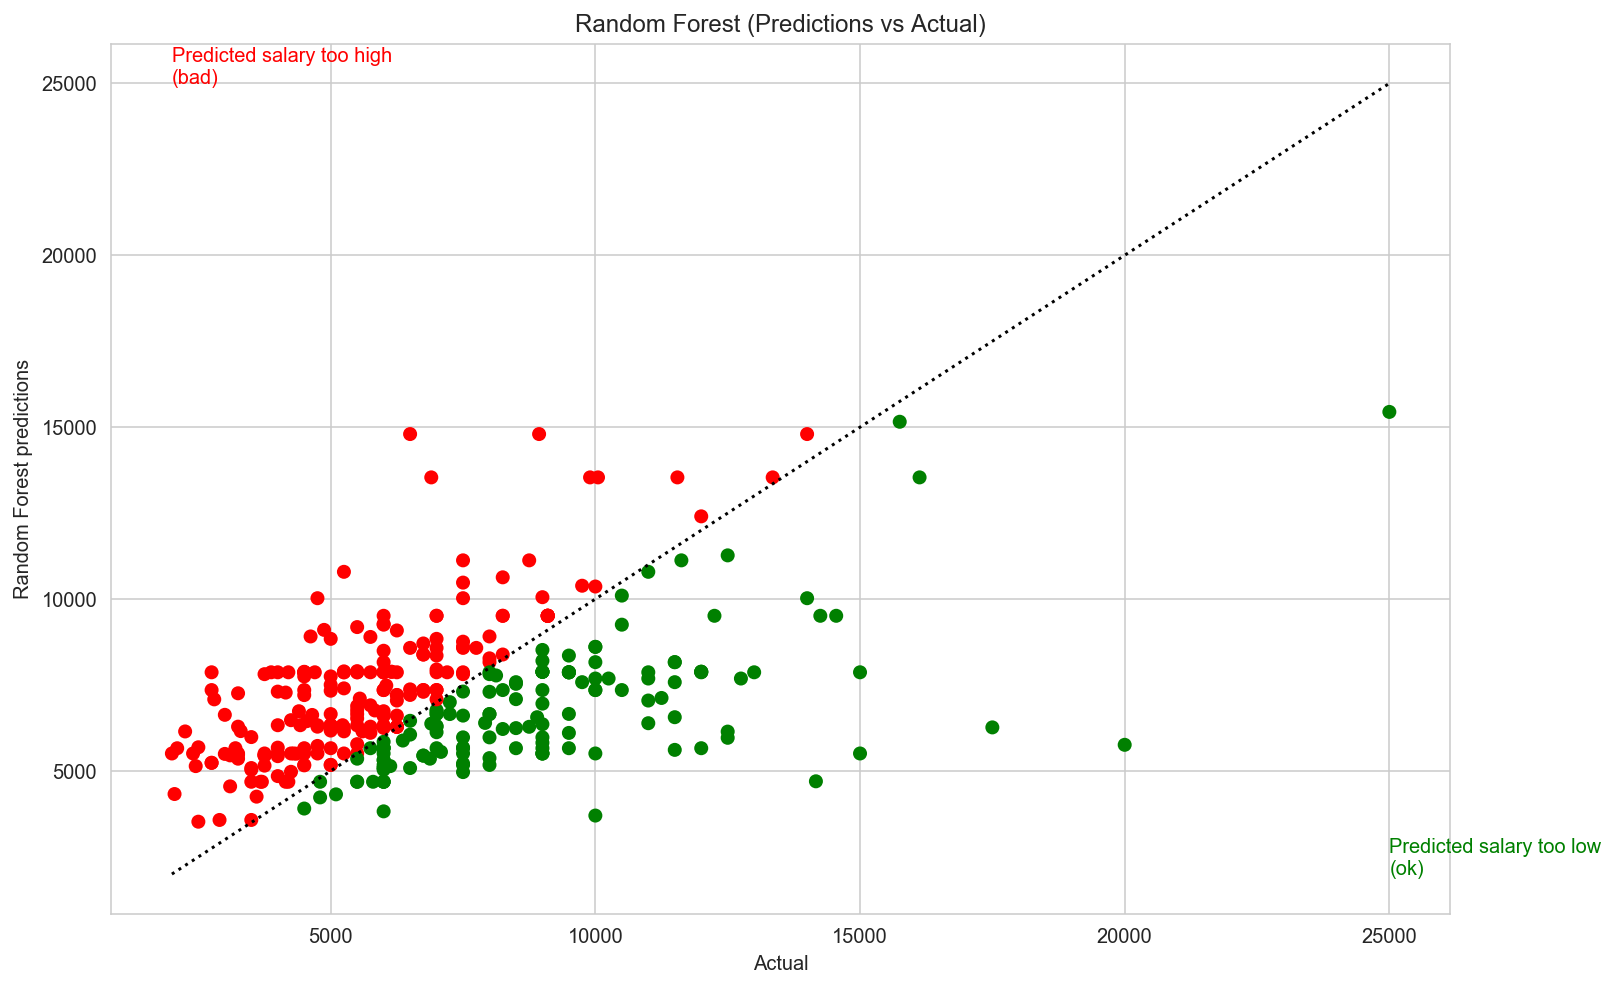

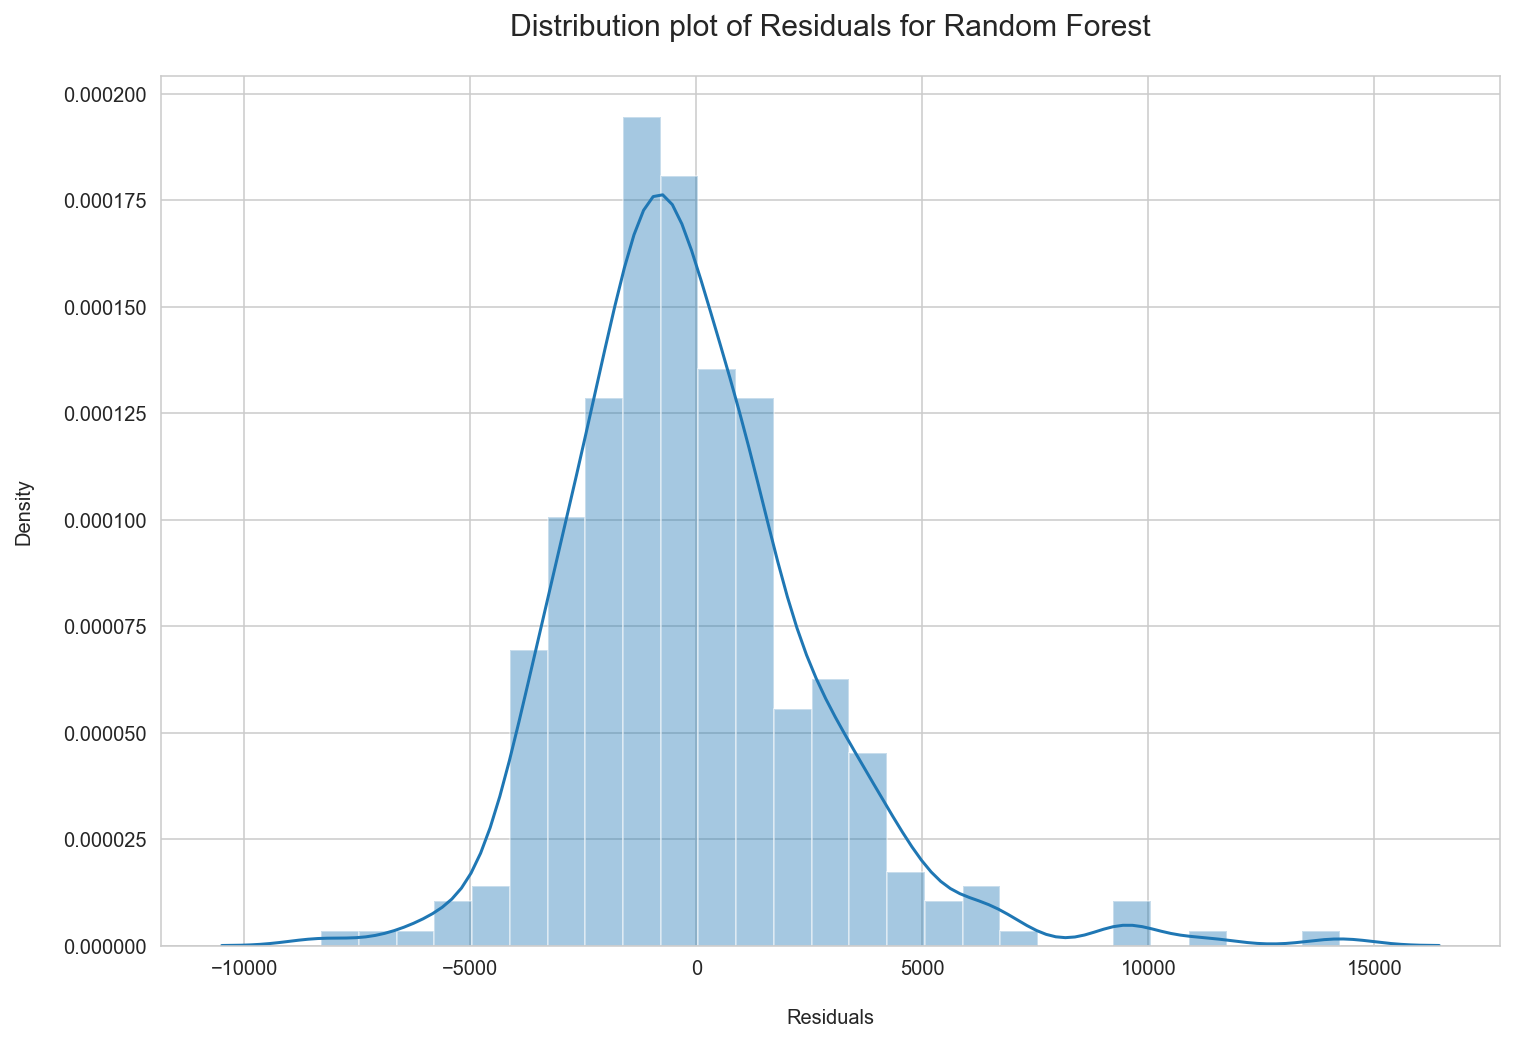

In [46]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=1000, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [47]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

7.130043769321658


.[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   57.5s finished


Cross-validated scores: [0.20340096 0.16521199 0.23704255 0.18146015 0.13230211 0.07323828
 0.33253992 0.04574629 0.14701847 0.20387958]
Mean Cross-validated scores: 0.17218403004796504
Std Cross-validated scores: 0.07748228101712028
Train score: 0.3675336162820927
Test score: 0.21473810613263566
Train Mean Squared Error: 7792557.243892635
Train Mean Squared Error: 7275087.345397827


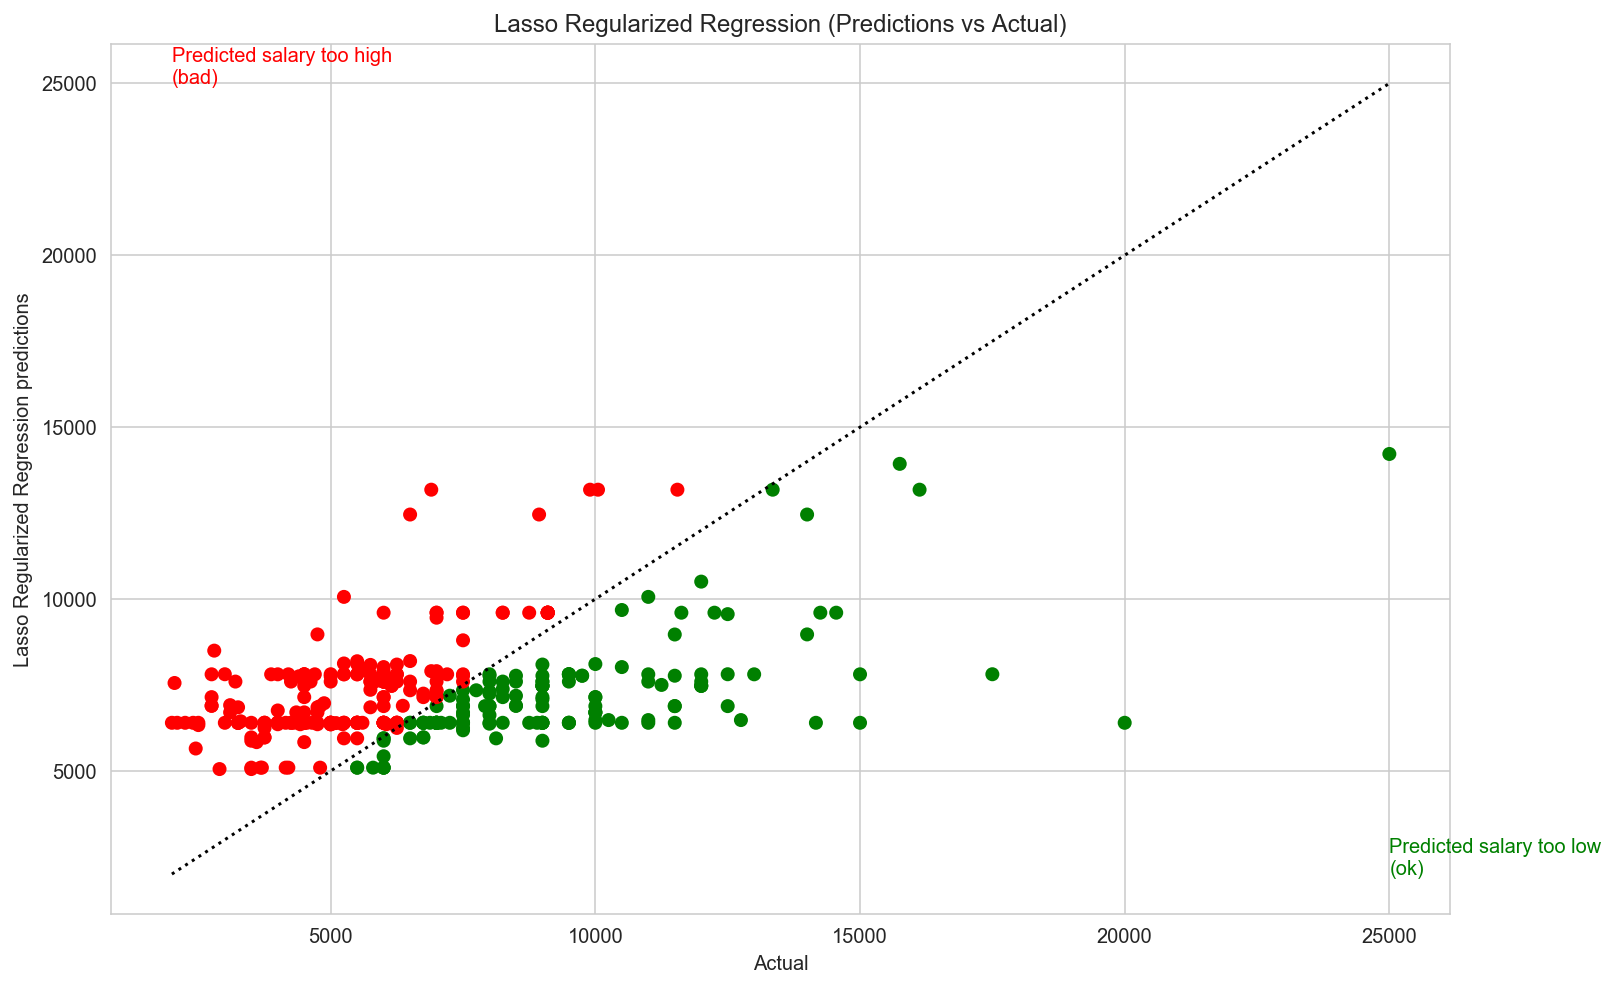

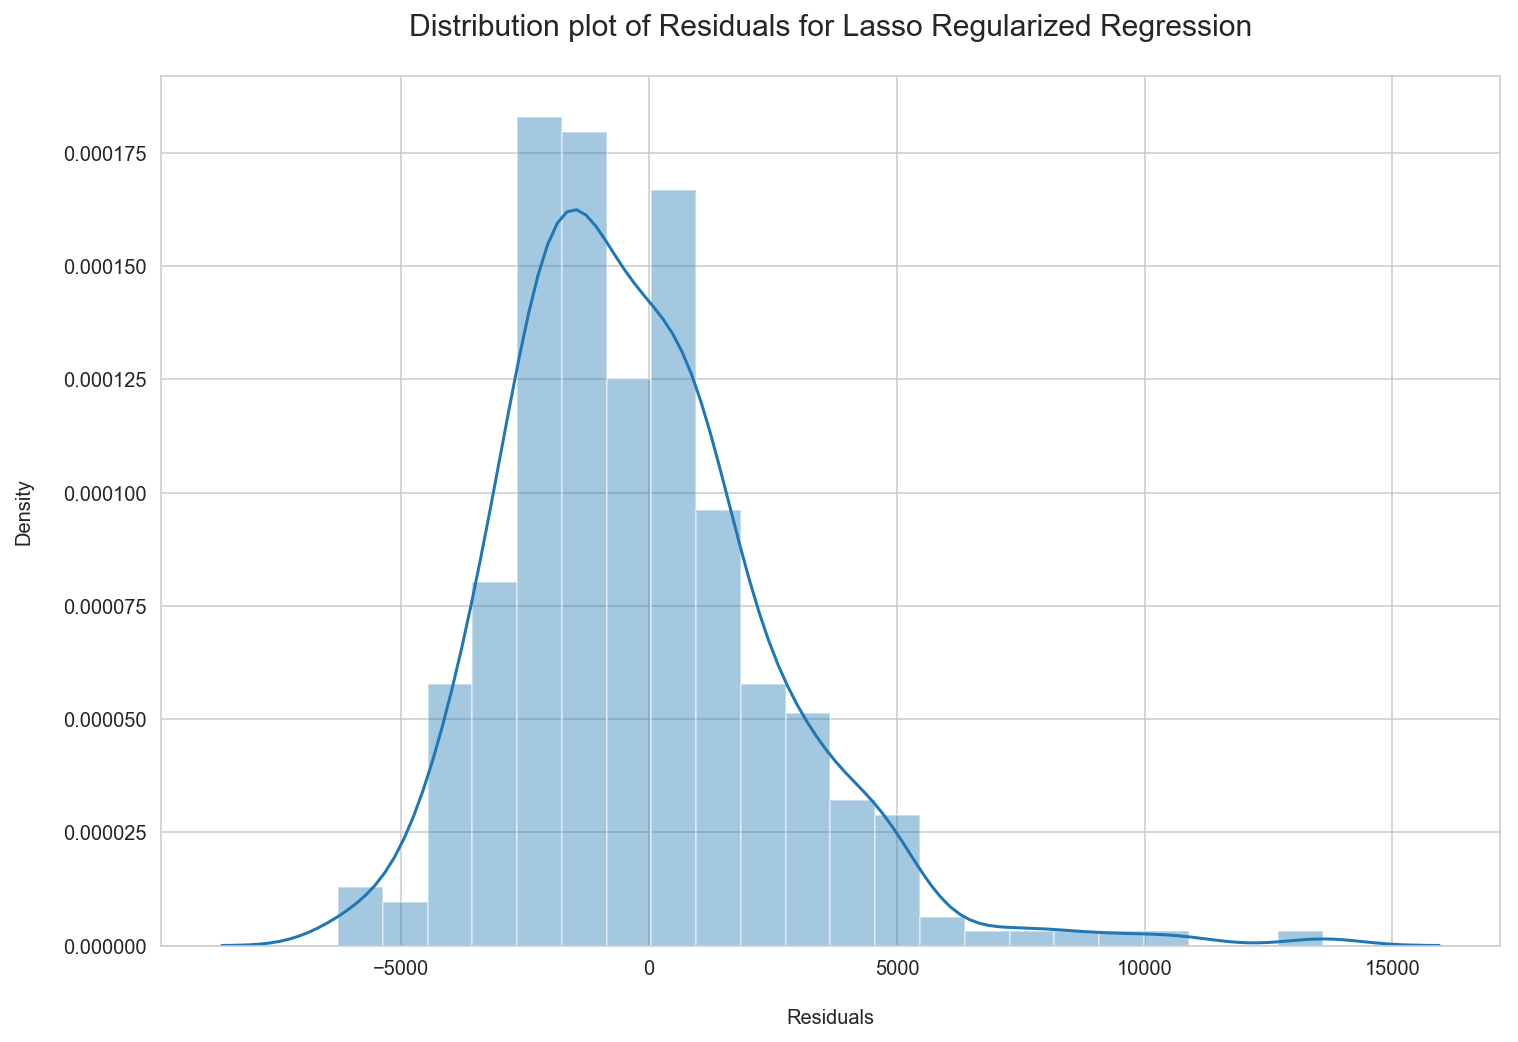

In [48]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

In [49]:
# Creating a feature set based on Employment to predict Salary

employment = cvec.fit_transform(df['Employment Type'])
print(employment.shape)
employment = pd.DataFrame(employment.todense(), columns=cvec.get_feature_names())
employment.head()

(1379, 10)


contract  flexi  freelance  full  internship  part  permanent  temporary  \
0         1      0          0     0           0     0          0          0   
1         0      0          0     1           0     0          0          0   
2         0      0          0     1           0     0          0          0   
3         1      0          0     1           0     0          0          0   
4         1      0          0     0           0     0          0          0   

   time  work  
0     0     0  
1     1     0  
2     1     0  
3     1     0  
4     0     0

In [50]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = employment

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [ 0.04638454  0.05812693  0.02095726  0.04657042 -0.00599505  0.0601494
  0.03464737  0.03501557 -0.04147631  0.04259402]
Mean Cross-validated scores: 0.029697415145828264
Std Cross-validated scores: 0.029889575450113805
Train score: 0.061759010739399045
Test score: 0.04584199277557488
Train Mean Squared Error: 11559976.633699907
Train Mean Squared Error: 8839831.523826497


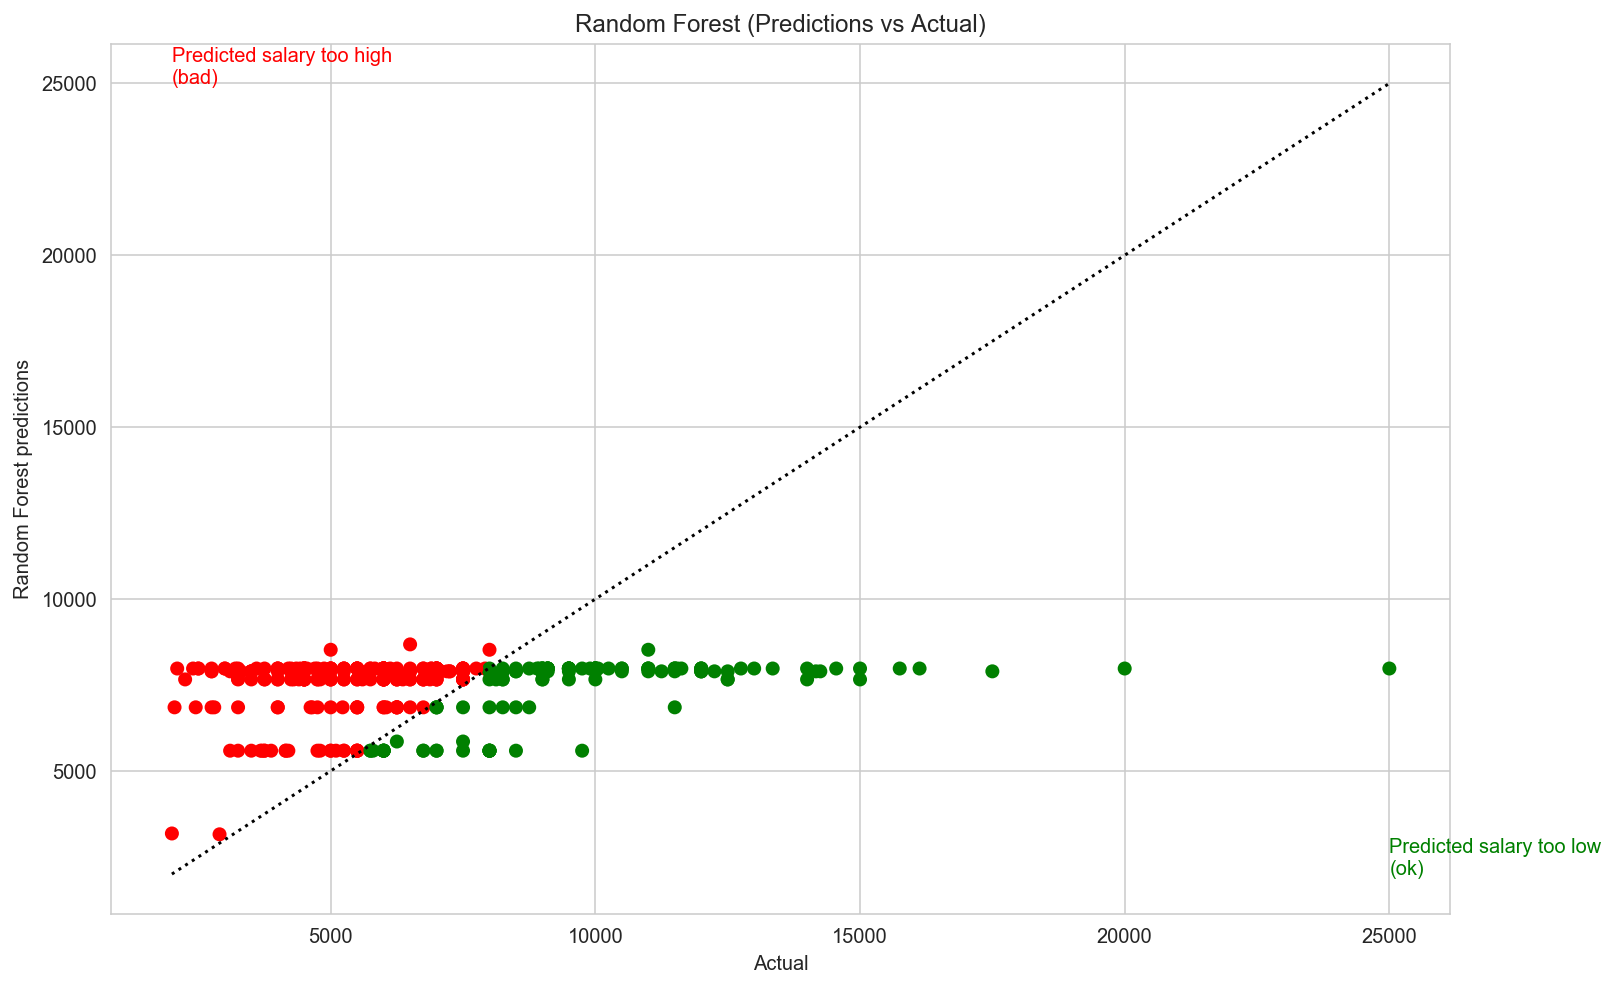

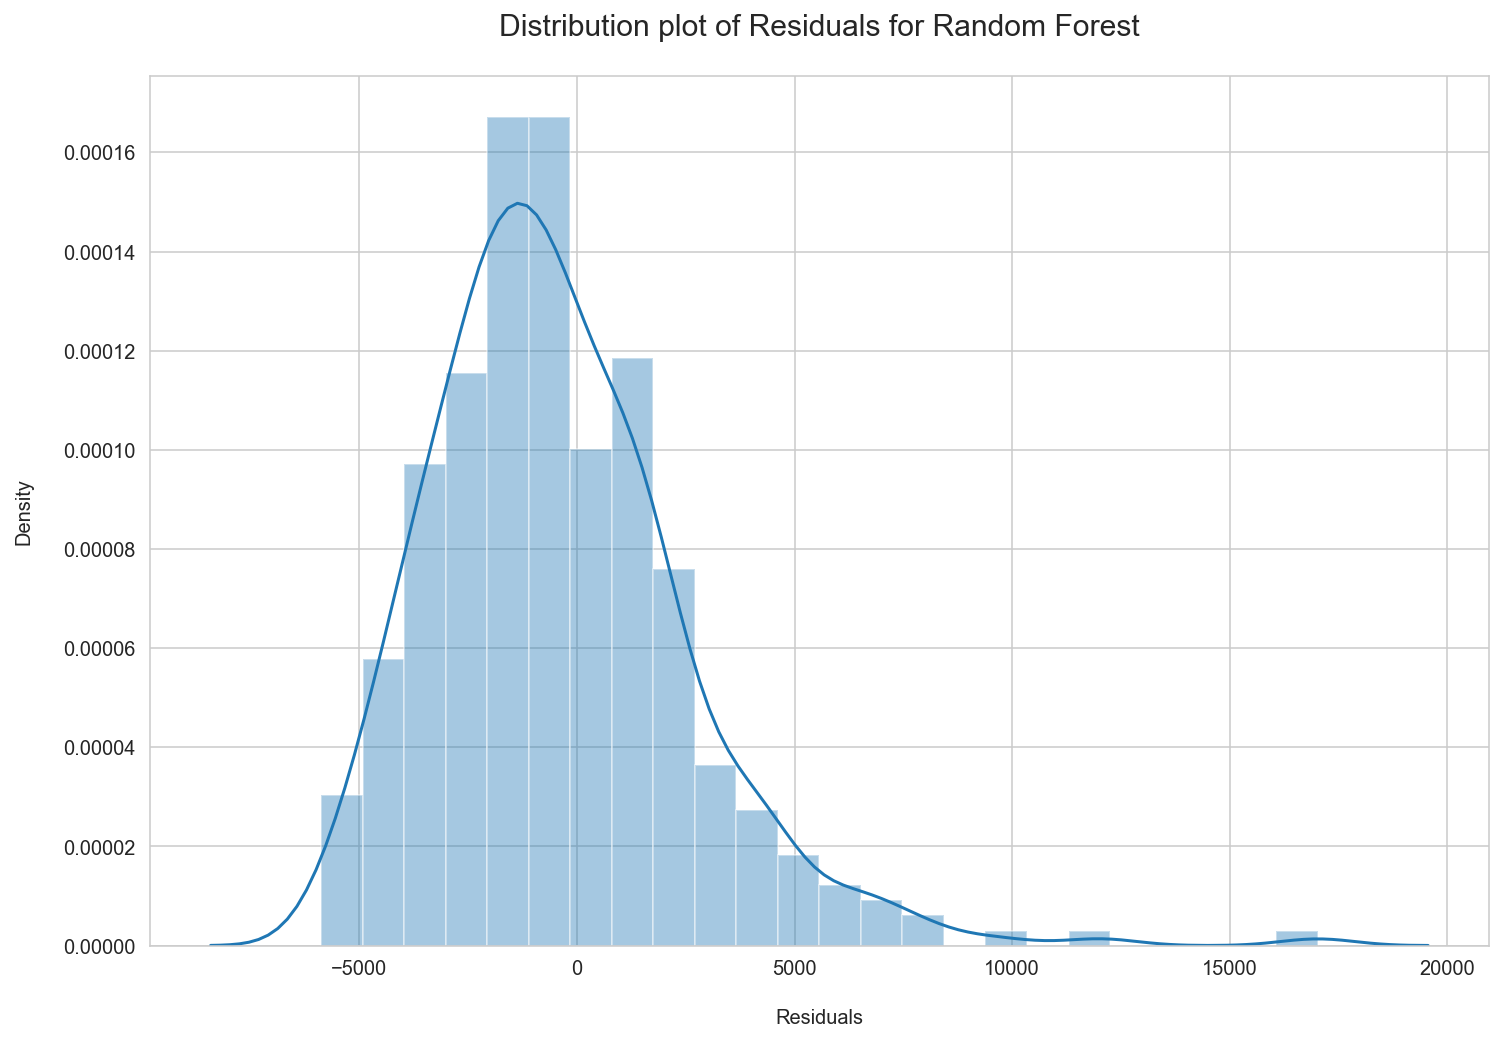

In [51]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=1000, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [52]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

3.6287464424052622


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


Cross-validated scores: [0.04532454 0.03595091 0.01256335 0.00861191 0.00344016 0.03522765
 0.02699876 0.02913402 0.01056929 0.04106366]
Mean Cross-validated scores: 0.024888424200916037
Std Cross-validated scores: 0.014187771054973123
Train score: 0.04264131111517399
Test score: 0.03856336980618569
Train Mean Squared Error: 11795523.964796899
Train Mean Squared Error: 8907264.590768961


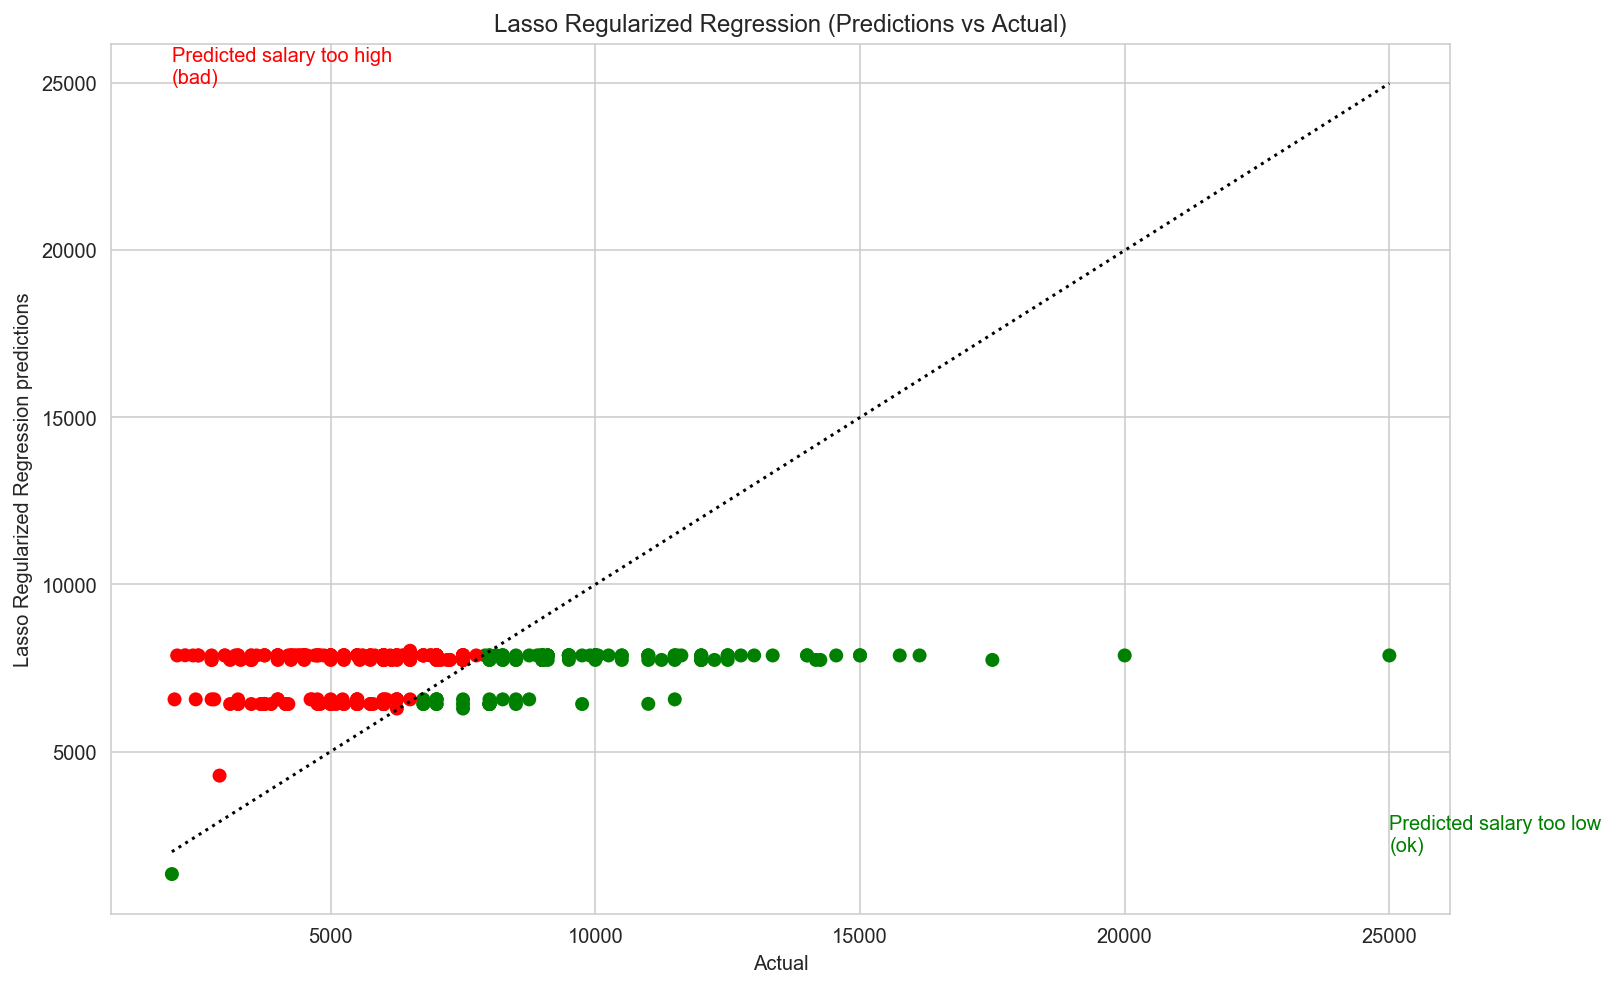

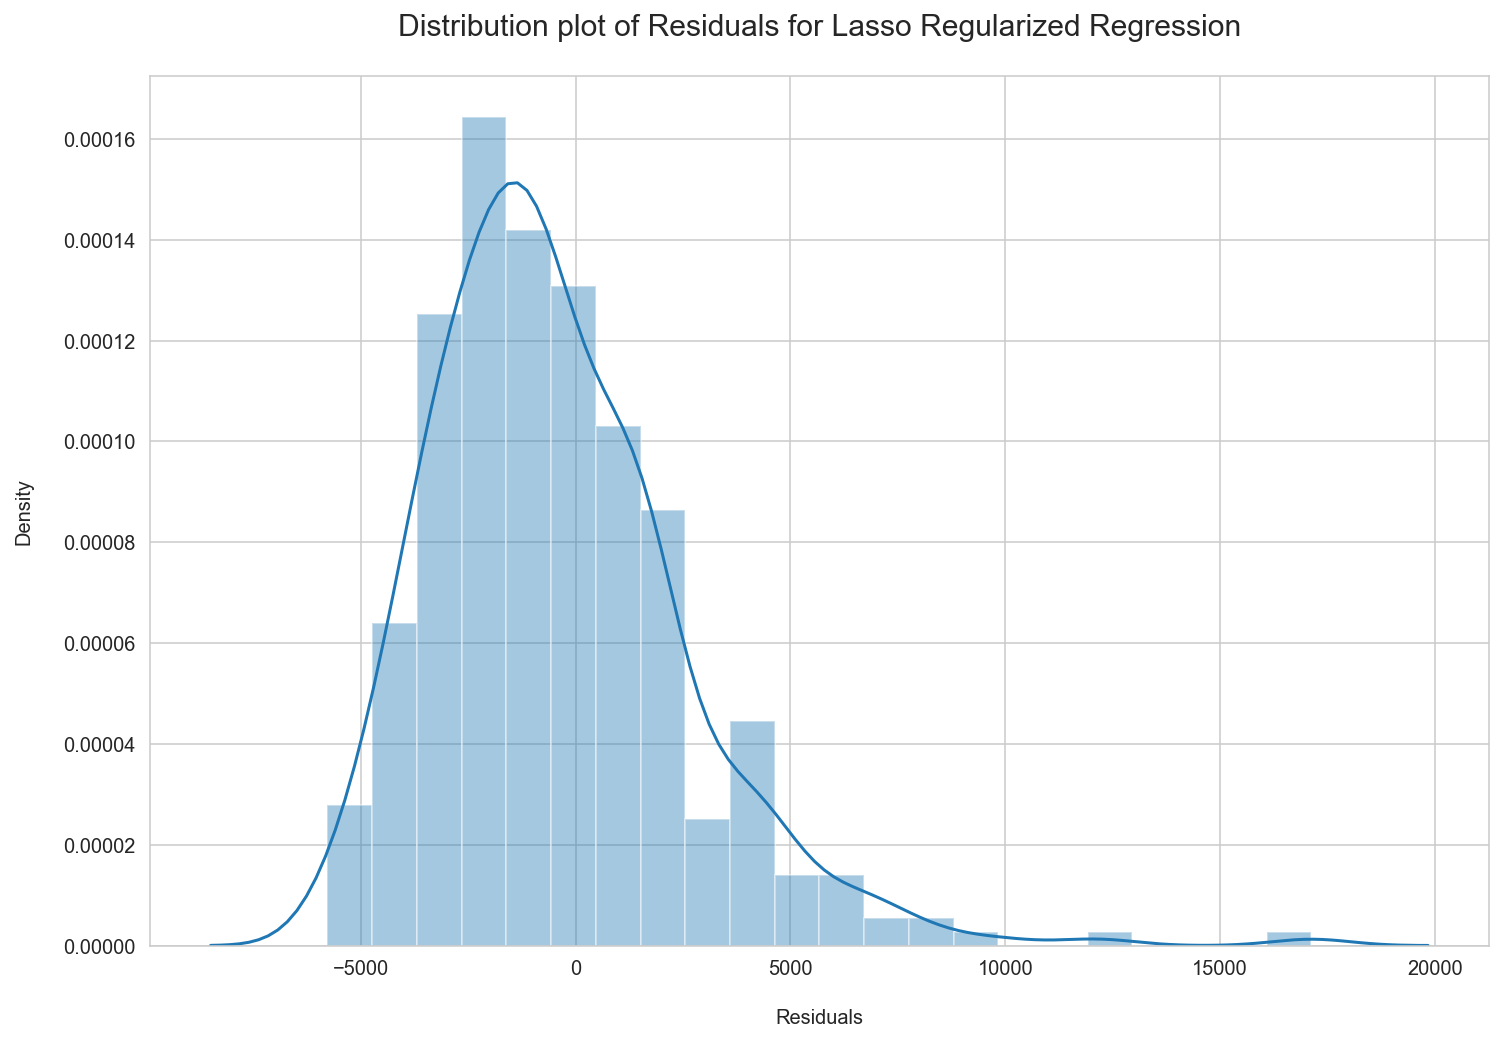

In [53]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

In [54]:
# Creating a feature set based on Seniority to predict Salary

seniority = cvec.fit_transform(df['Seniority'])
print(seniority.shape)
seniority = pd.DataFrame(seniority.todense(), columns=cvec.get_feature_names())
seniority.head()

(1379, 11)


entry  executive  fresh  junior  level  management  manager  middle  non  \
0      0          0      0       0      0           0        0       0    0   
1      0          1      0       0      0           0        0       0    0   
2      1          0      1       0      1           0        0       0    0   
3      0          1      0       0      0           0        0       0    0   
4      0          1      0       0      0           0        0       0    0   

   professional  senior  
0             1       0  
1             0       0  
2             0       0  
3             1       1  
4             0       1

In [55]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = seniority

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [0.16176383 0.0920533  0.24369088 0.24120543 0.2771331  0.16347526
 0.05896229 0.13864949 0.33353044 0.31895241]
Mean Cross-validated scores: 0.20294164412770382
Std Cross-validated scores: 0.08919298864082144
Train score: 0.26348665103937874
Test score: 0.11311959988345521
Train Mean Squared Error: 9074509.856047252
Train Mean Squared Error: 8216535.688485914


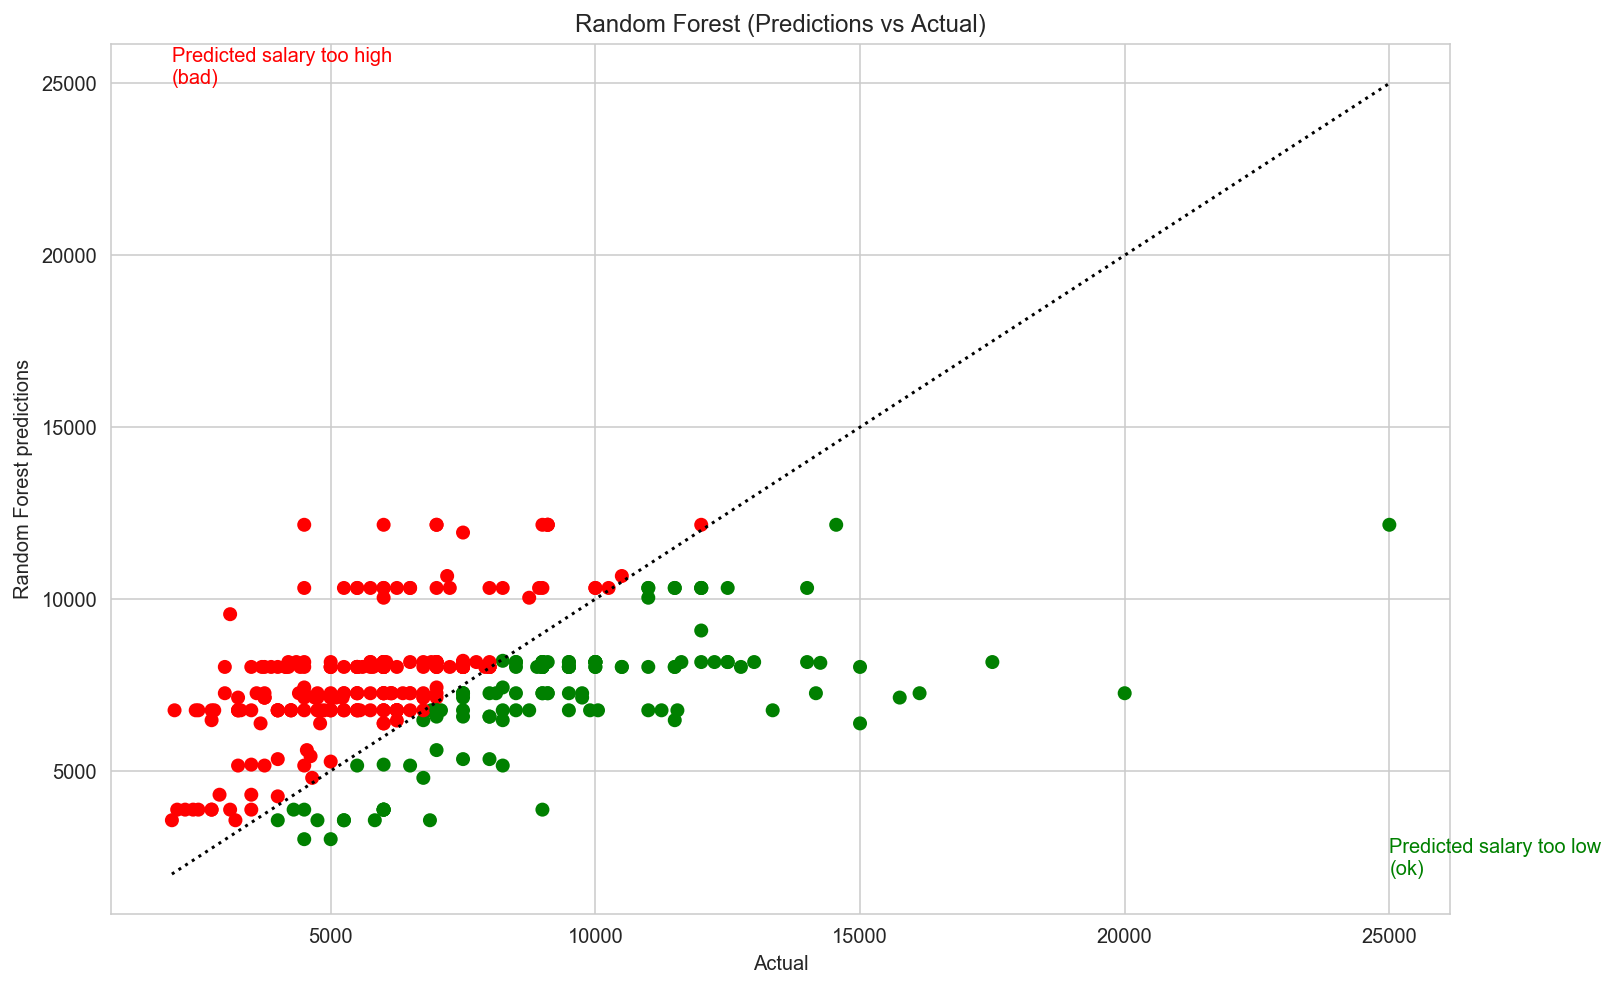

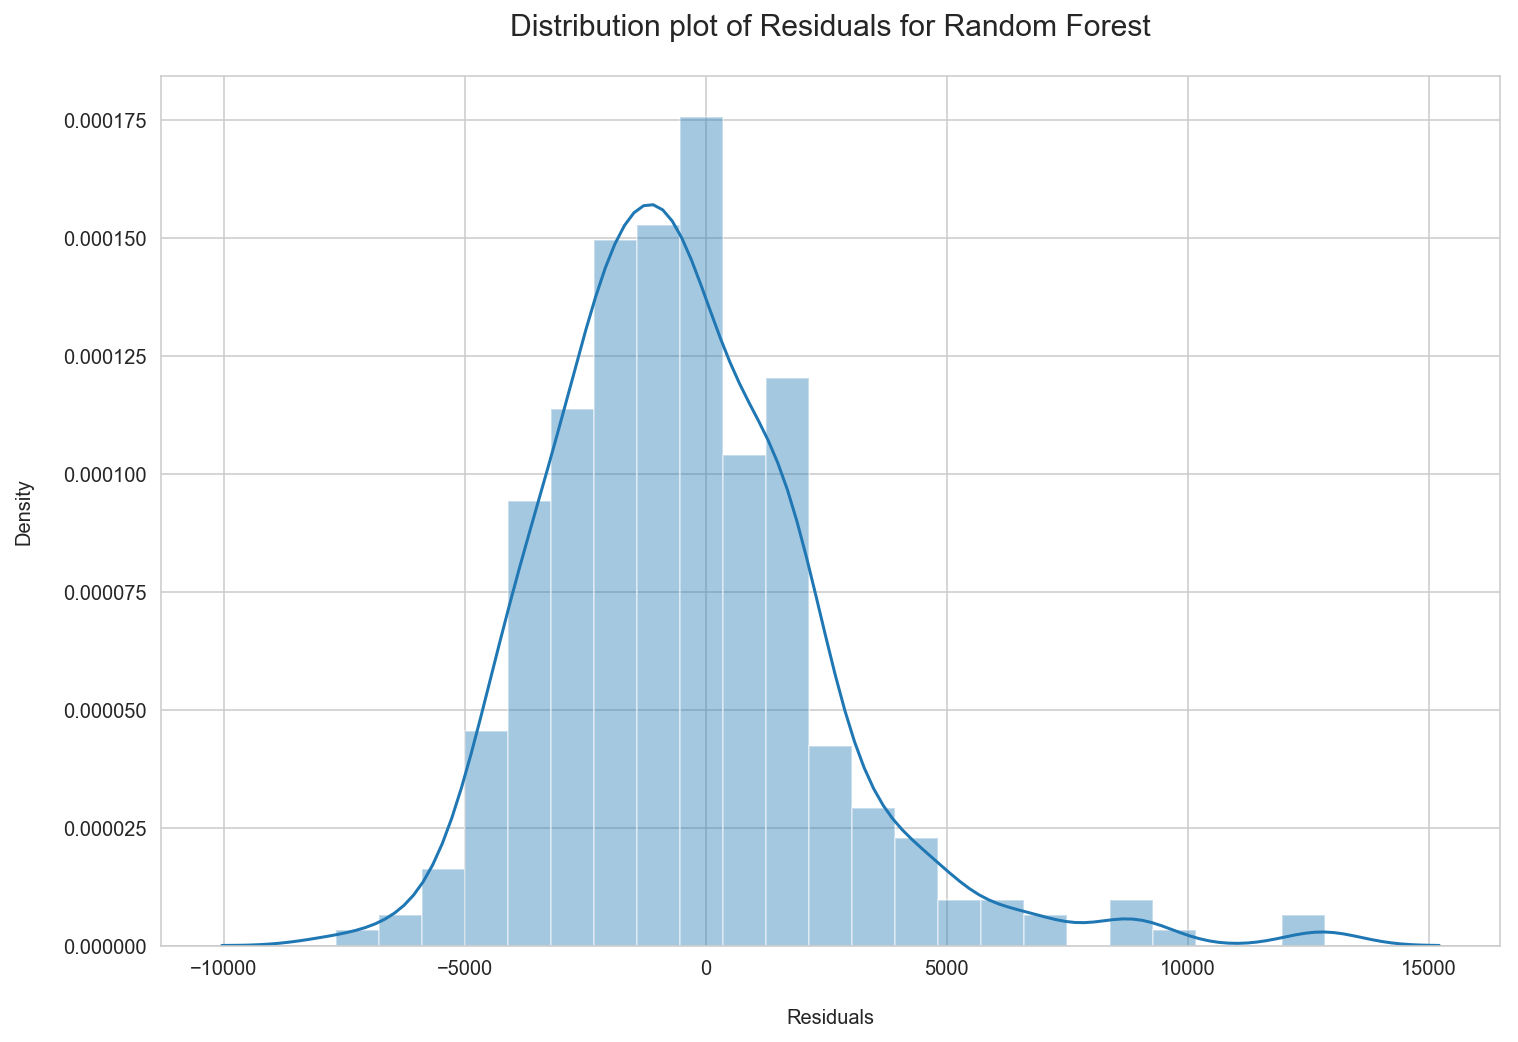

In [56]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=1000, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [57]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

24.65537096097562


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


Cross-validated scores: [0.16011425 0.09400724 0.17684382 0.20396744 0.22312132 0.14847902
 0.04890295 0.12902553 0.29383285 0.35946056]
Mean Cross-validated scores: 0.18377549838472299
Std Cross-validated scores: 0.08719742884508816
Train score: 0.1985656706957709
Test score: 0.13454958239330295
Train Mean Squared Error: 9874394.986199616
Train Mean Squared Error: 8017996.836942173


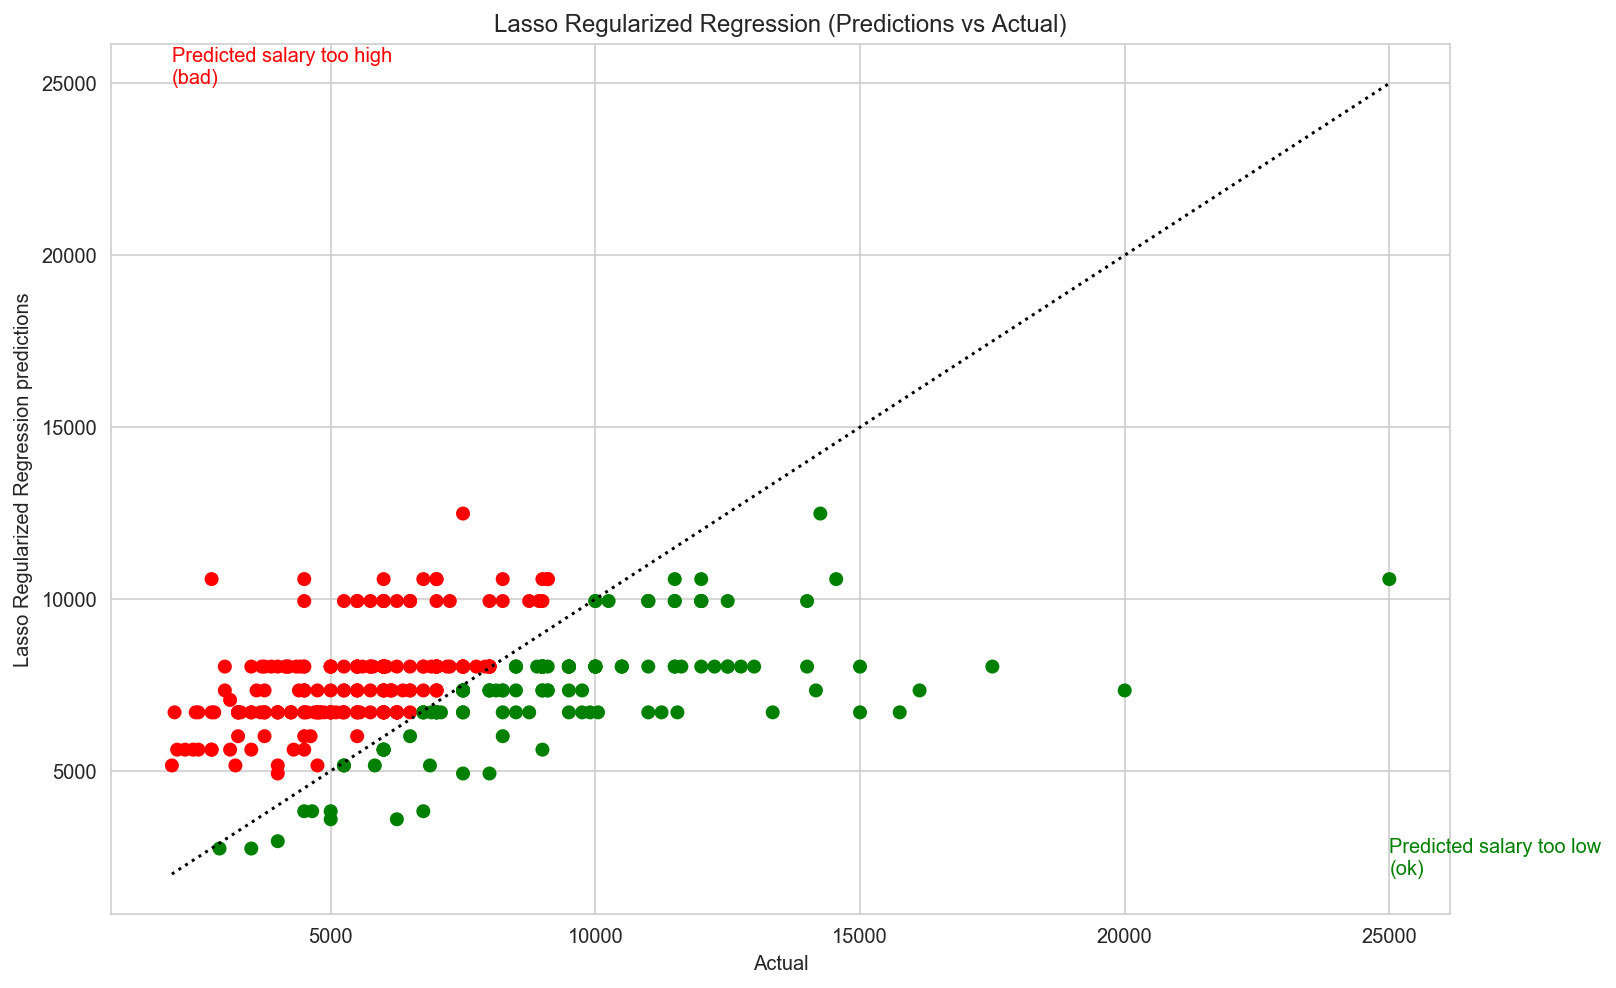

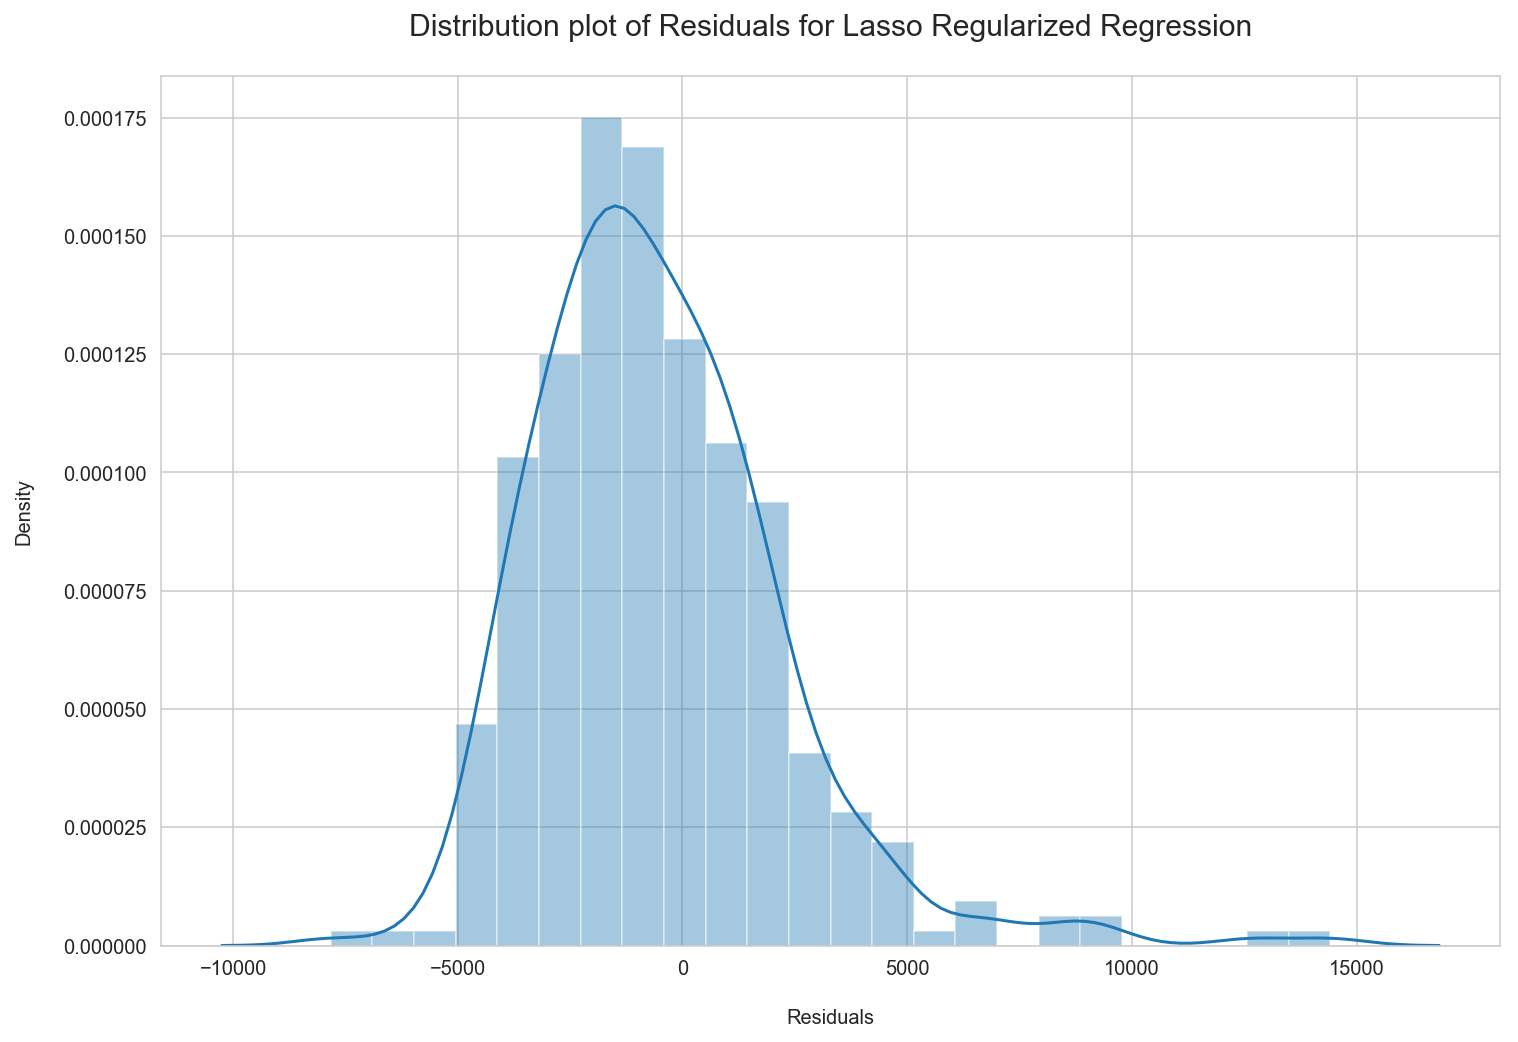

In [58]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

In [59]:
# Creating a feature set based on Summary to predict Salary

summaries = cvec.fit_transform(df['Summary'])
print(summaries.shape)
summaries = pd.DataFrame(summaries.todense(), columns=cvec.get_feature_names())

(1379, 9903)


In [60]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = summaries

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [0.25830637 0.28395221 0.29278209 0.25207569 0.21731856]
Mean Cross-validated scores: 0.26088698458299586
Std Cross-validated scores: 0.02657746770957668
Train score: 0.882031577891786
Test score: 0.2522412543195064
Train Mean Squared Error: 1453477.5379618634
Train Mean Squared Error: 6927638.066478701


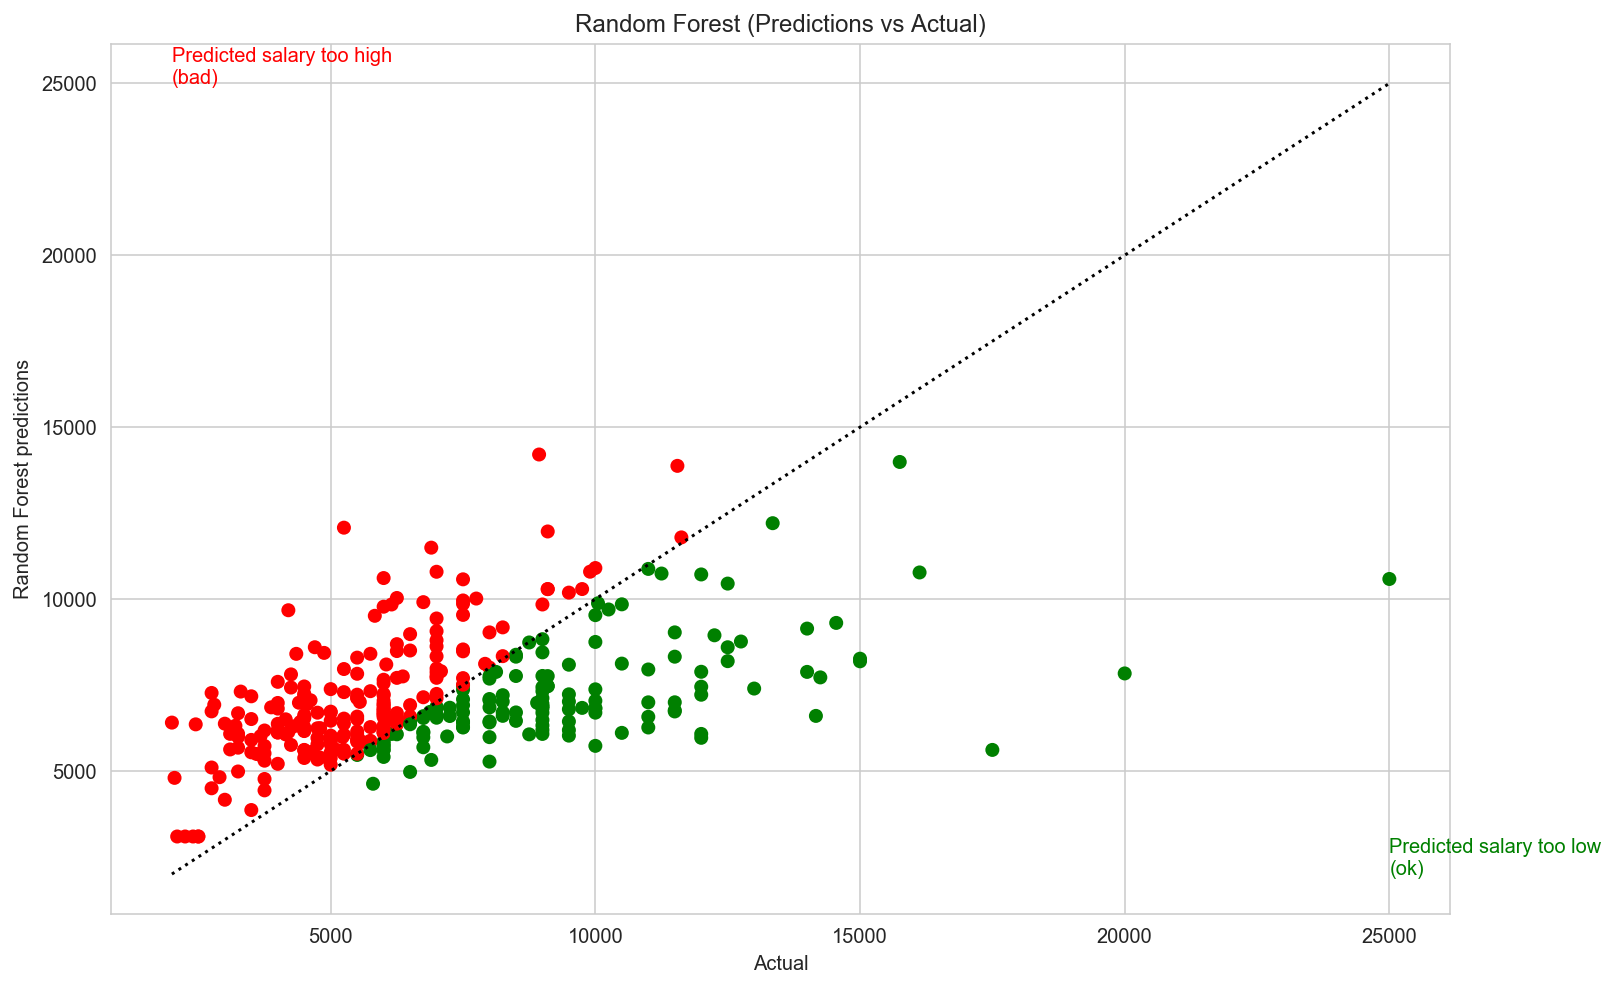

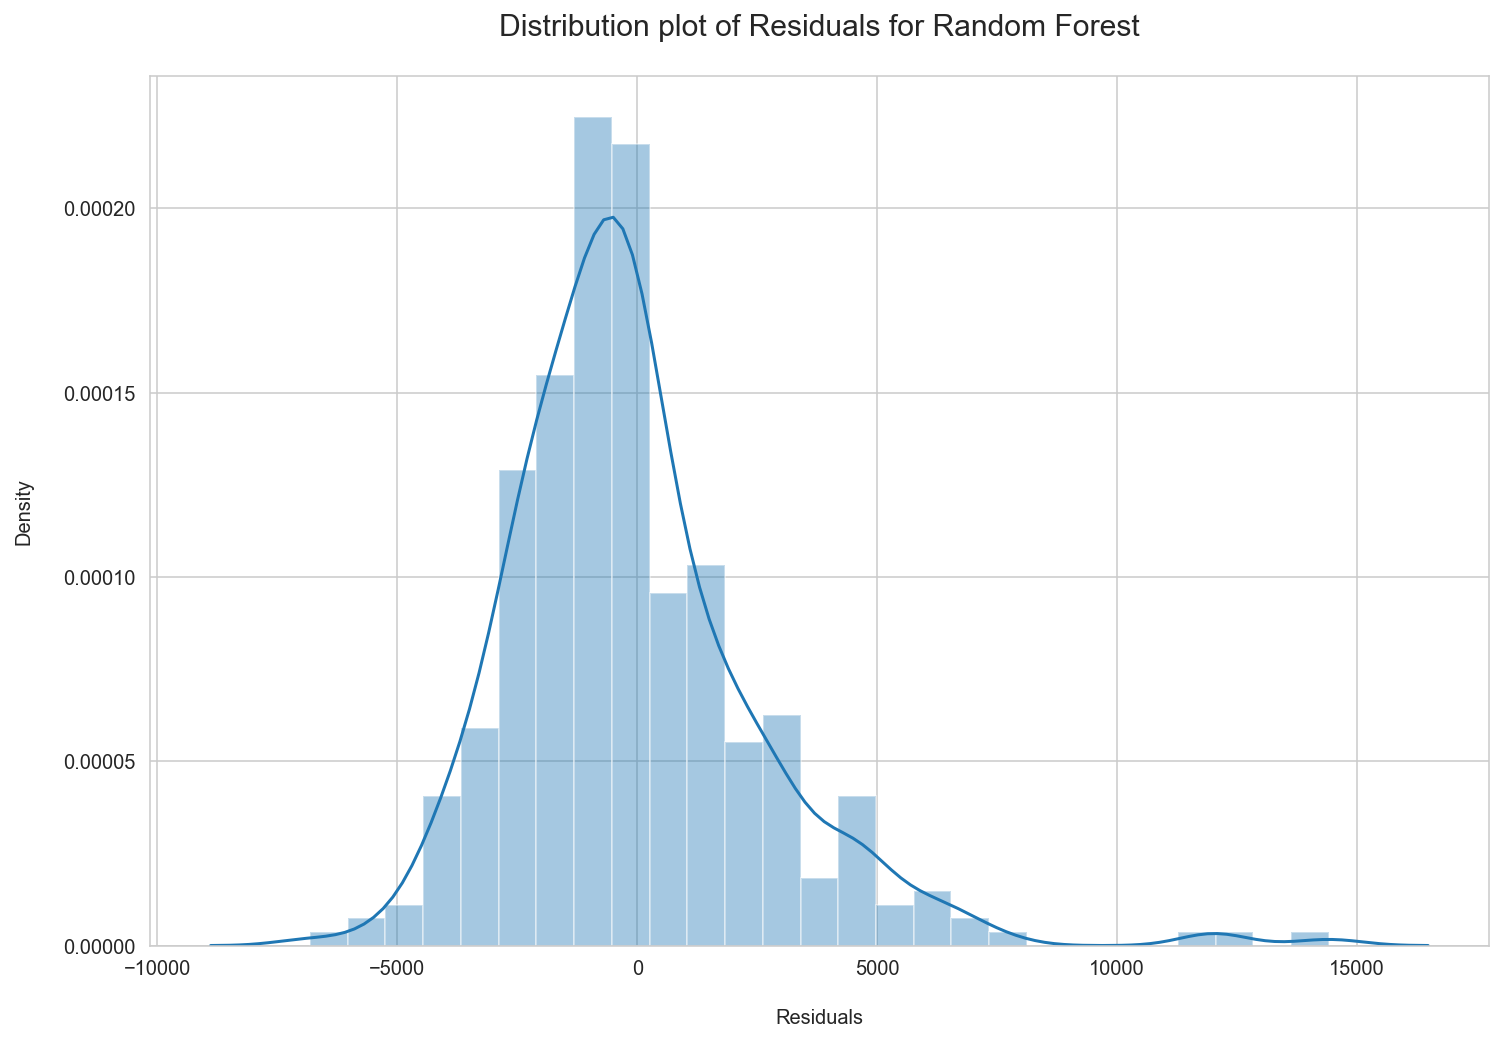

In [64]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=200, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [66]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=200, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

96.09424989301922


Cross-validated scores: [0.22959769 0.15080799 0.27037601 0.21723362 0.14435621]
Mean Cross-validated scores: 0.20247430262284022
Std Cross-validated scores: 0.04818978637709028
Train score: 0.36575687934861767
Test score: 0.19067829813269066
Train Mean Squared Error: 7814448.248091237
Train Mean Squared Error: 7497990.310739816


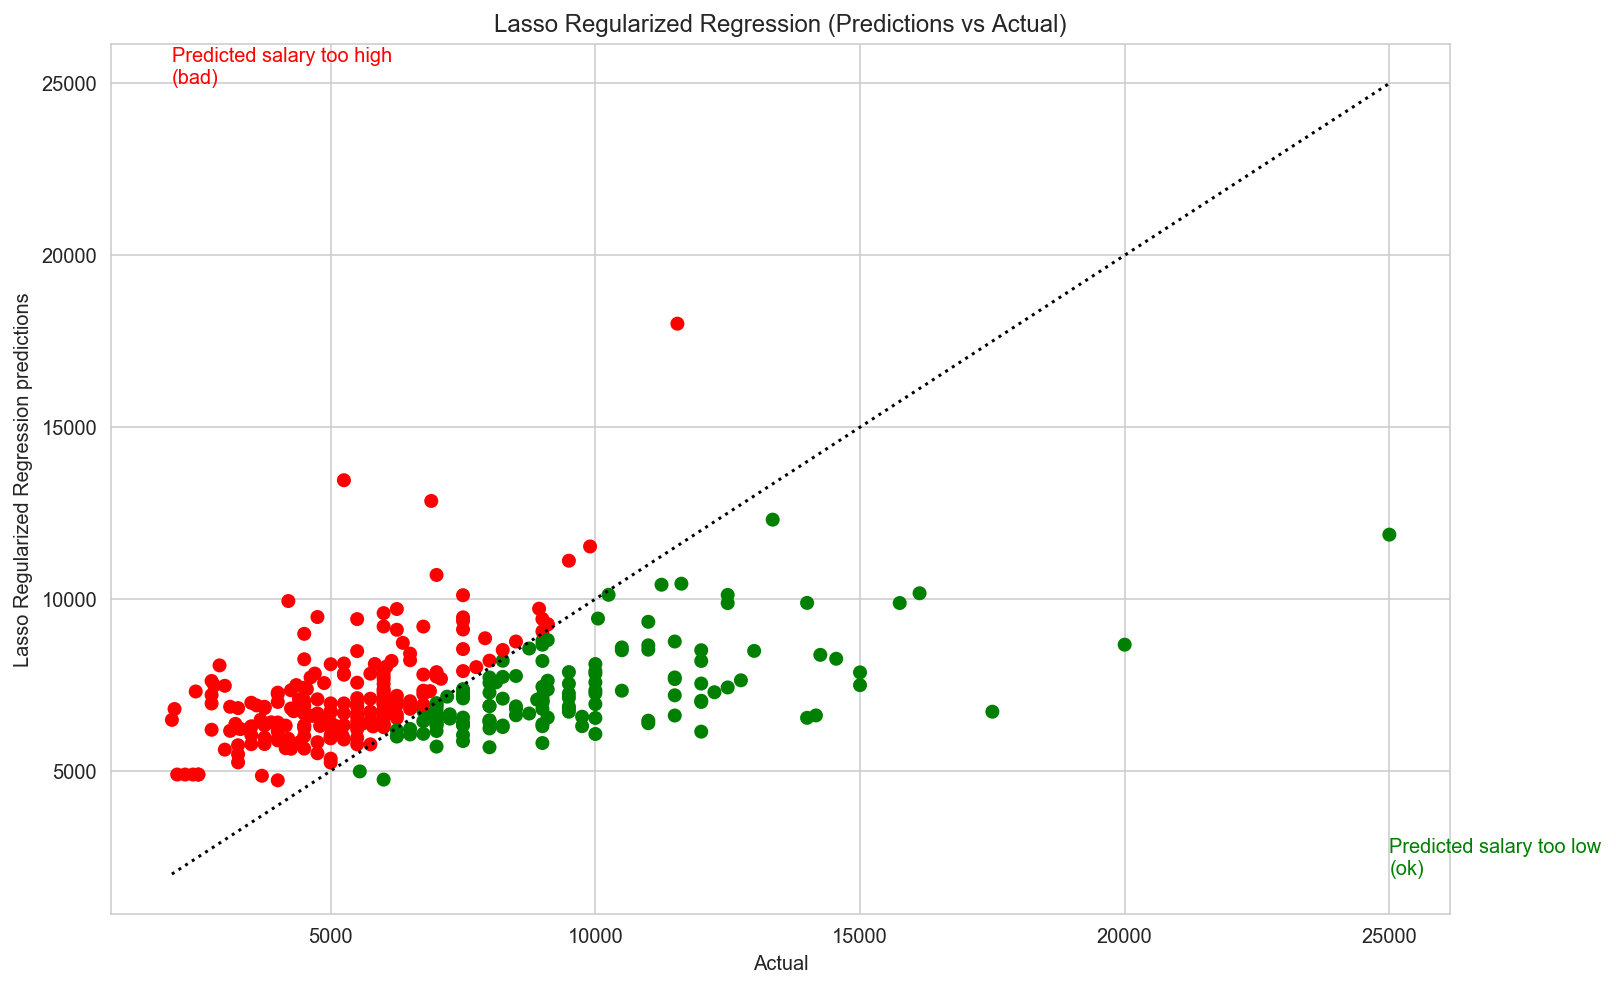

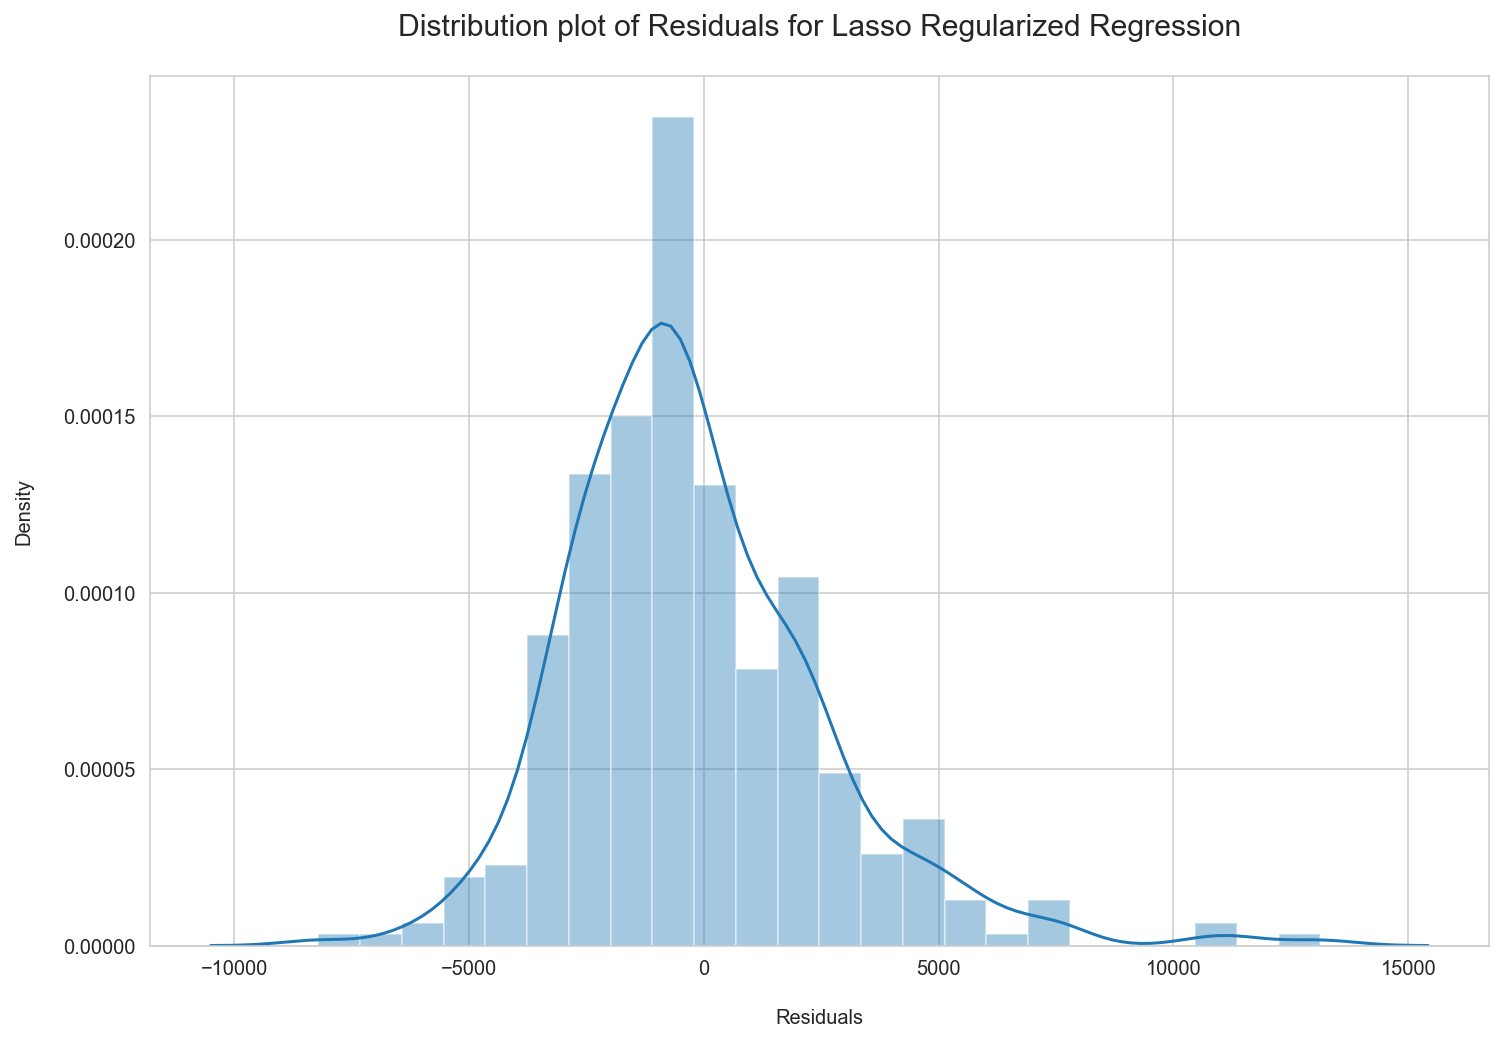

In [67]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

In [68]:
# Creating a feature set based on Requirements to predict Salary

requirements = cvec.fit_transform(df['Requirements'])
print(requirements.shape)
requirements = pd.DataFrame(requirements.todense(), columns=cvec.get_feature_names())

(1379, 8047)


In [69]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = requirements

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [0.3339557  0.33038415 0.3120908  0.281705   0.29789143]
Mean Cross-validated scores: 0.31120541614802805
Std Cross-validated scores: 0.01966580813025086
Train score: 0.8910435548936226
Test score: 0.23645291621475906
Train Mean Squared Error: 1342441.8395036545
Train Mean Squared Error: 7073909.698462554


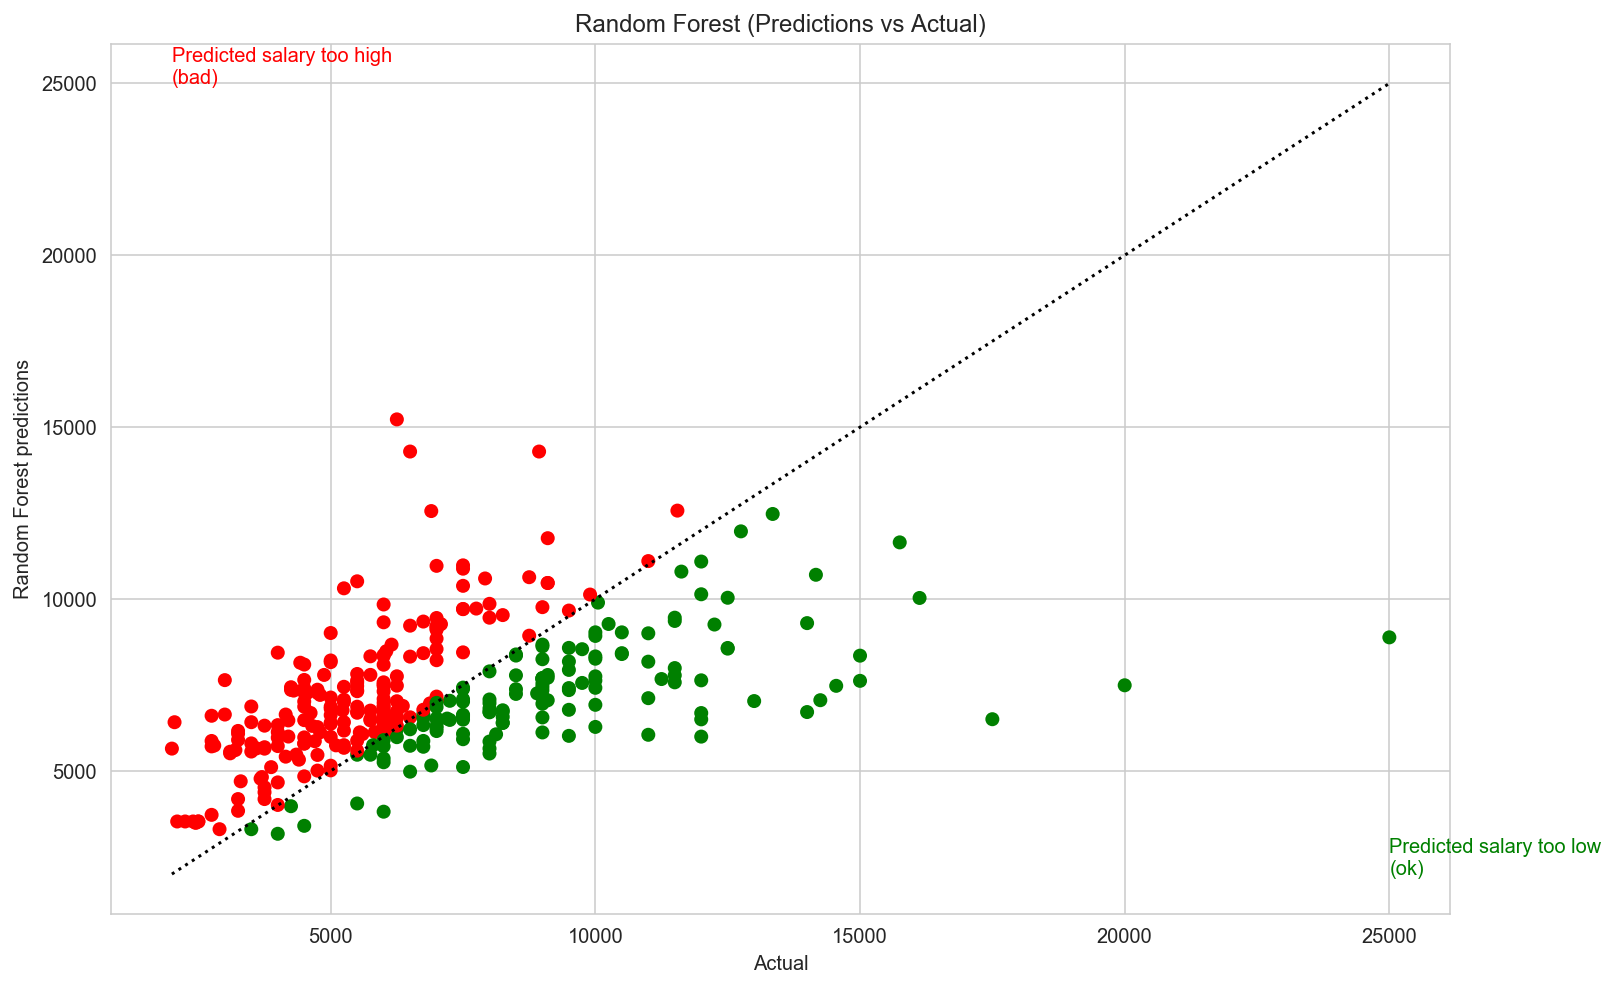

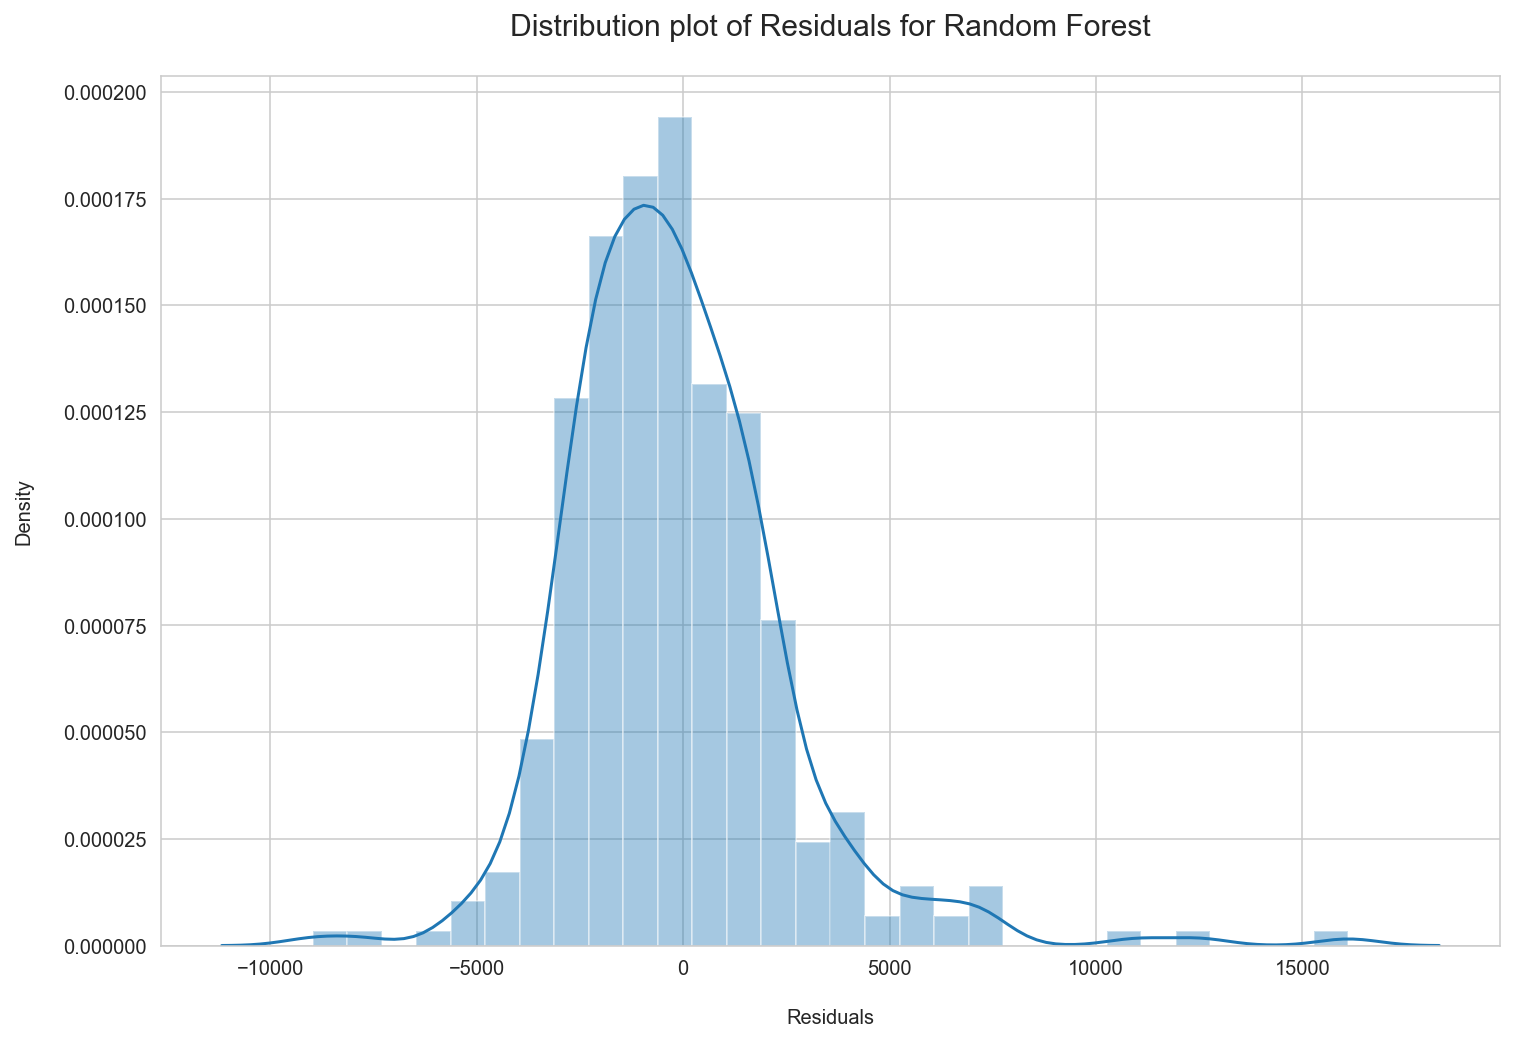

In [70]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=200, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [71]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=200, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

46.41547971321385


Cross-validated scores: [0.26028104 0.27271199 0.33172364 0.25265424 0.286563  ]
Mean Cross-validated scores: 0.28078678197896406
Std Cross-validated scores: 0.02794657696053537
Train score: 0.4643805658976766
Test score: 0.0707065434792844
Train Mean Squared Error: 6599315.3290584255
Train Mean Squared Error: 8609472.990468053


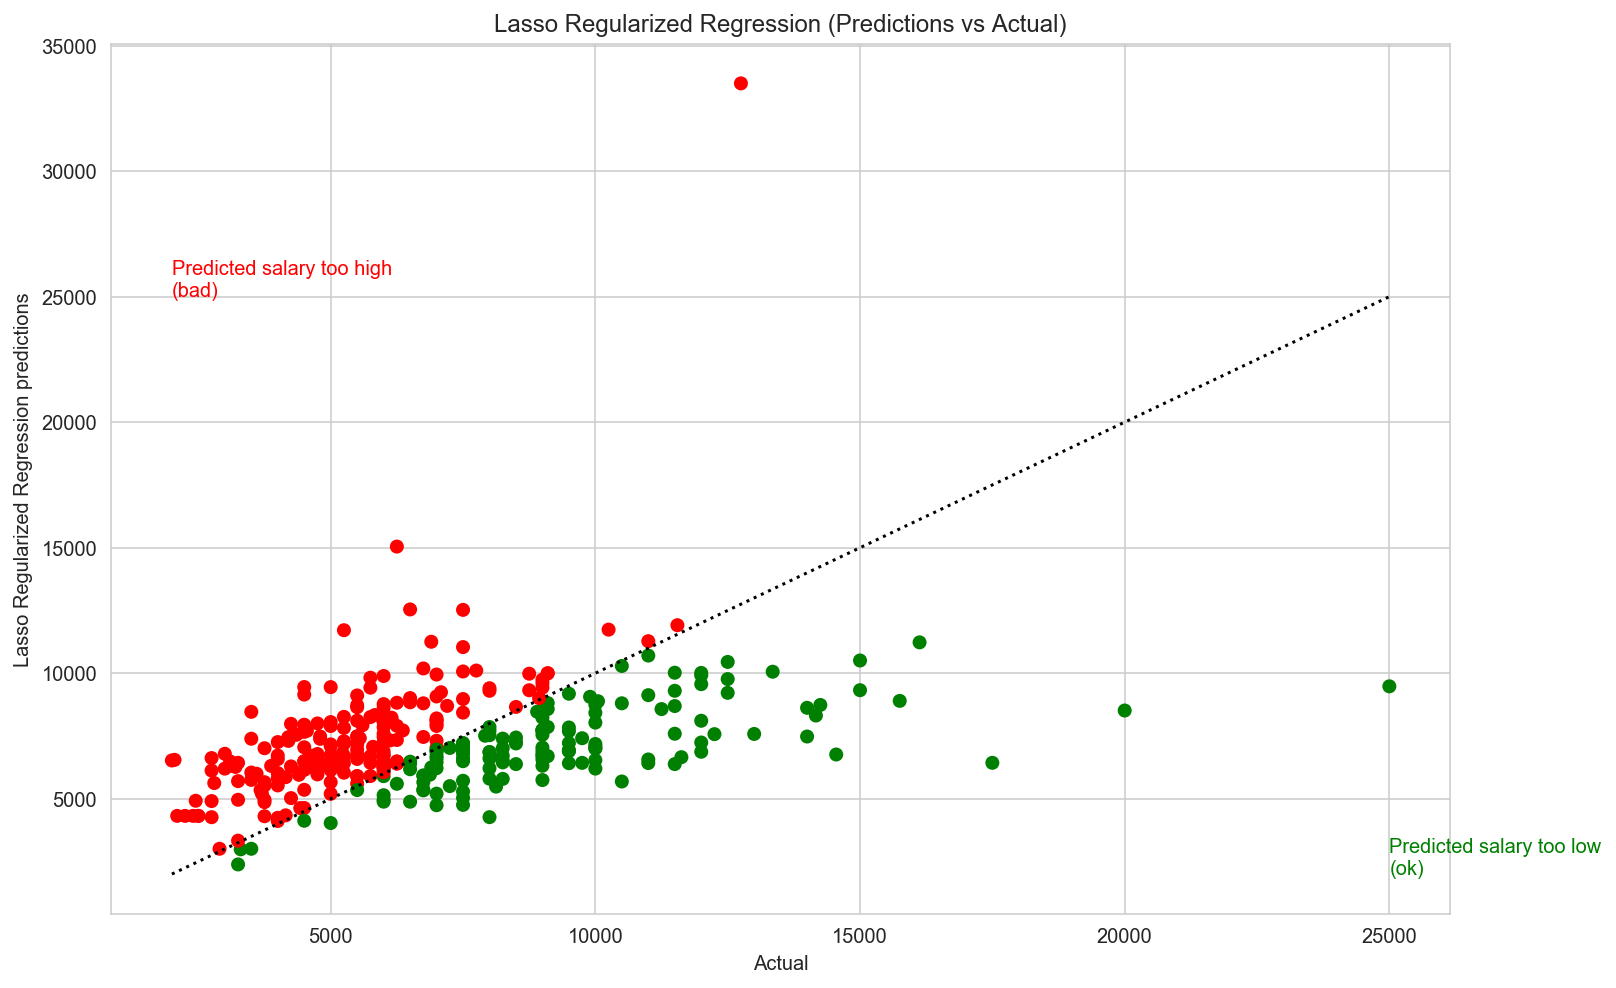

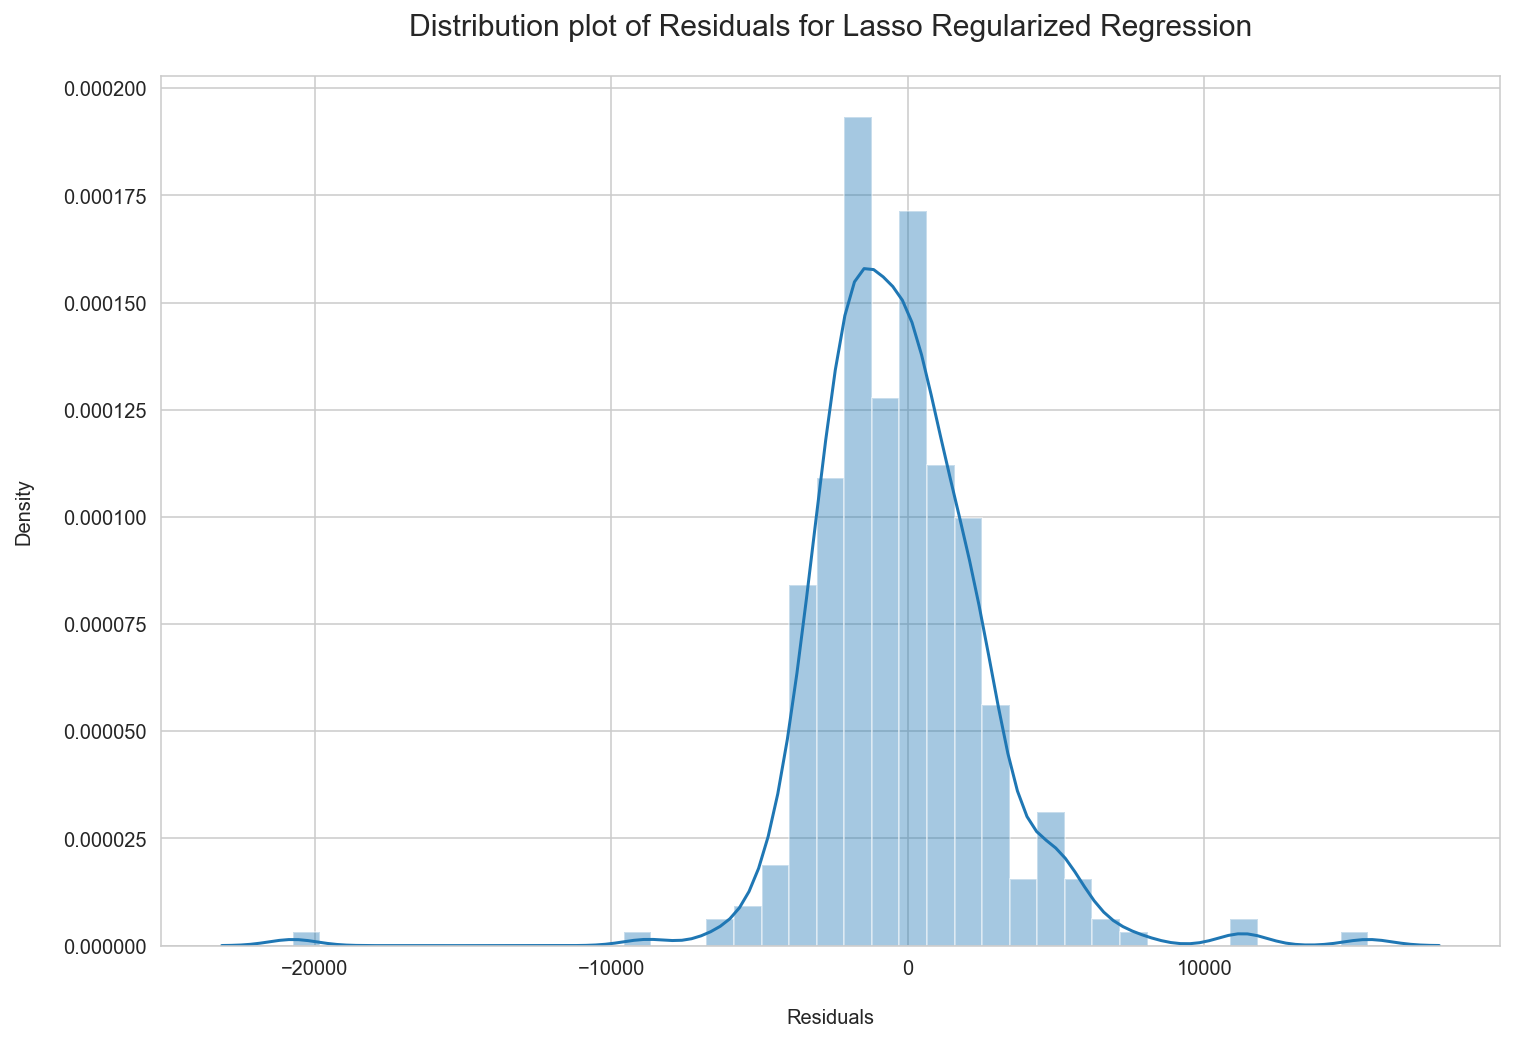

In [72]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

<div class="alert alert-warning">
    
Applying the various features by itself does not seem to yield very good results. The best using 'Titles', 'Summary' and 'Requirements'. To note is that Random Forest seems to be doing better than the Linear Models and in general the predictions tend to be below the actual (which is good), as can be seen from the residual distribution plots.
    
</div>

In [78]:
# Creating a feature set from 'Title', 'Summary' and 'Requirements'

jobsdata = pd.concat([titles, summaries, requirements], axis=1)
jobsdata.shape

(1379, 18793)

In [79]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = jobsdata

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [0.37655291 0.41015794 0.37257633 0.358721   0.29158832]
Mean Cross-validated scores: 0.3619192996751298
Std Cross-validated scores: 0.039016298001360535
Train score: 0.9106873156188078
Test score: 0.3196293846944076
Train Mean Squared Error: 1100412.9603773137
Train Mean Squared Error: 6303318.284315338


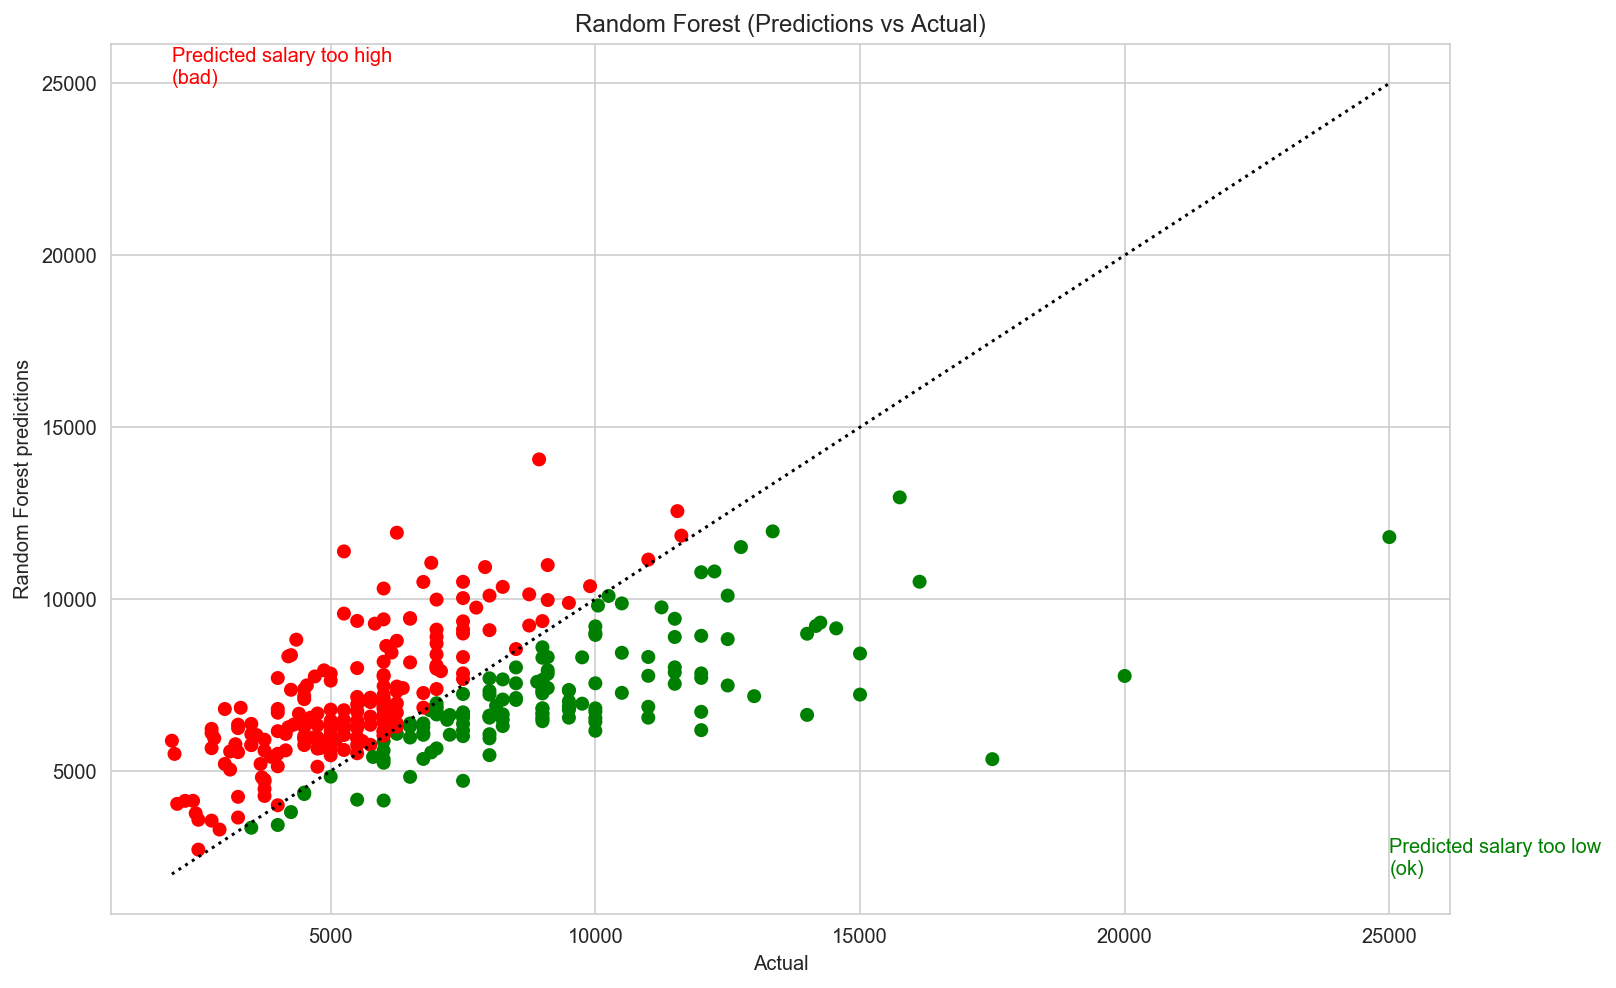

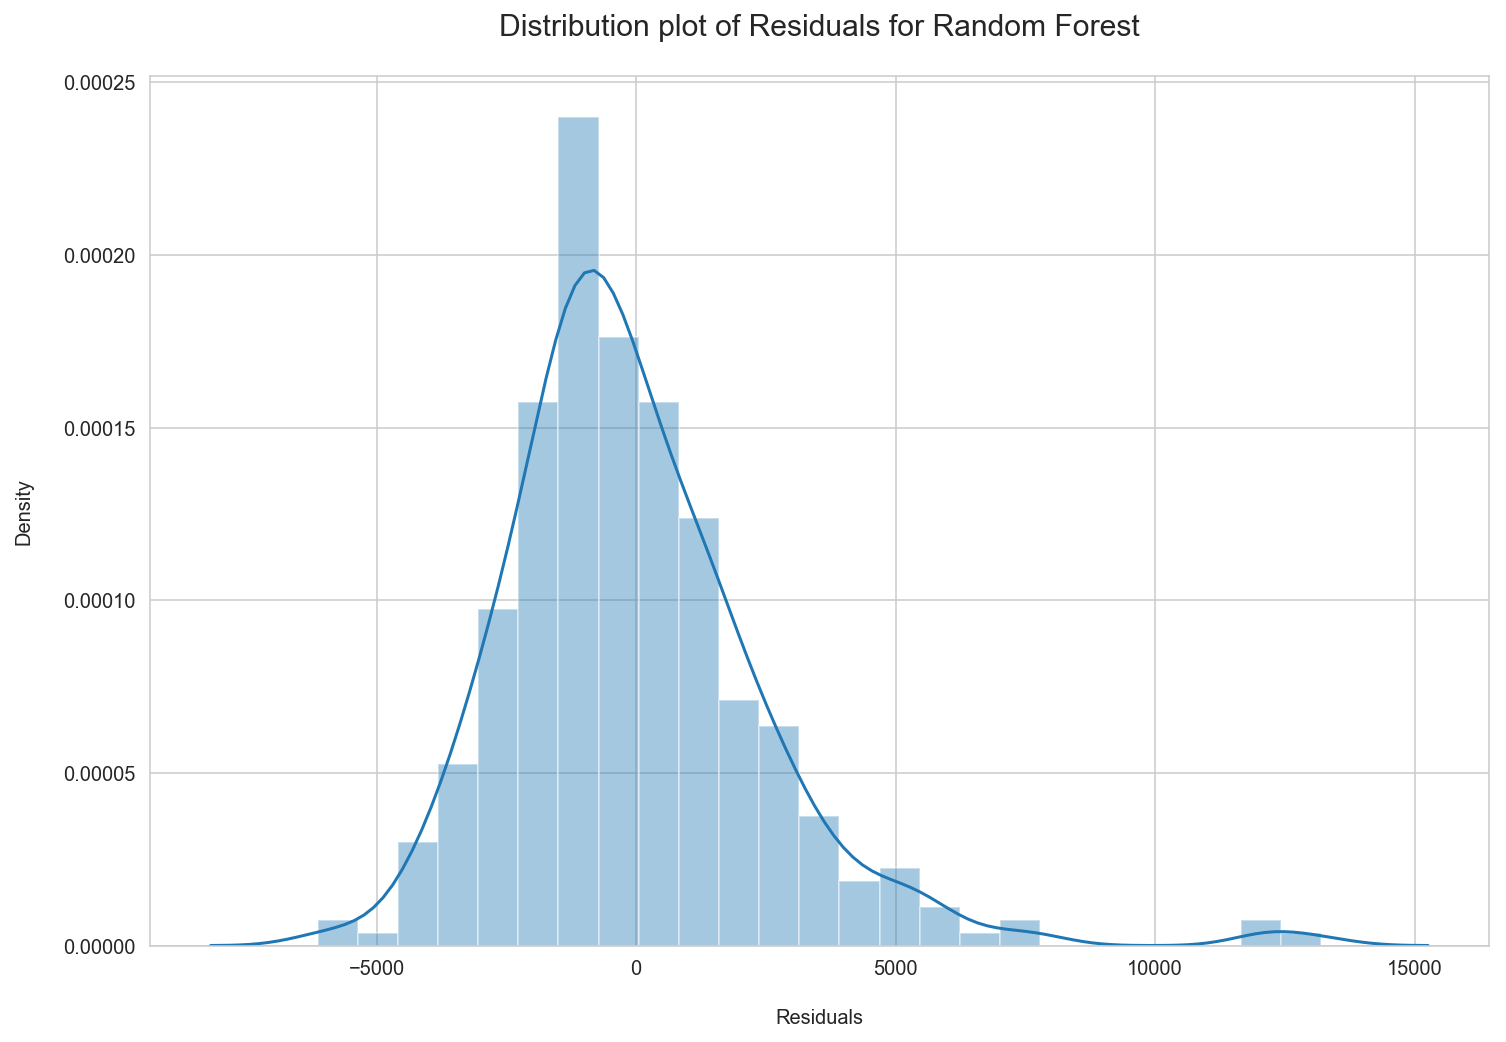

In [80]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=200, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [81]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=200, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

78.02704138676054


Cross-validated scores: [0.33298441 0.25460965 0.36971437 0.25360982 0.23402329]
Mean Cross-validated scores: 0.2889883088563145
Std Cross-validated scores: 0.05273904913849786
Train score: 0.509115709558045
Test score: 0.2686431567444252
Train Mean Squared Error: 6048137.9435696425
Train Mean Squared Error: 6775682.045558971


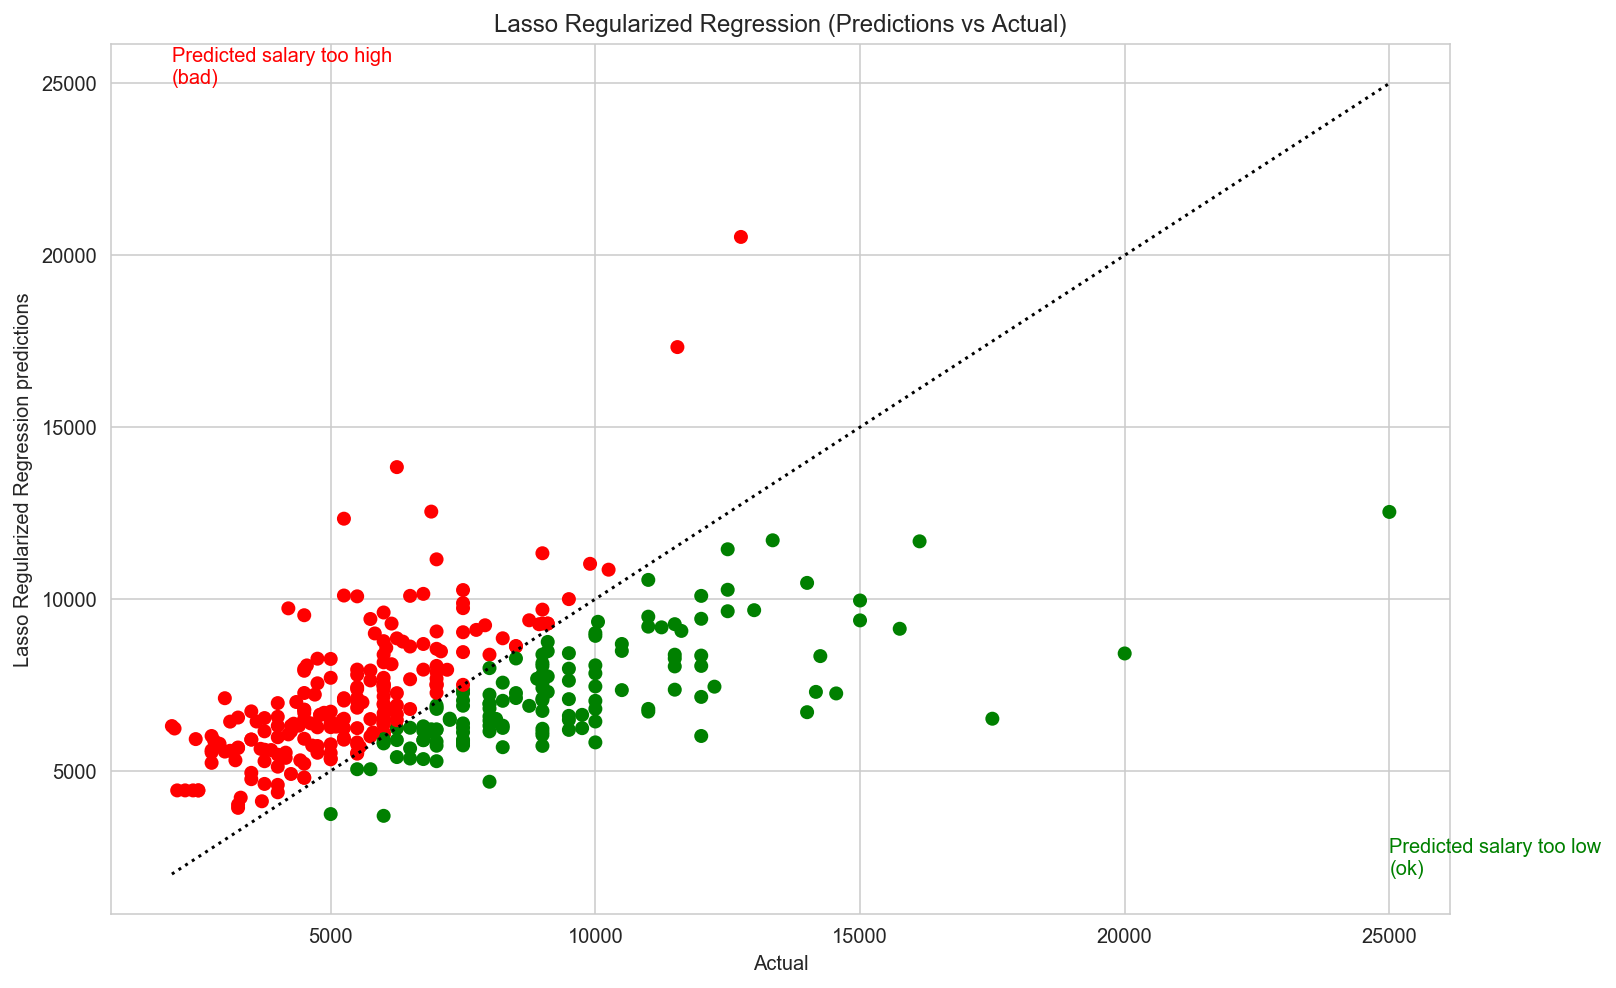

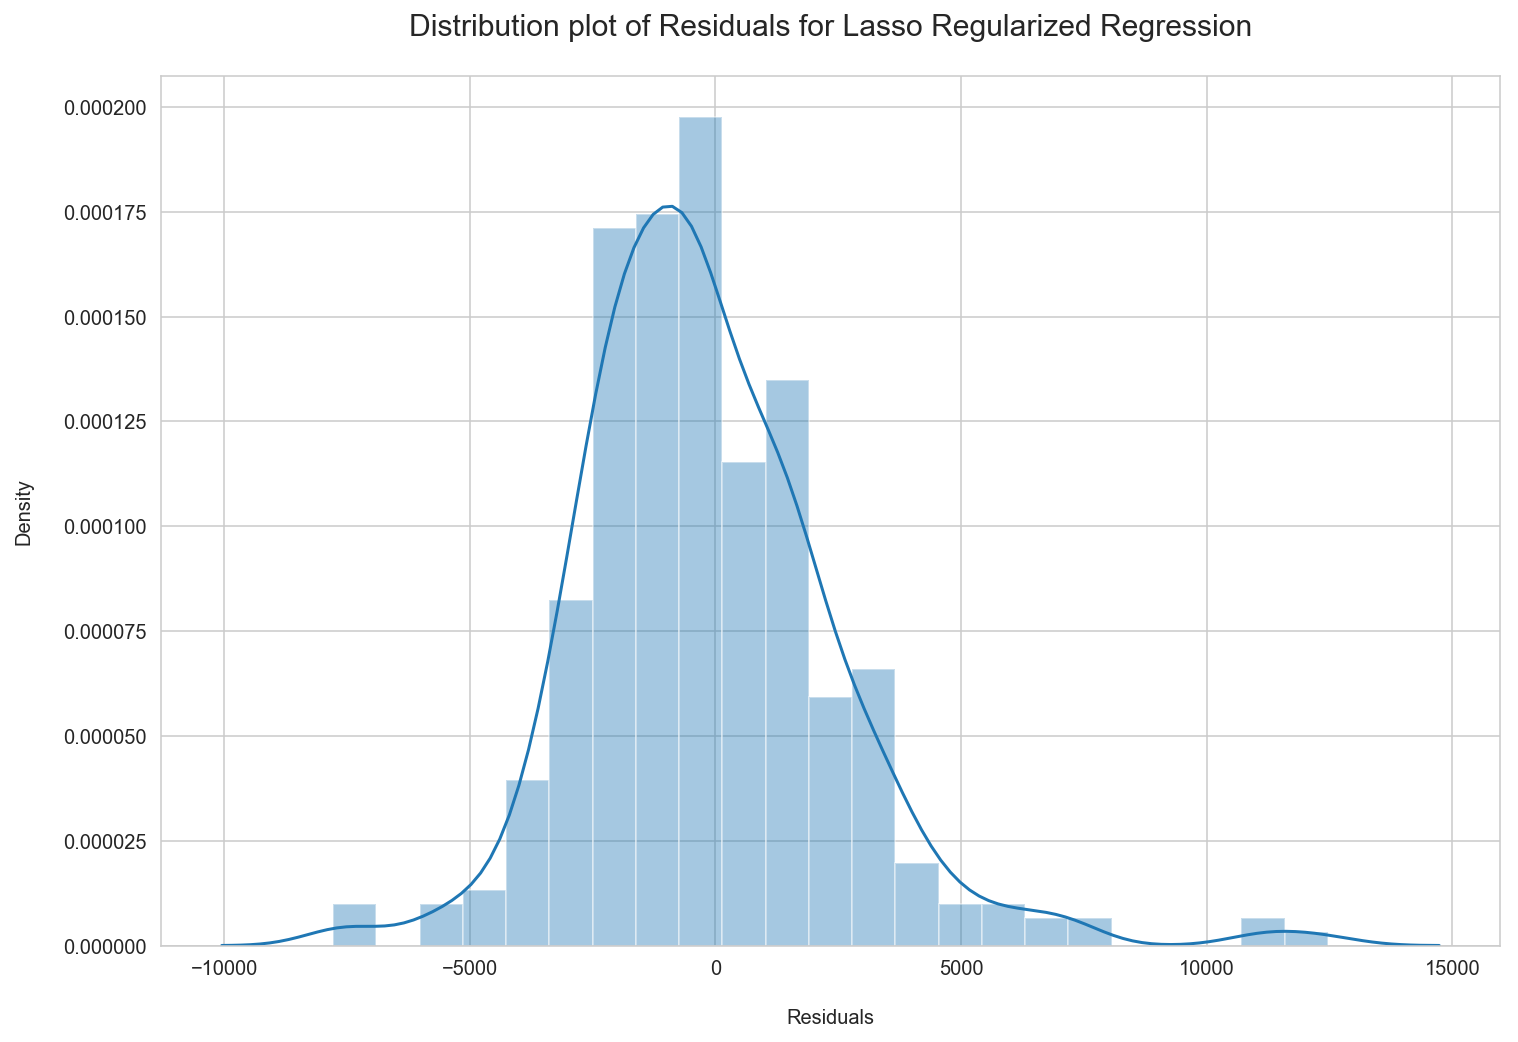

In [82]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

In [90]:
# Creating a feature set from 'Title', 'Company', 'Employment', 'Seniority', 'Summary' and 'Requirements'

finaldata = pd.concat([titles, companies, employment, seniority, summaries, requirements], axis=1)
finaldata.shape

(1379, 19640)

In [91]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = finaldata

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [0.39925254 0.43815372 0.45242749 0.42283753 0.3714916 ]
Mean Cross-validated scores: 0.41683257514438427
Std Cross-validated scores: 0.02871414437706412
Train score: 0.9190142747376244
Test score: 0.39395293490966793
Train Mean Squared Error: 997817.3011116121
Train Mean Squared Error: 5614745.05306746


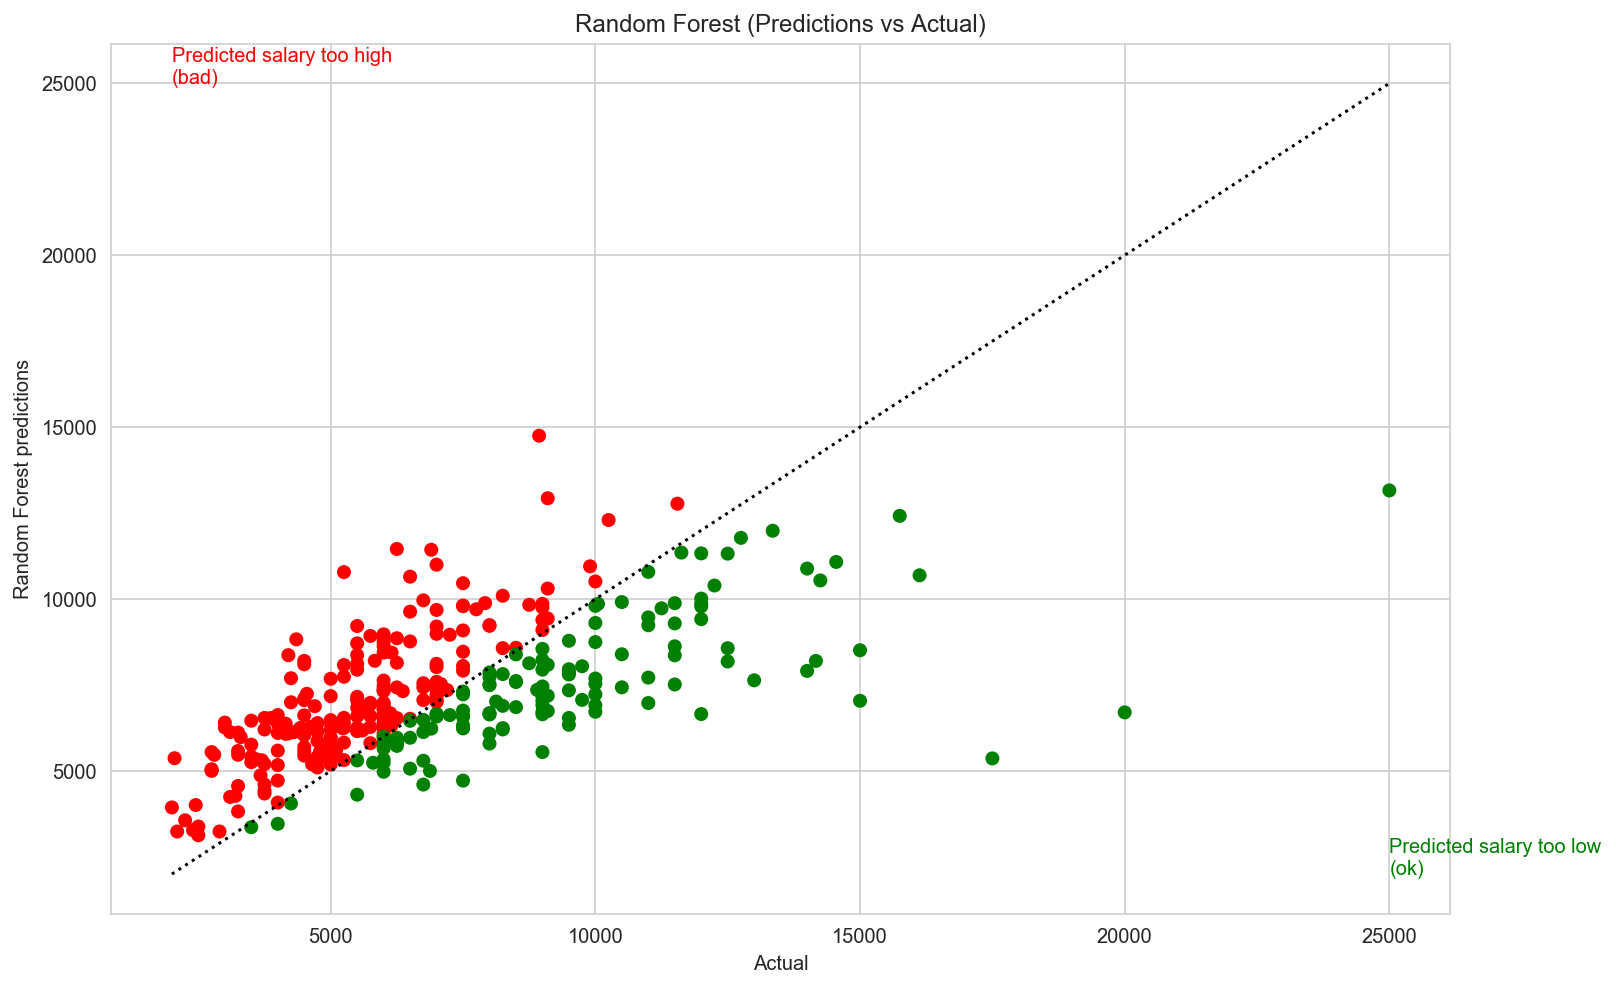

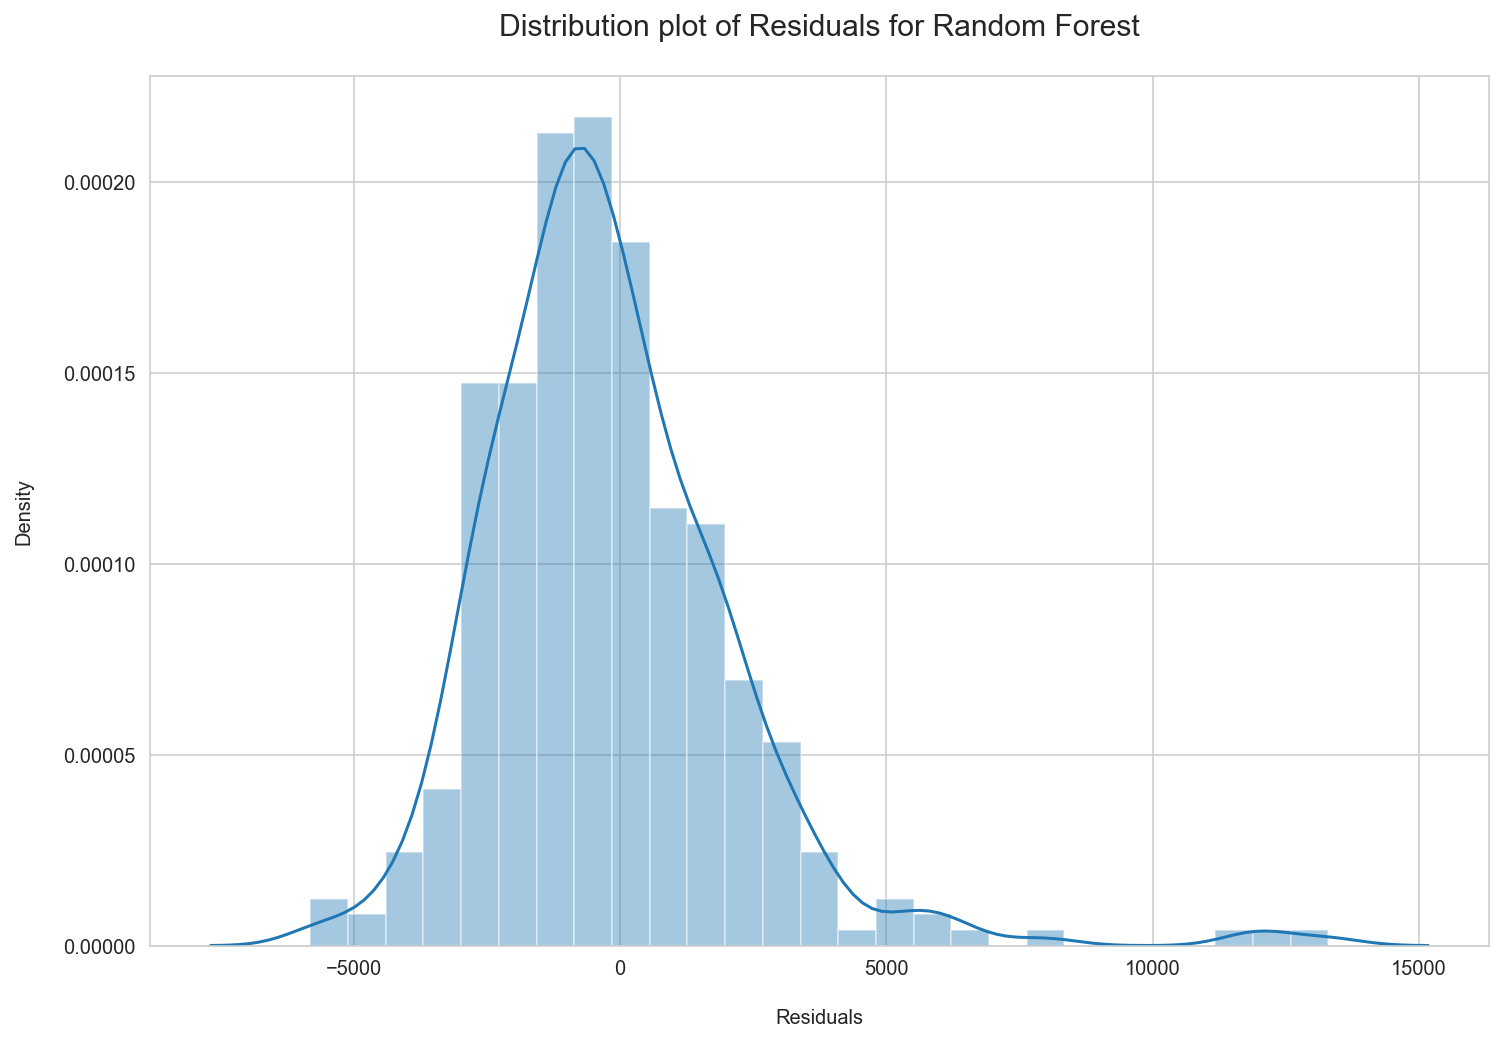

In [93]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=200, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [94]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=200, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

37.64109295141432


Cross-validated scores: [0.42003549 0.40375276 0.43205462 0.24465253 0.42119258]
Mean Cross-validated scores: 0.38433759647609766
Std Cross-validated scores: 0.0704250102735139
Train score: 0.70721491067893
Test score: 0.30279868876841054
Train Mean Squared Error: 3607376.814686598
Train Mean Squared Error: 6459246.878204477


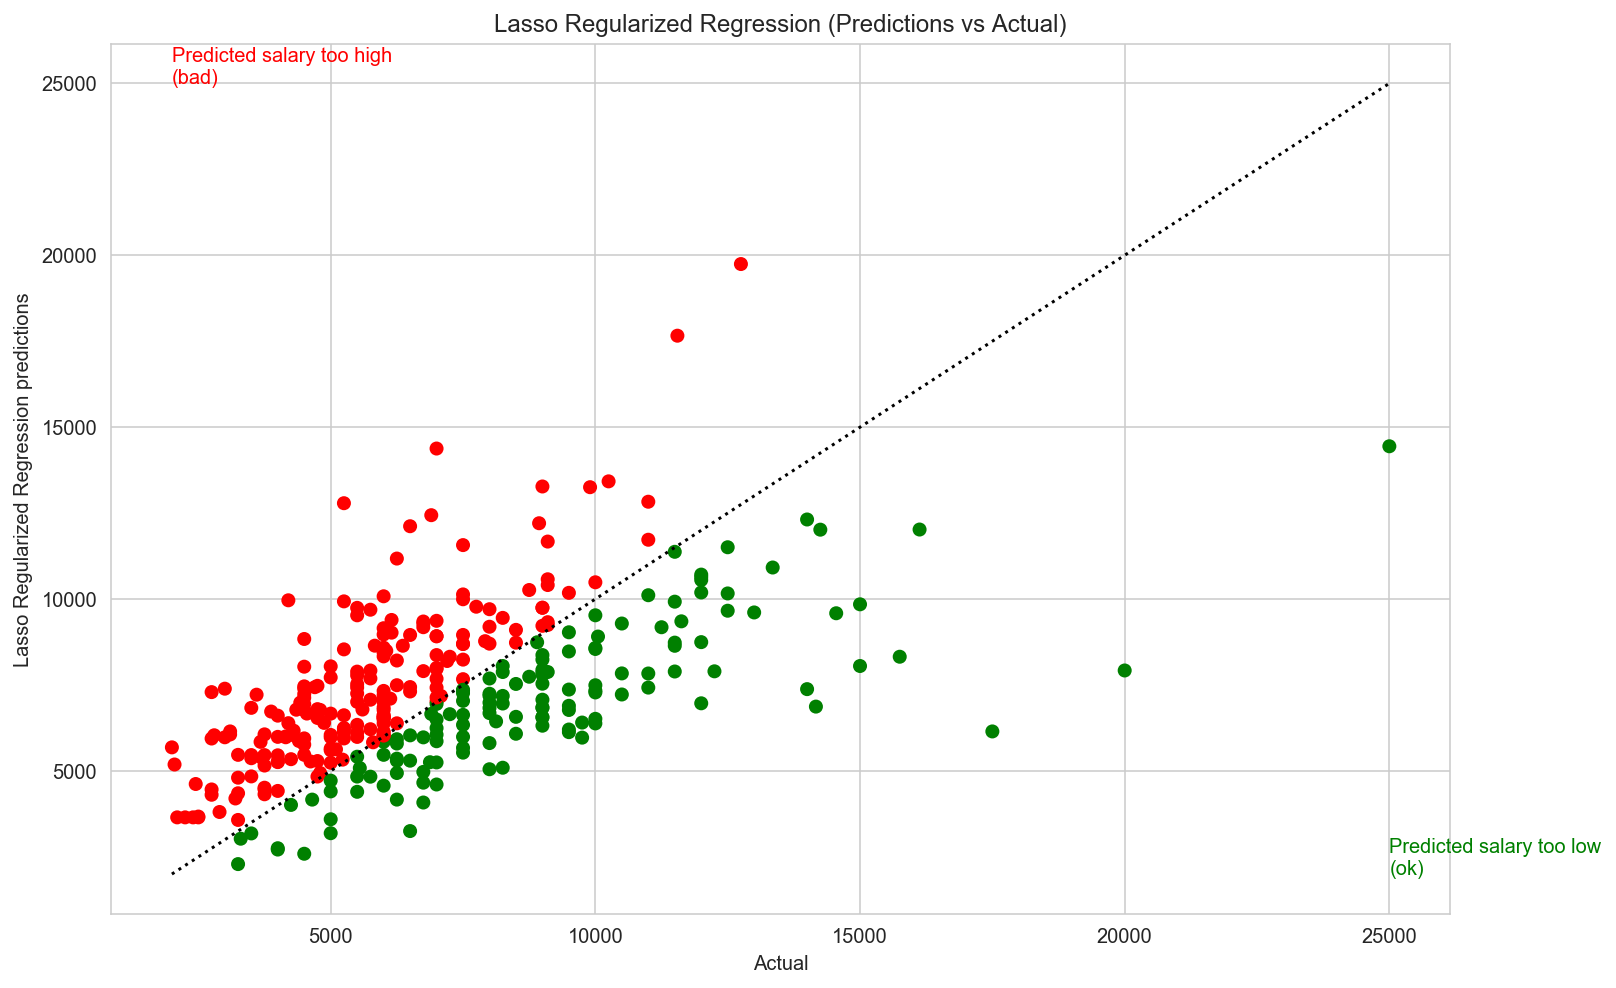

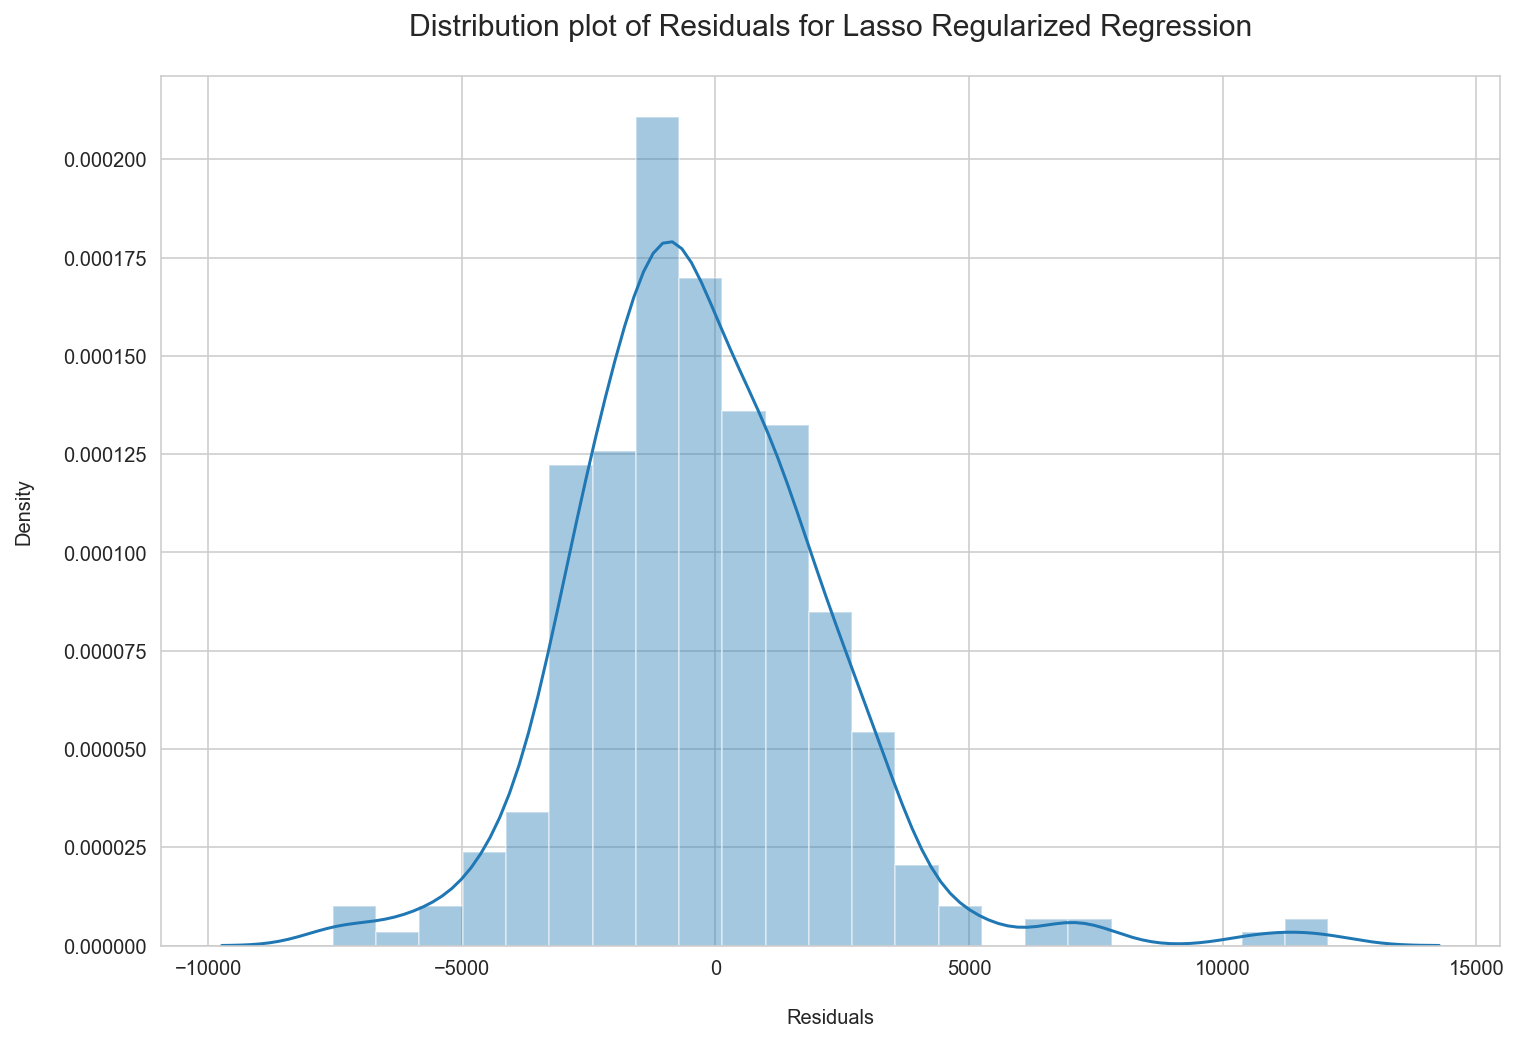

In [95]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

In [106]:
# Attemping TF-IDF Vectorizor to see if improves the scores

tfidf = TfidfVectorizer(max_df=0.9)

tftitle = tfidf.fit_transform(df['Title'])
tftitle = pd.DataFrame(tftitle.todense(), columns=tfidf.get_feature_names())
print(tftitle.shape)

tfcompany = tfidf.fit_transform(df['Company'])
tfcompany = pd.DataFrame(tfcompany.todense(), columns=tfidf.get_feature_names())
print(tfcompany.shape)

tfemployment = tfidf.fit_transform(df['Employment Type'])
tfemployment = pd.DataFrame(tfemployment.todense(), columns=tfidf.get_feature_names())
print(tfemployment.shape)

tfseniority = tfidf.fit_transform(df['Seniority'])
tfseniority = pd.DataFrame(tfseniority.todense(), columns=tfidf.get_feature_names())
print(tfseniority.shape)

tfsummary = tfidf.fit_transform(df['Summary'])
tfsummary = pd.DataFrame(tfsummary.todense(), columns=tfidf.get_feature_names())
print(tfsummary.shape)

tfrequirement = tfidf.fit_transform(df['Requirements'])
tfrequirement = pd.DataFrame(tfrequirement.todense(), columns=tfidf.get_feature_names())
print(tfrequirement.shape)

(1379, 843)
(1379, 826)
(1379, 10)
(1379, 11)
(1379, 9899)
(1379, 8045)


In [107]:
# Creating a feature set from TF-IDF vector 'Title', 'Company', 'Employment', 'Seniority', 'Summary' and 'Requirements'

tfdata = pd.concat([tftitle, tfcompany, tfemployment, tfseniority, tfsummary, tfrequirement], axis=1)
tfdata.shape

(1379, 19634)

In [108]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = tfdata

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [0.4240442  0.41585889 0.40731706 0.38331871 0.43262935]
Mean Cross-validated scores: 0.4126336407929602
Std Cross-validated scores: 0.016900076589828554
Train score: 0.9188204451560609
Test score: 0.3709150391312118
Train Mean Squared Error: 1000205.4566701963
Train Mean Squared Error: 5828180.475505963


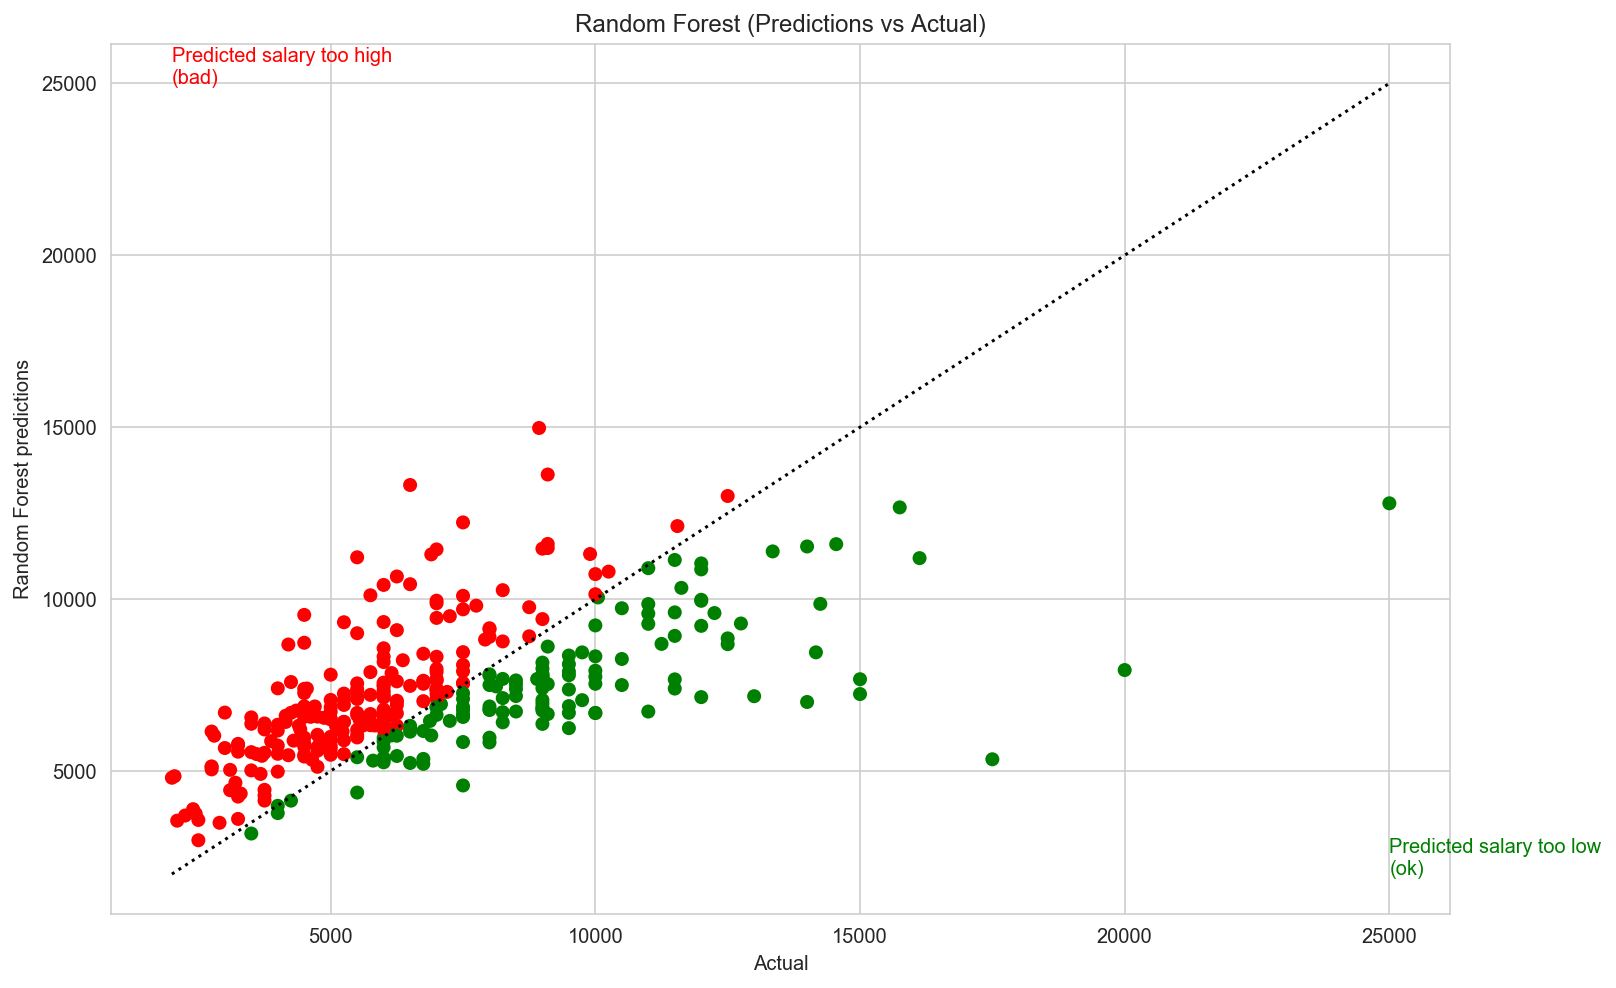

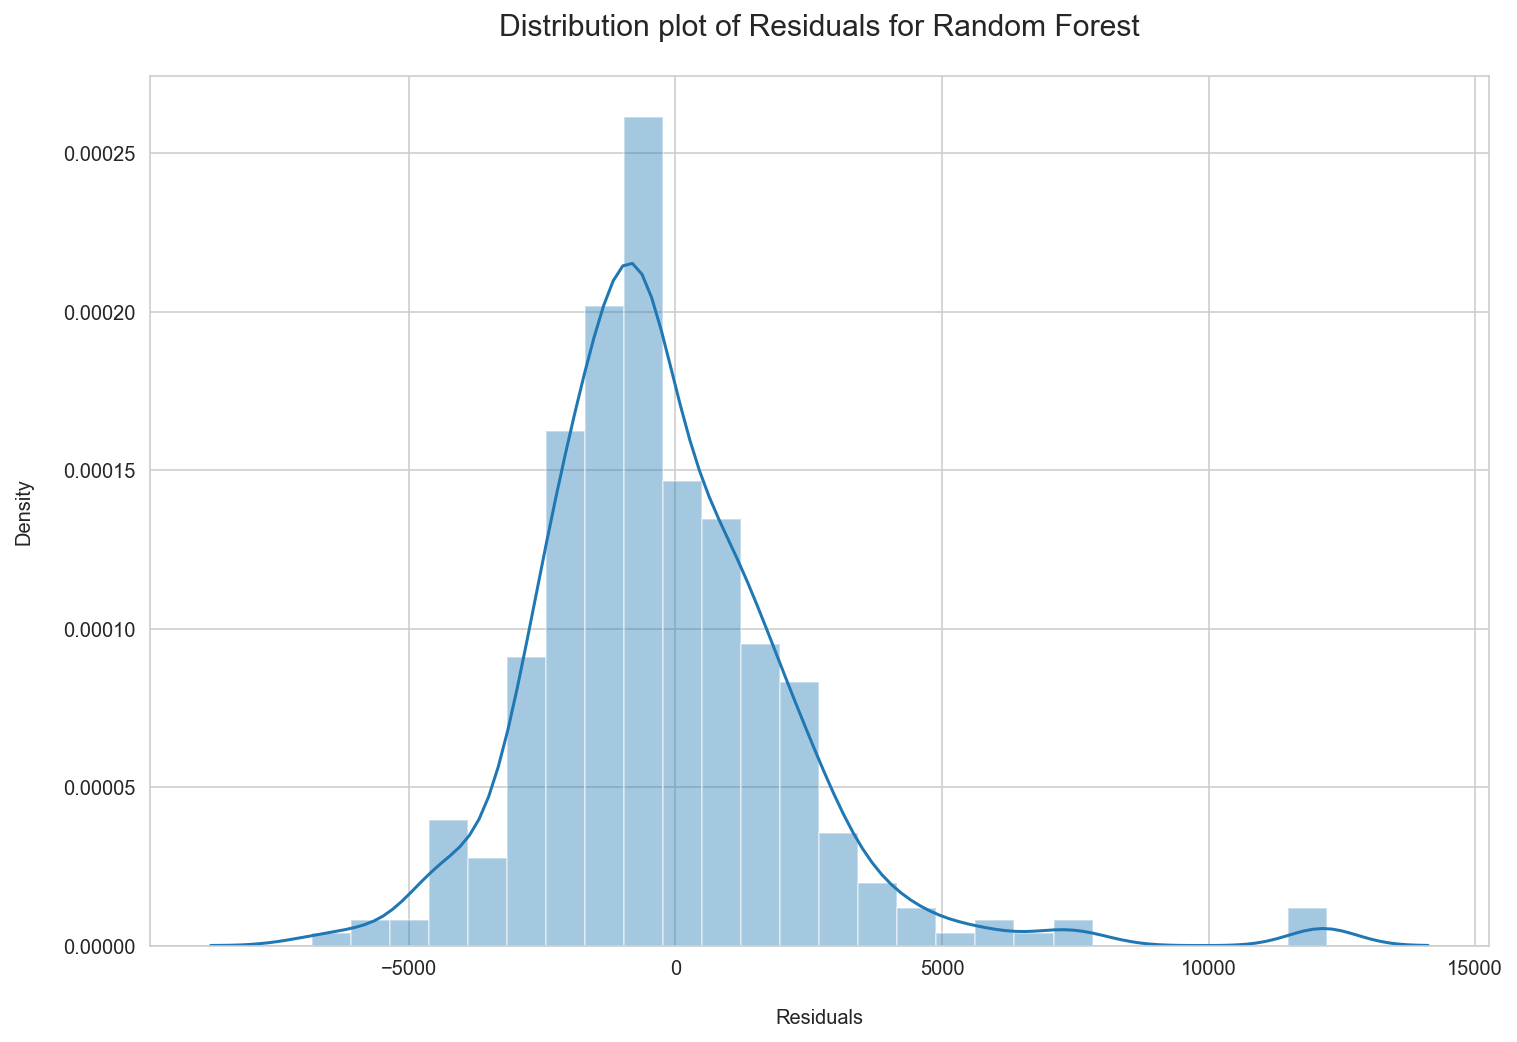

In [109]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=200, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [110]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=200, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

2.840016067465145


Cross-validated scores: [0.51077948 0.45806949 0.46581348 0.42178151 0.59582624]
Mean Cross-validated scores: 0.49045403956943134
Std Cross-validated scores: 0.05981346932329014
Train score: 0.7803345268860045
Test score: 0.4945715011661892
Train Mean Squared Error: 2706477.0837070243
Train Mean Squared Error: 4682560.690370583


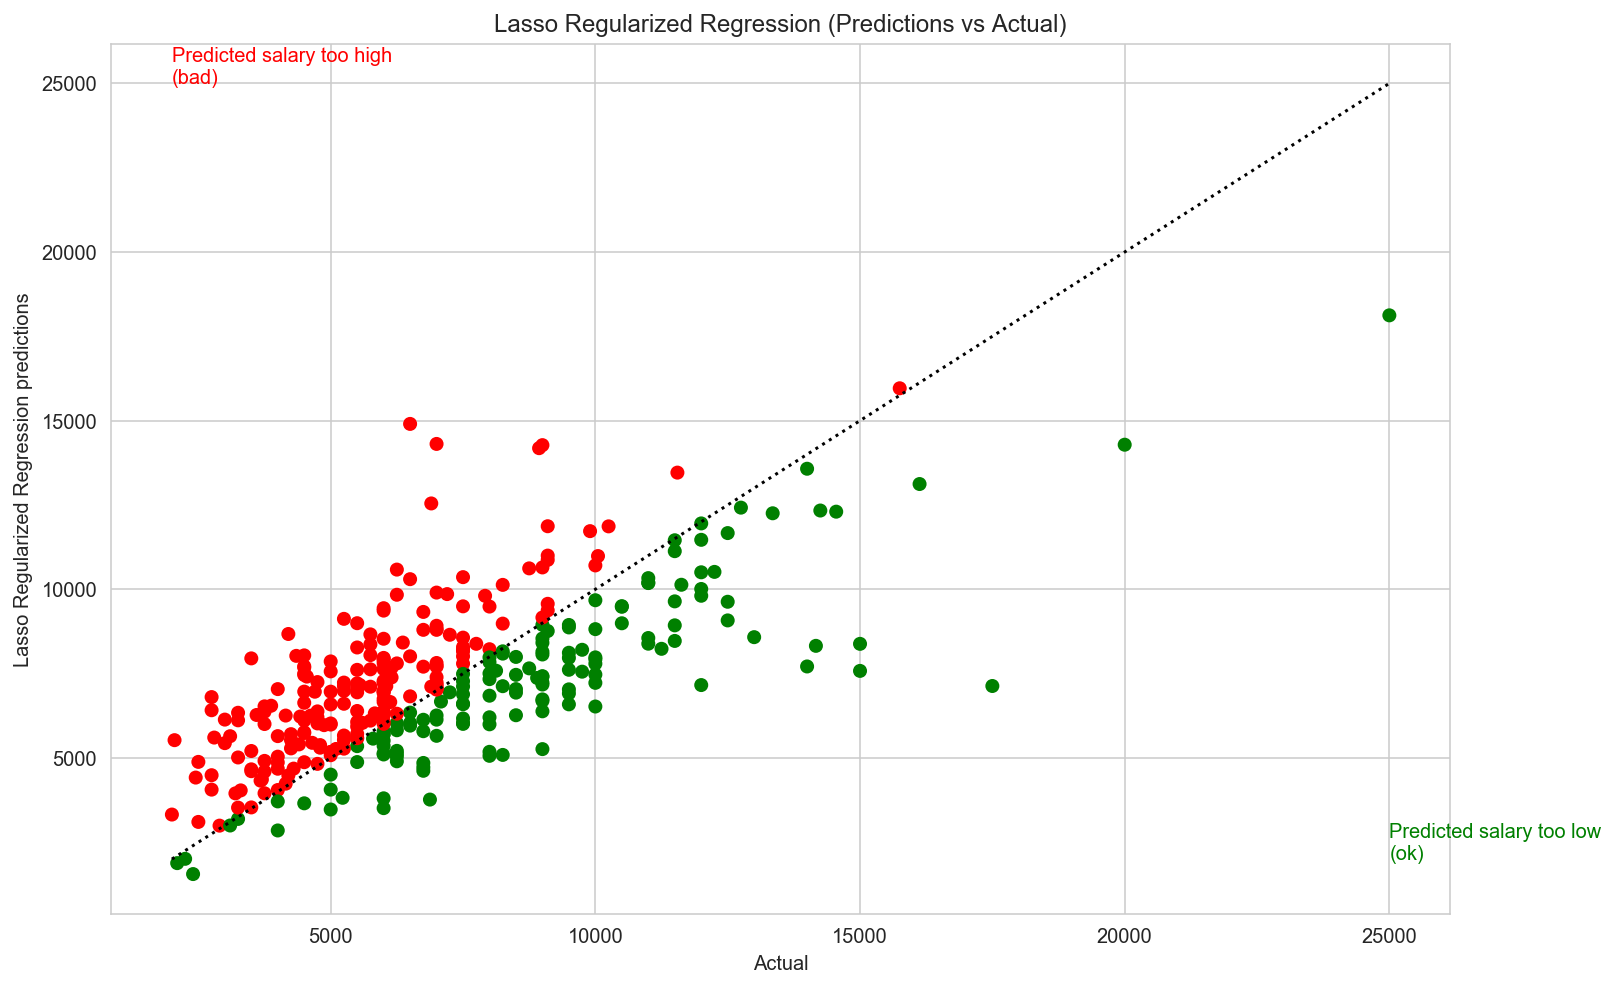

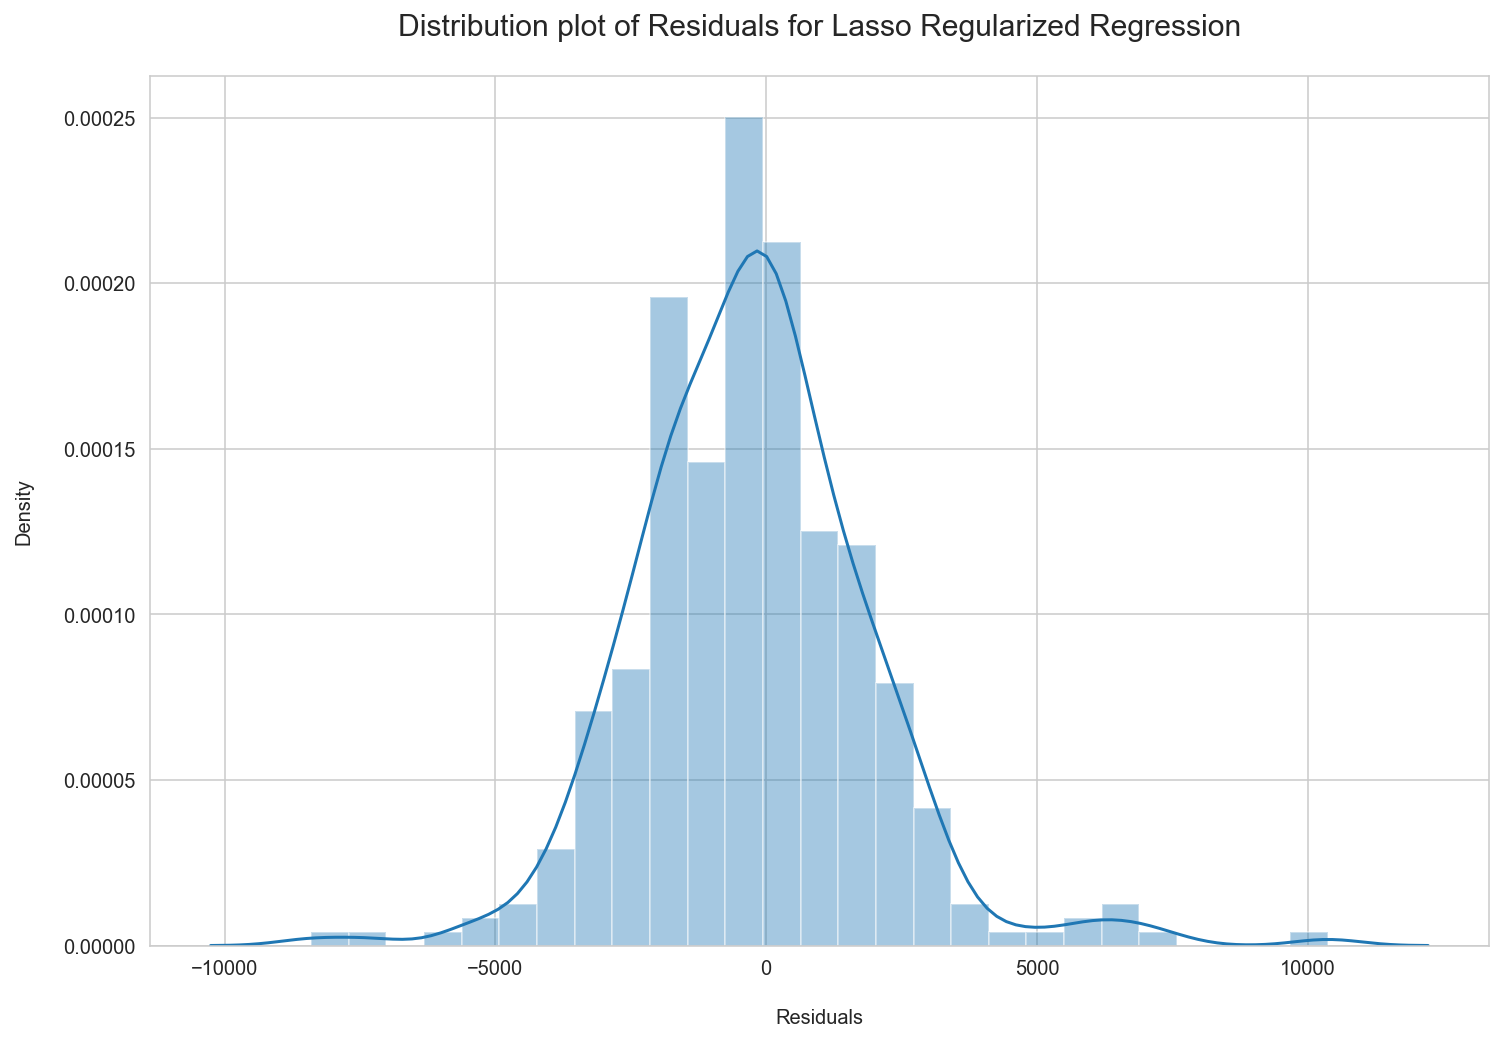

In [111]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

<div class="alert alert-warning">
    
## Executive Summary

Predicting salary based on web scraped information from mycareersfuture.sg

The model's goal is to be able to predict the salary of jobs that are related to data (ie, data scientist, data analyst, data engineer, etc.) based on the job's title, location, job summary/requirements and seniority.

### Approach

After cleaning the data and conducting some basic EDA. We attempted to apply various regression models on the individual features to see the effectiveness of the models as well as how well simple models (fewer features) would do. After which, we attempted to increase the complexity by using more features in the models.

In addition to increasing the complexity of the models by adding more features, we also attemped to try other NLP techniques on the Summary and Requirements columns. On the best model that we had, other than using a simple bag of words through Count Vectorizer, we also tried TF-IDF to vectorize the words. However, we did not see any marked improvement in the results.

### Limitations

The best model, Random Forest Regression based on job title, company, employment type, seniority, job summary and requirements, was still lacking. The $R^2$ of the model was 0.417 which means that almost 60% of the salary is unaccounted for by those features. There might be other factors which influence salary that is not captured in our web scraped dataset.

In addition, we used the average salary of the from and to that was provided by the job posting. This adds another layer of complexity as the range could be relatively large and the average does not properly capture that real salary.

There were also some jobs which had multiple postings which we aggregated and then found the average salary for. There could have been a reason for the employers to split the job postings into multiple posts with varying salary ranges, something which we did not account for.

Lastly, since it was a preference of the boss to tell the client a lower salary compared to a higher salary. It is relatively more difficult for us to tune the model since we are applying a regression. Unlike a classification, where we can change the cut-offs etc, with a regression model we could vary the constant or the gradients, but we might not get the results that we are looking for.

### Further Tuning

There are quite a few parameters that we have not yet tested and tried to tune (ie, adjusting ngram_range, max_df, min_df, stop_words, etc.) Perhaps by changing some of these parameters we might be able to get better results. We also tried to minimize the number of n_estimators for the Random Forest model as it would take too long to process should we increase the number of estimators. Perhaps with more computing power, we might be able to apply GridSearch for the best parameters for the Random Forest model.
    
</div>

In [22]:
# Trying other methods

from textblob import TextBlob, Word

# Trying to use TextBlob with stemming/lematize to see if we can get better results

# Defining a function for stemming words to be used with CountVectorizer analyzer

def stemmit(text):
    '''
    Function to stem text using TextBlob and SnowballStemmer
    input = text
    '''
    from nltk.stem.snowball import SnowballStemmer
    
    stemmer = SnowballStemmer('english')
    blob = TextBlob(text)
    return [stemmer.stem(word) for word in blob.words]

# Defining a function for lemmatizing words to be used with CountVectorizer analyzer

def lemmit(text):
    '''
    Function to lemmatize text using TextBlob and lemmatize()
    input = text
    '''
    blob = TextBlob(text)
    return [word.lemmatize() for word in blob.words]

In [23]:
# Attemping to use stemming with CountVectorizer

stemvect = CountVectorizer(analyzer=stemmit)

stemtitle = stemvect.fit_transform(df['Title'])
stemtitle = pd.DataFrame(stemtitle.todense(), columns=stemvect.get_feature_names())
print(stemtitle.shape)

stemcompany = stemvect.fit_transform(df['Company'])
stemcompany = pd.DataFrame(stemcompany.todense(), columns=stemvect.get_feature_names())
print(stemcompany.shape)

stememployment = stemvect.fit_transform(df['Employment Type'])
stememployment = pd.DataFrame(stememployment.todense(), columns=stemvect.get_feature_names())
print(stememployment.shape)

stemseniority = stemvect.fit_transform(df['Seniority'])
stemseniority = pd.DataFrame(stemseniority.todense(), columns=stemvect.get_feature_names())
print(stemseniority.shape)

stemsummary = stemvect.fit_transform(df['Summary'])
stemsummary = pd.DataFrame(stemsummary.todense(), columns=stemvect.get_feature_names())
print(stemsummary.shape)

stemrequirement = stemvect.fit_transform(df['Requirements'])
stemrequirement = pd.DataFrame(stemrequirement.todense(), columns=stemvect.get_feature_names())
print(stemrequirement.shape)

(1379, 788)
(1379, 809)
(1379, 10)
(1379, 9)
(1379, 8037)
(1379, 7036)


In [24]:
# Creating a feature set with the stemmed words

stemdata = pd.concat([stemtitle, stemcompany, stememployment, stemseniority, stemsummary, stemrequirement], axis=1)
stemdata.shape

(1379, 16689)

In [25]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = stemdata

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [0.40631941 0.4208081  0.40778403 0.41516434 0.34519654]
Mean Cross-validated scores: 0.39905448435407137
Std Cross-validated scores: 0.027431401548367085
Train score: 0.9168622584740413
Test score: 0.38534056561550345
Train Mean Squared Error: 1024909.4313727699
Train Mean Squared Error: 5676289.967369987


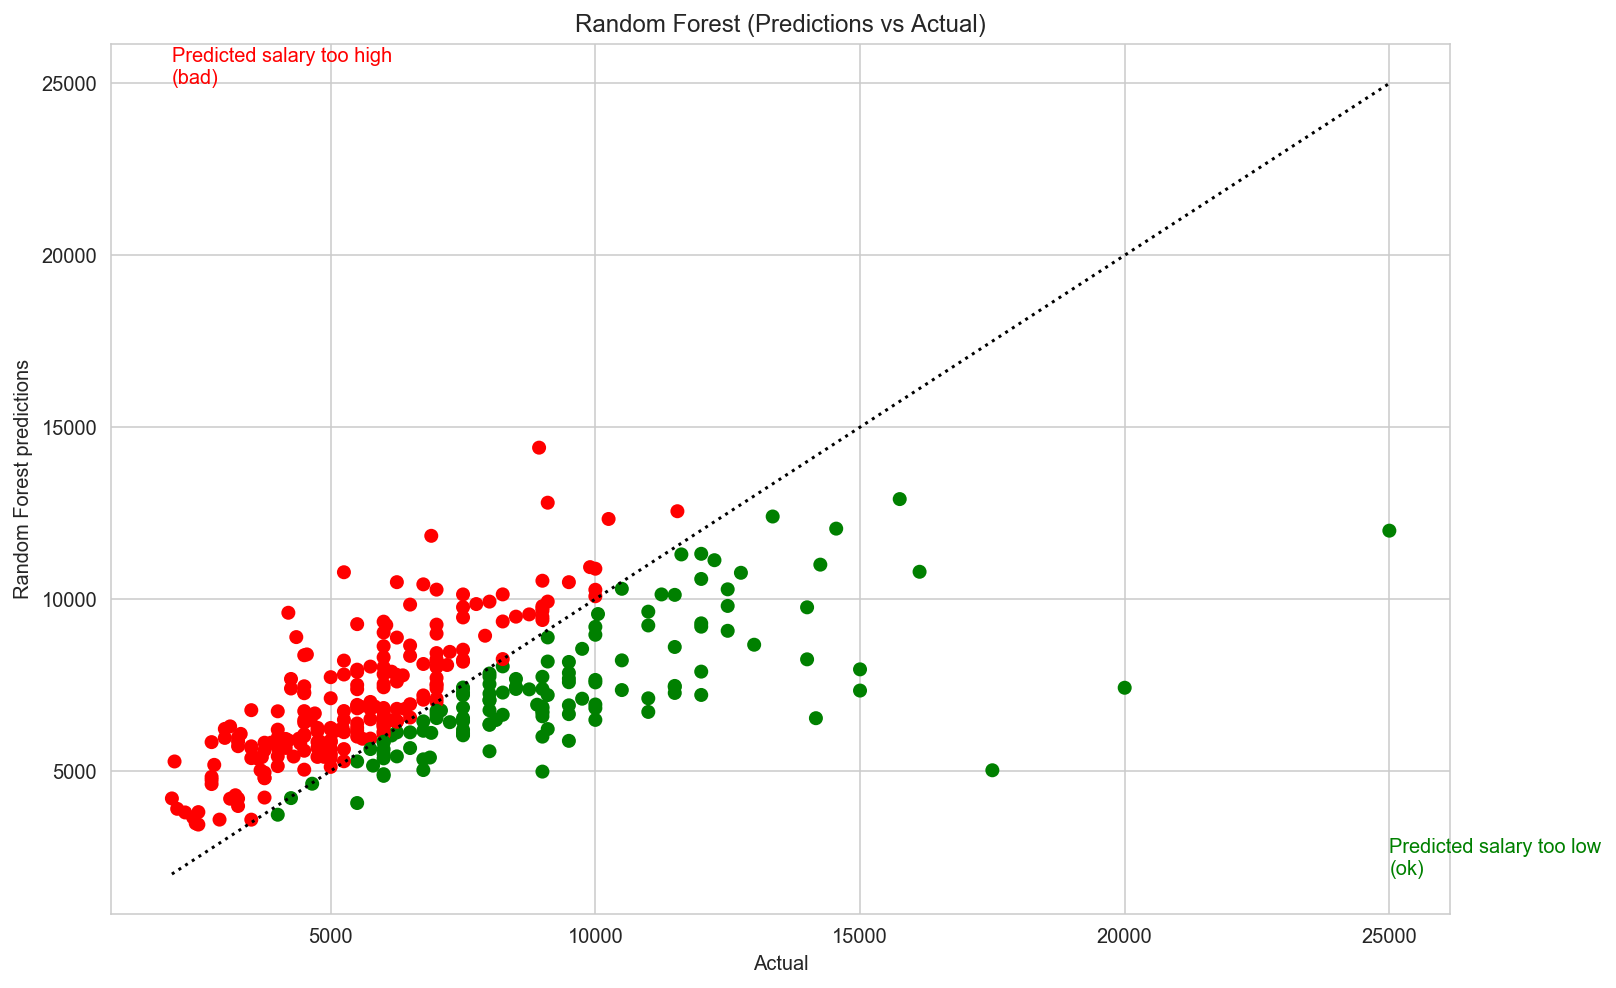

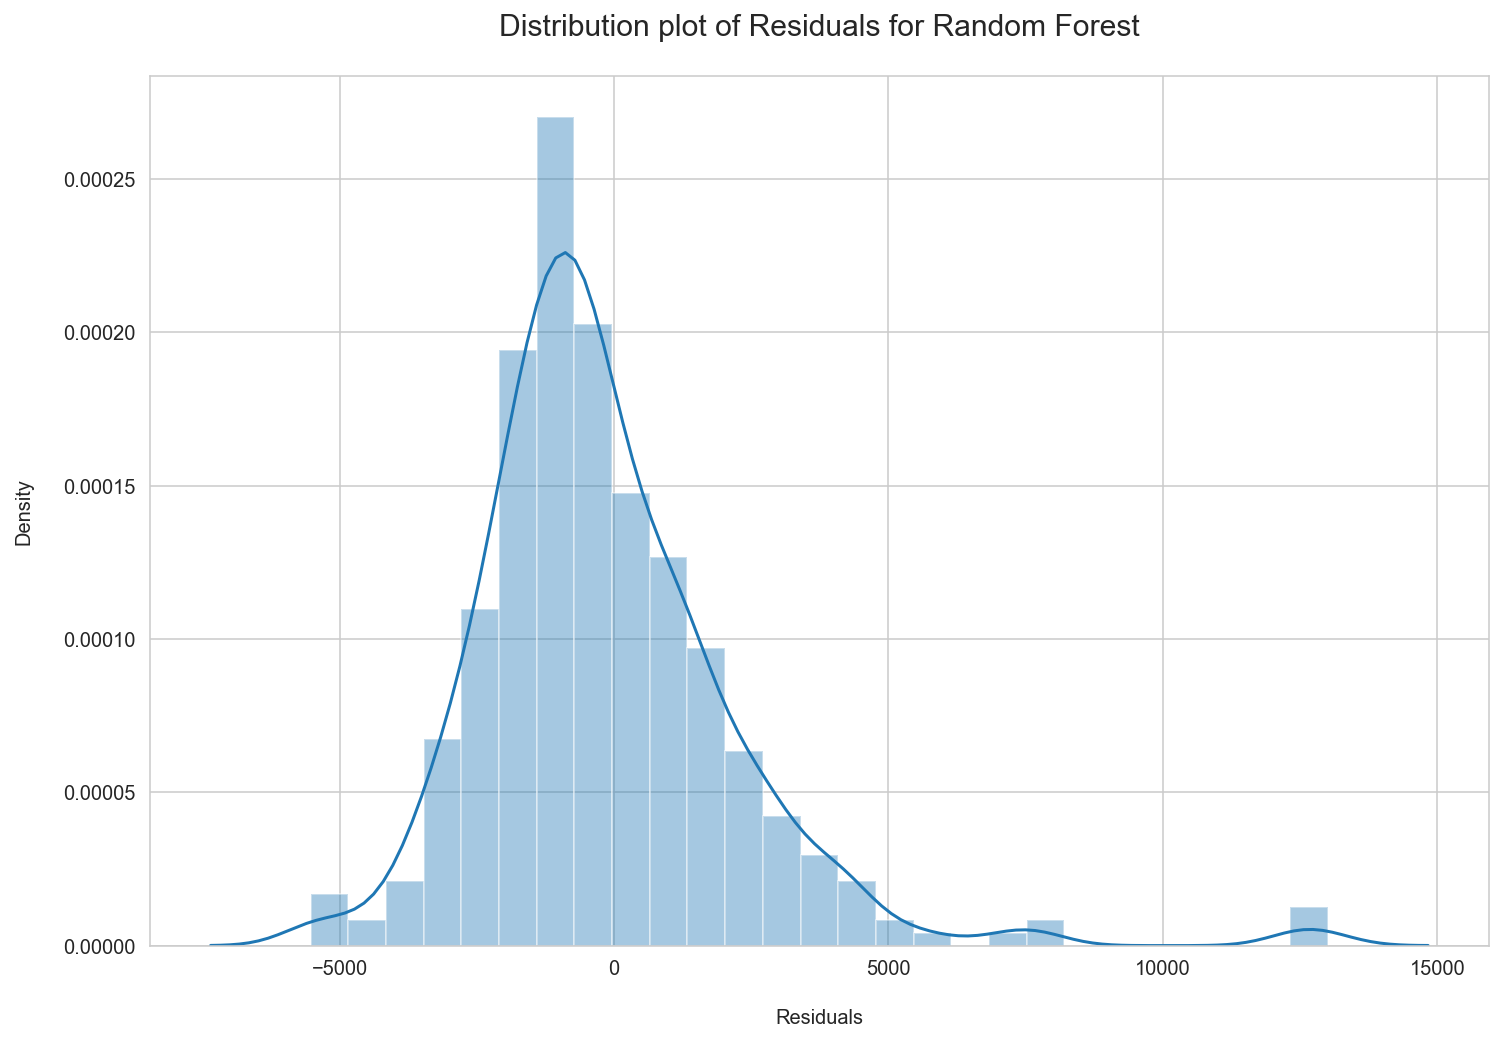

In [26]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=200, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [27]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=200, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

25.9955337736362


Cross-validated scores: [0.44826901 0.41794921 0.33566248 0.31371153 0.36655313]
Mean Cross-validated scores: 0.3764290732511032
Std Cross-validated scores: 0.0501554351997145
Train score: 0.7744597338286722
Test score: 0.27947831225776865
Train Mean Squared Error: 2780426.0942203086
Train Mean Squared Error: 6653912.392151312


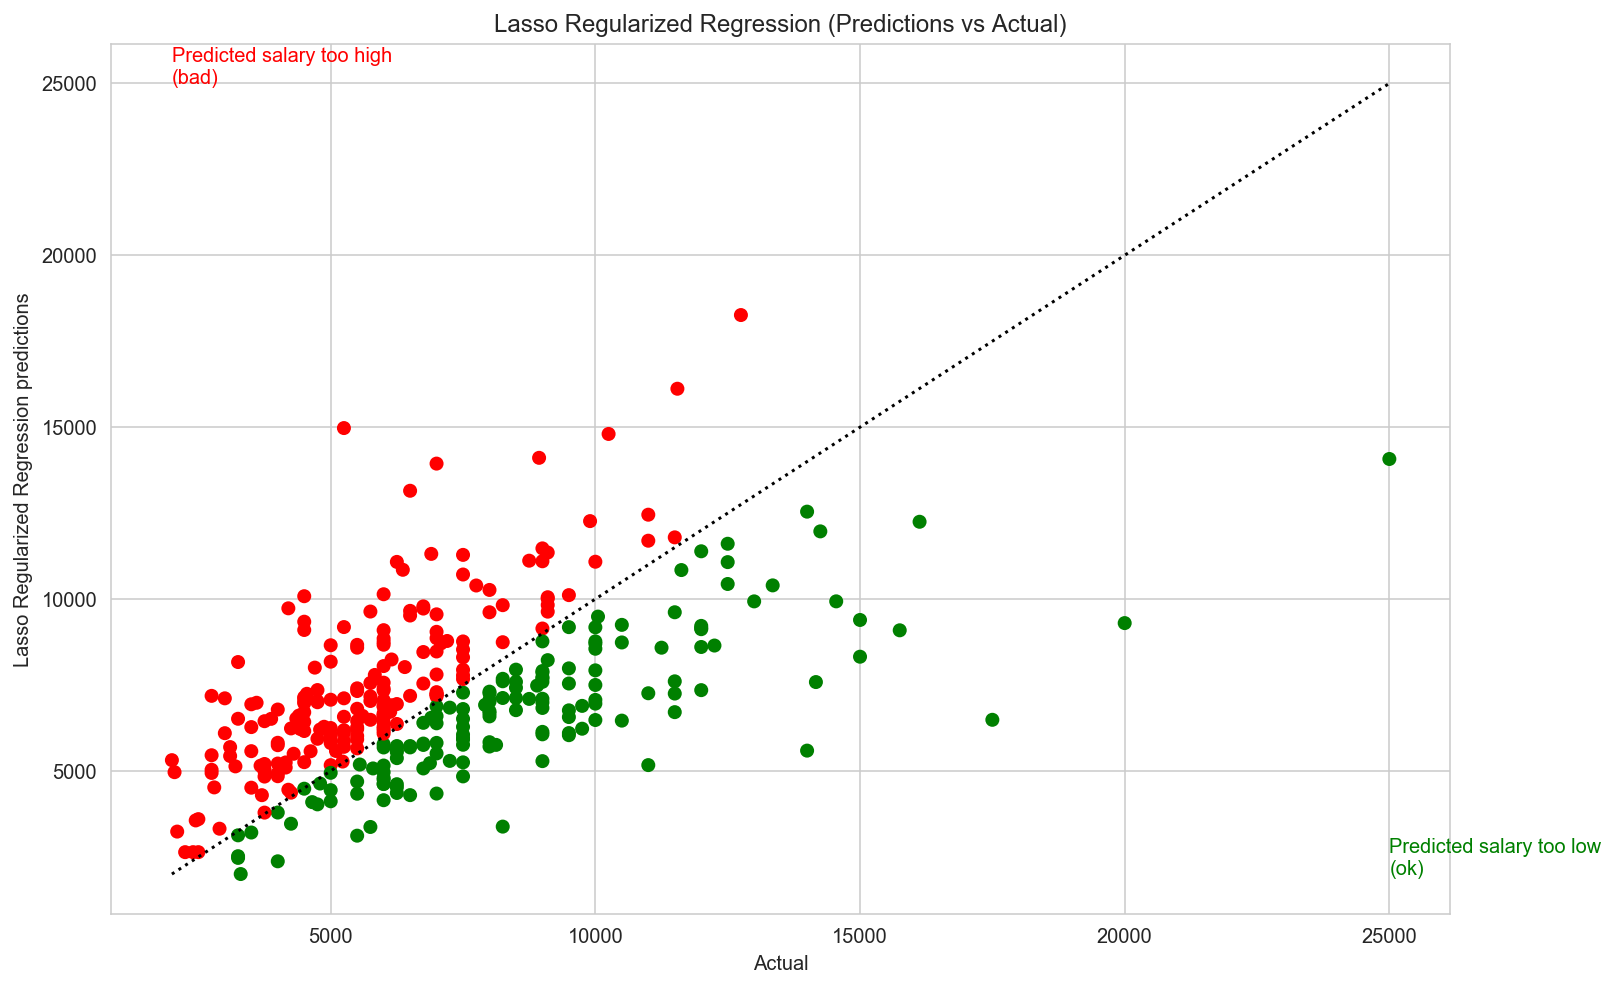

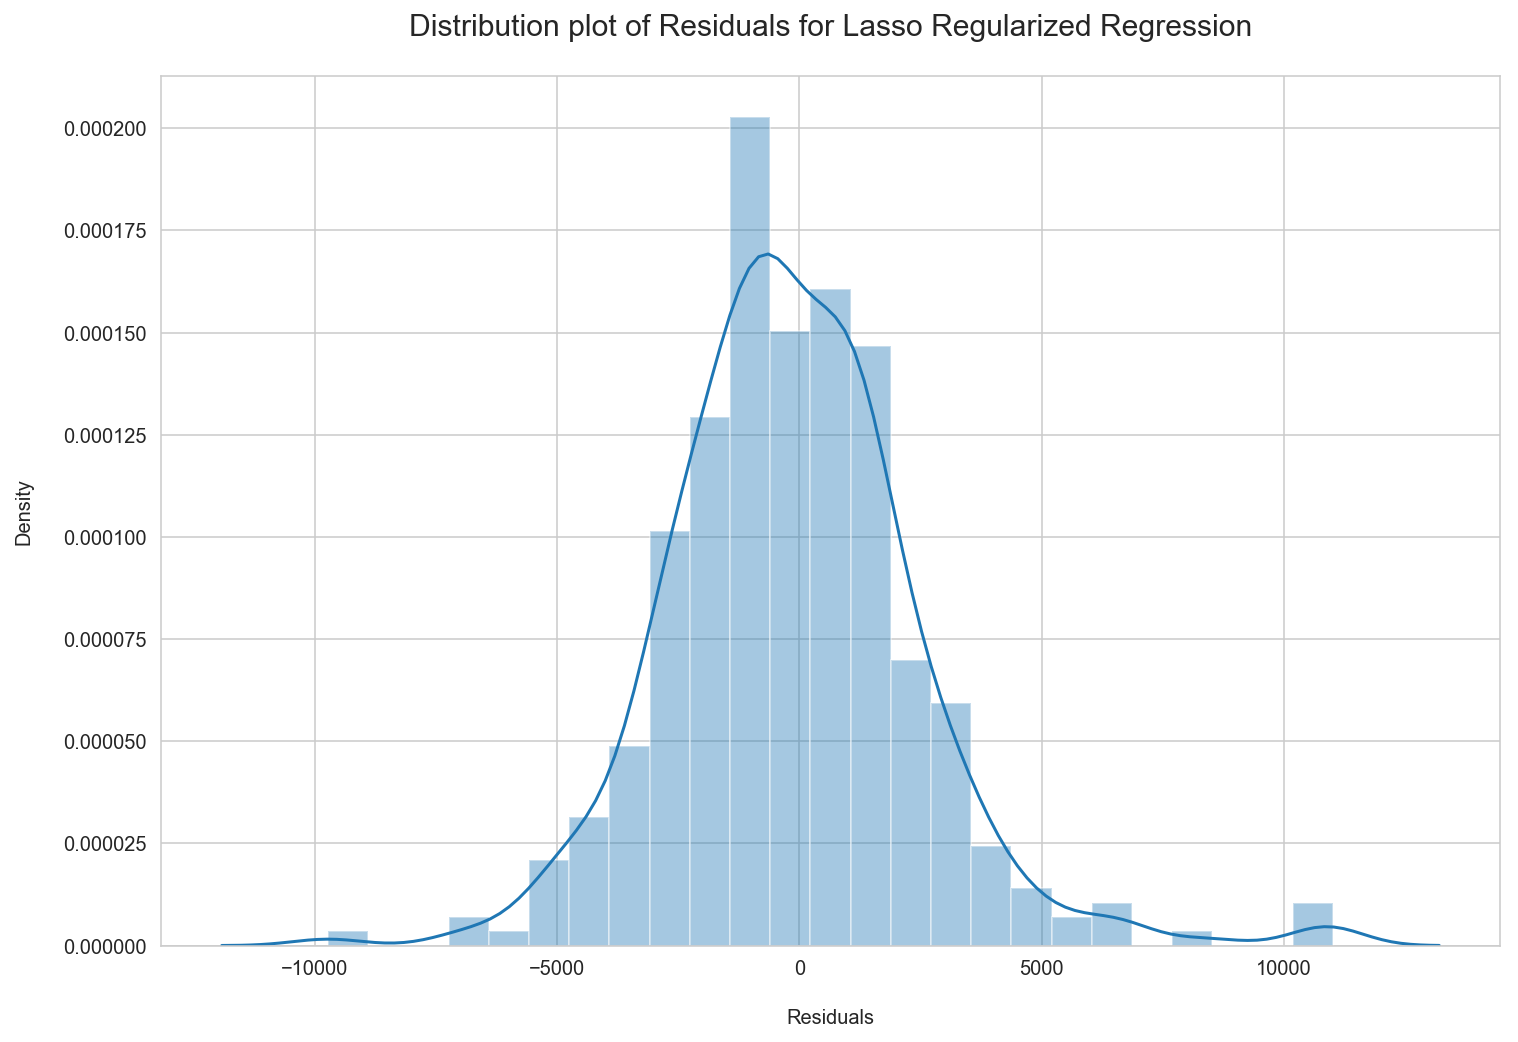

In [28]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')

In [29]:
# Attemping to use lemmatize with CountVectorizer

lemvect = CountVectorizer(analyzer=lemmit)

lemtitle = lemvect.fit_transform(df['Title'])
lemtitle = pd.DataFrame(lemtitle.todense(), columns=lemvect.get_feature_names())
print(lemtitle.shape)

lemcompany = lemvect.fit_transform(df['Company'])
lemcompany = pd.DataFrame(lemcompany.todense(), columns=lemvect.get_feature_names())
print(lemcompany.shape)

lememployment = lemvect.fit_transform(df['Employment Type'])
lememployment = pd.DataFrame(lememployment.todense(), columns=lemvect.get_feature_names())
print(lememployment.shape)

lemseniority = lemvect.fit_transform(df['Seniority'])
lemseniority = pd.DataFrame(lemseniority.todense(), columns=lemvect.get_feature_names())
print(lemseniority.shape)

lemsummary = lemvect.fit_transform(df['Summary'])
lemsummary = pd.DataFrame(lemsummary.todense(), columns=lemvect.get_feature_names())
print(lemsummary.shape)

lemrequirement = lemvect.fit_transform(df['Requirements'])
lemrequirement = pd.DataFrame(lemrequirement.todense(), columns=lemvect.get_feature_names())
print(lemrequirement.shape)

(1379, 832)
(1379, 822)
(1379, 10)
(1379, 10)
(1379, 10389)
(1379, 8718)


In [30]:
# Creating a feature set with the lemmatized words

lemdata = pd.concat([lemtitle, lemcompany, lememployment, lemseniority, lemsummary, lemrequirement], axis=1)
lemdata.shape

(1379, 20781)

In [31]:
# Applying Train-Test Split on the dataset

y = df['Salary avg']
X = lemdata

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Cross-validated scores: [0.36954661 0.43745123 0.42262377 0.43179061 0.3272378 ]
Mean Cross-validated scores: 0.39773000319747165
Std Cross-validated scores: 0.04271078238067281
Train score: 0.9184138630434243
Test score: 0.37302848976777186
Train Mean Squared Error: 1005781.4862574325
Train Mean Squared Error: 5789990.186877656


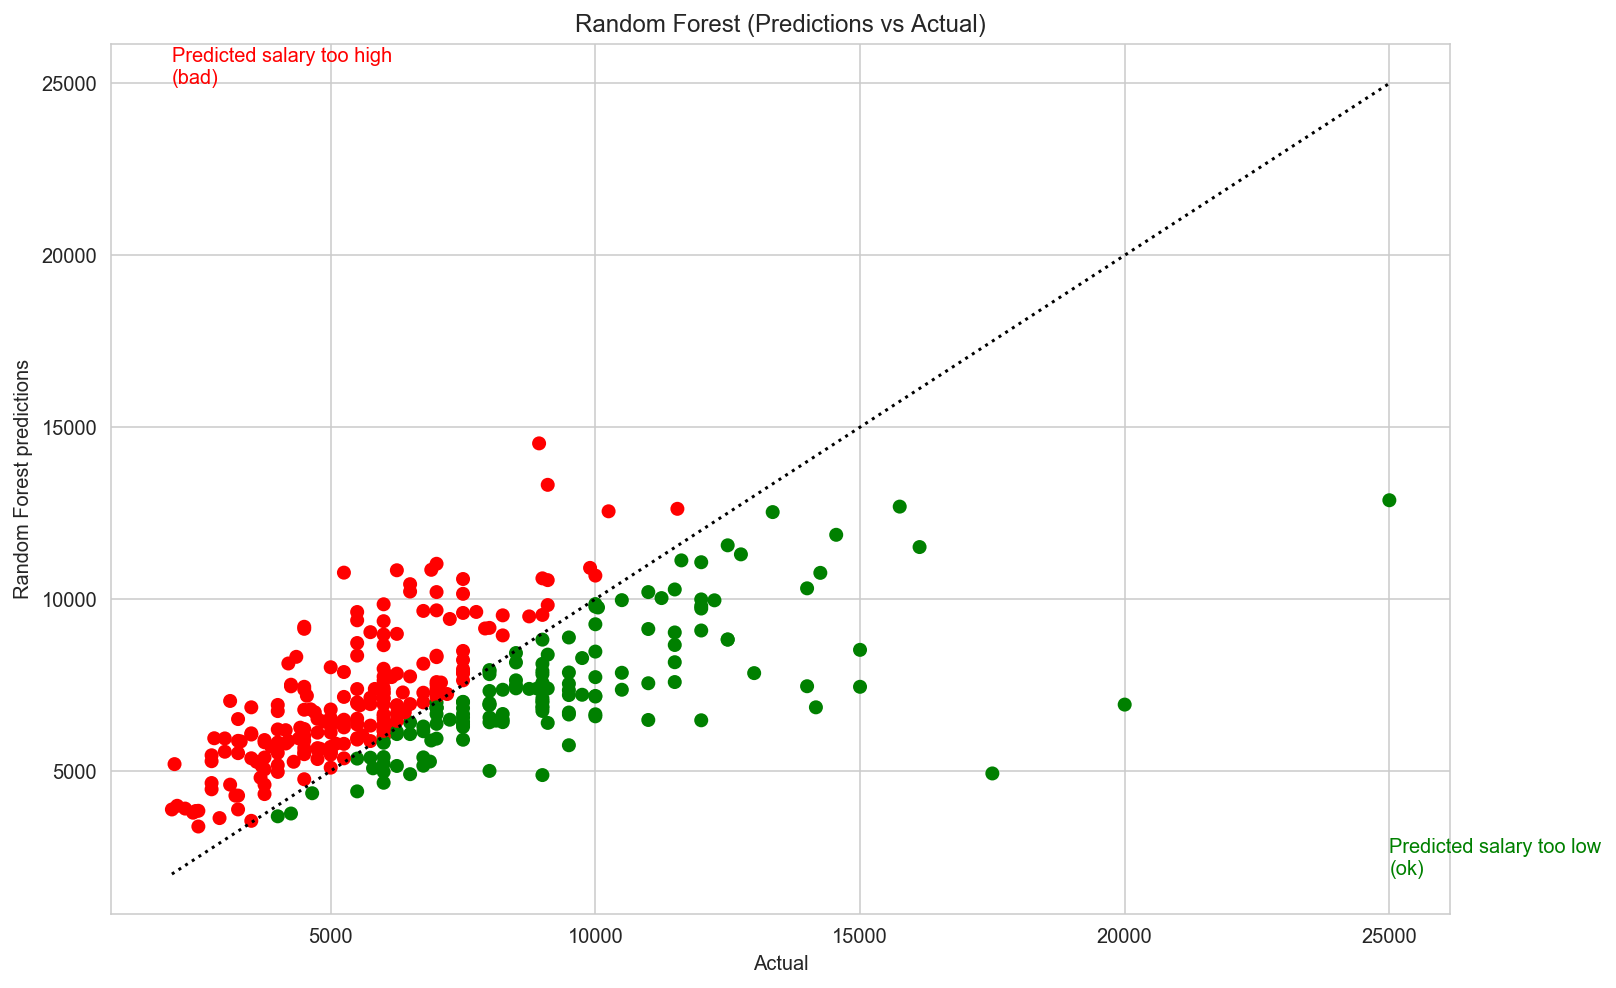

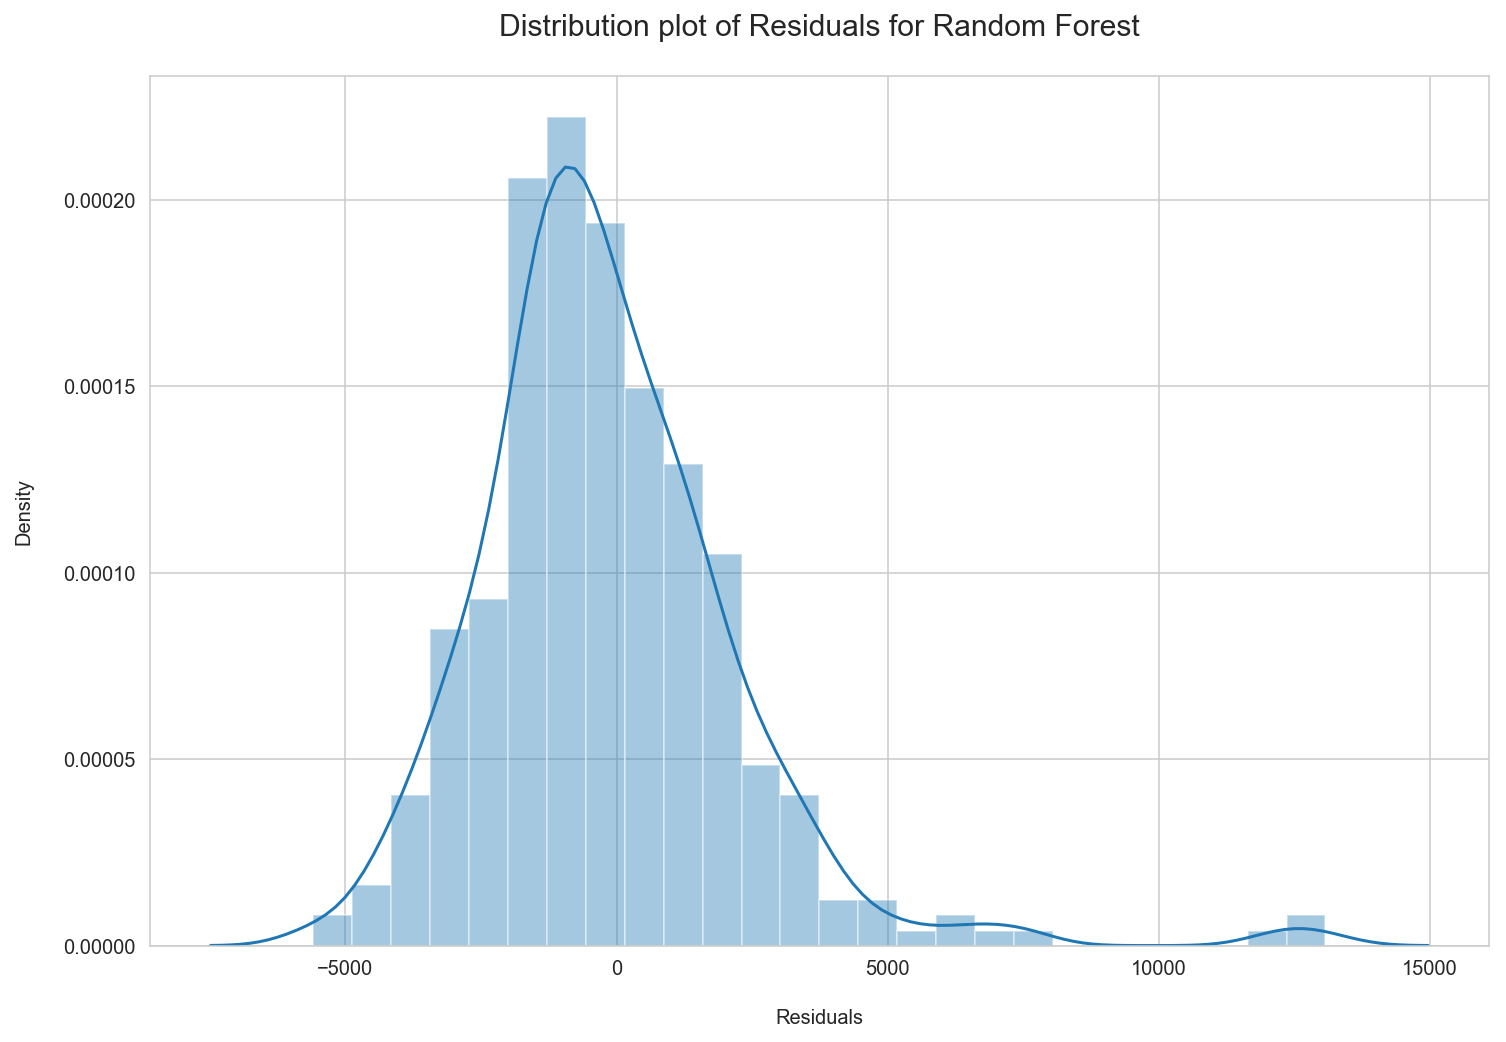

In [32]:
# Using Random Forest Regression
rfreg = RandomForestRegressor(n_estimators=200, random_state=42)

scores = cross_val_score(rfreg, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

rfreg.fit(X_train, y_train)

print("Train score:", rfreg.score(X_train, y_train))
print("Test score:", rfreg.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(X_test)))

show_predictions(rfreg, 'Random Forest')
plot_residuals(rfreg, 'Random Forest')

In [33]:
# Applying Lasso Regularized Linear Regression model
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=200, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

48.5574110495791


Cross-validated scores: [0.42256238 0.38861515 0.37971356 0.30380819 0.37321427]
Mean Cross-validated scores: 0.3735827104744643
Std Cross-validated scores: 0.038810279273089186
Train score: 0.6625789385823009
Test score: 0.32732589303602067
Train Mean Squared Error: 4159675.5197256696
Train Mean Squared Error: 6212046.982558296


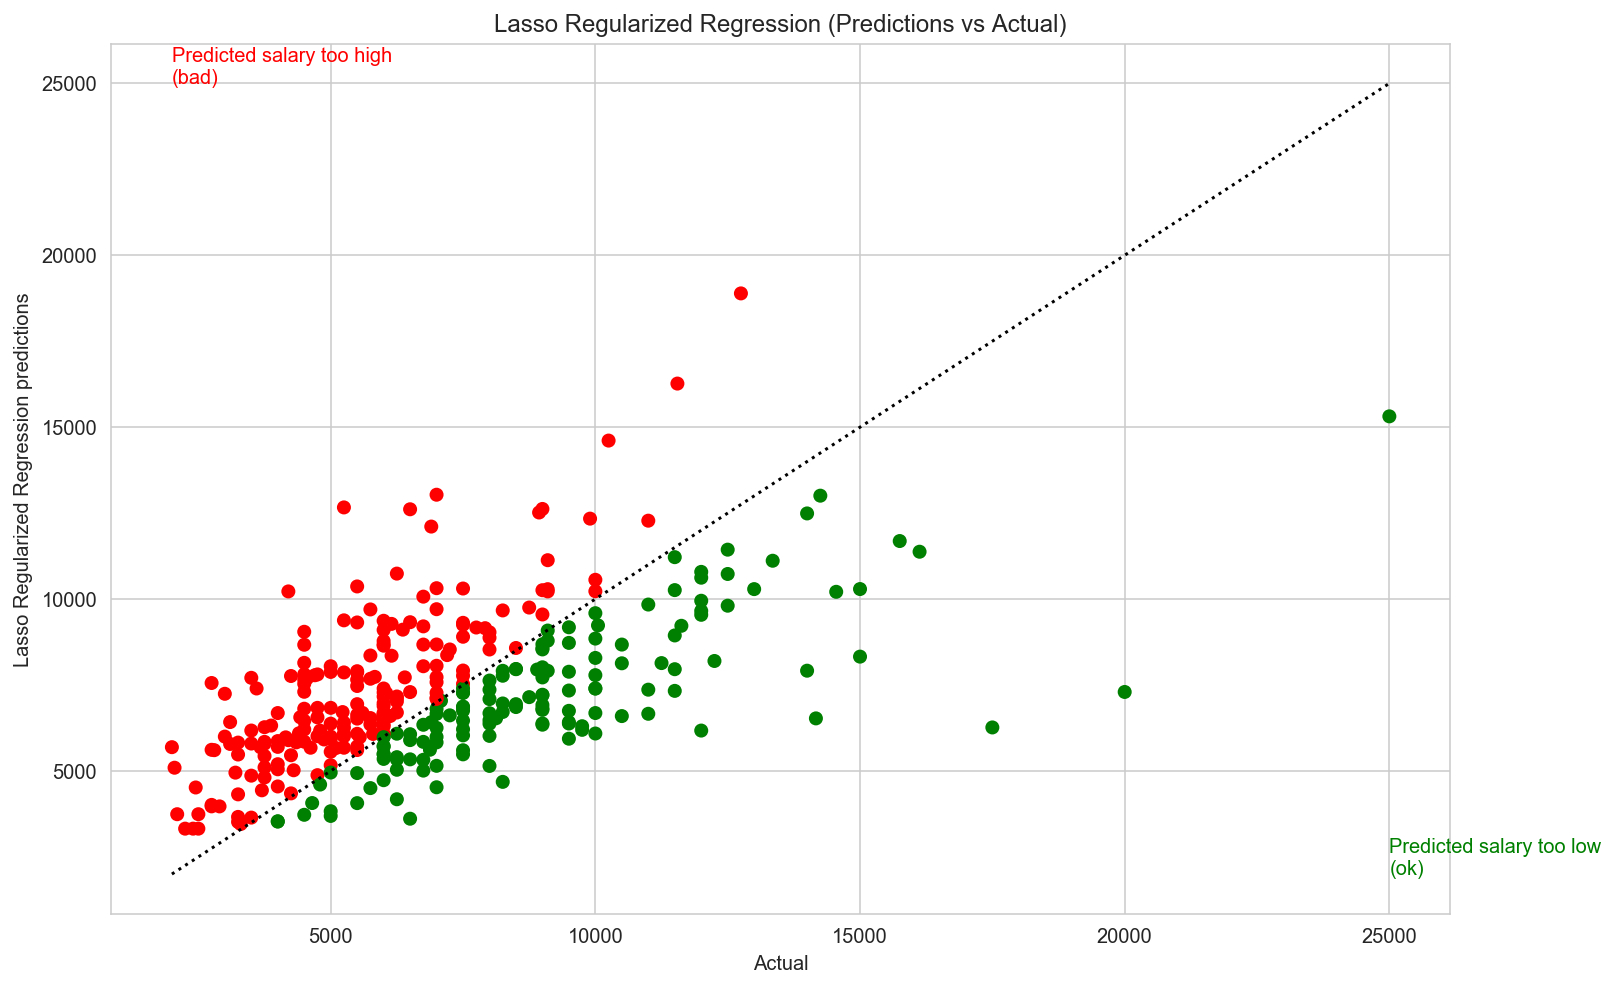

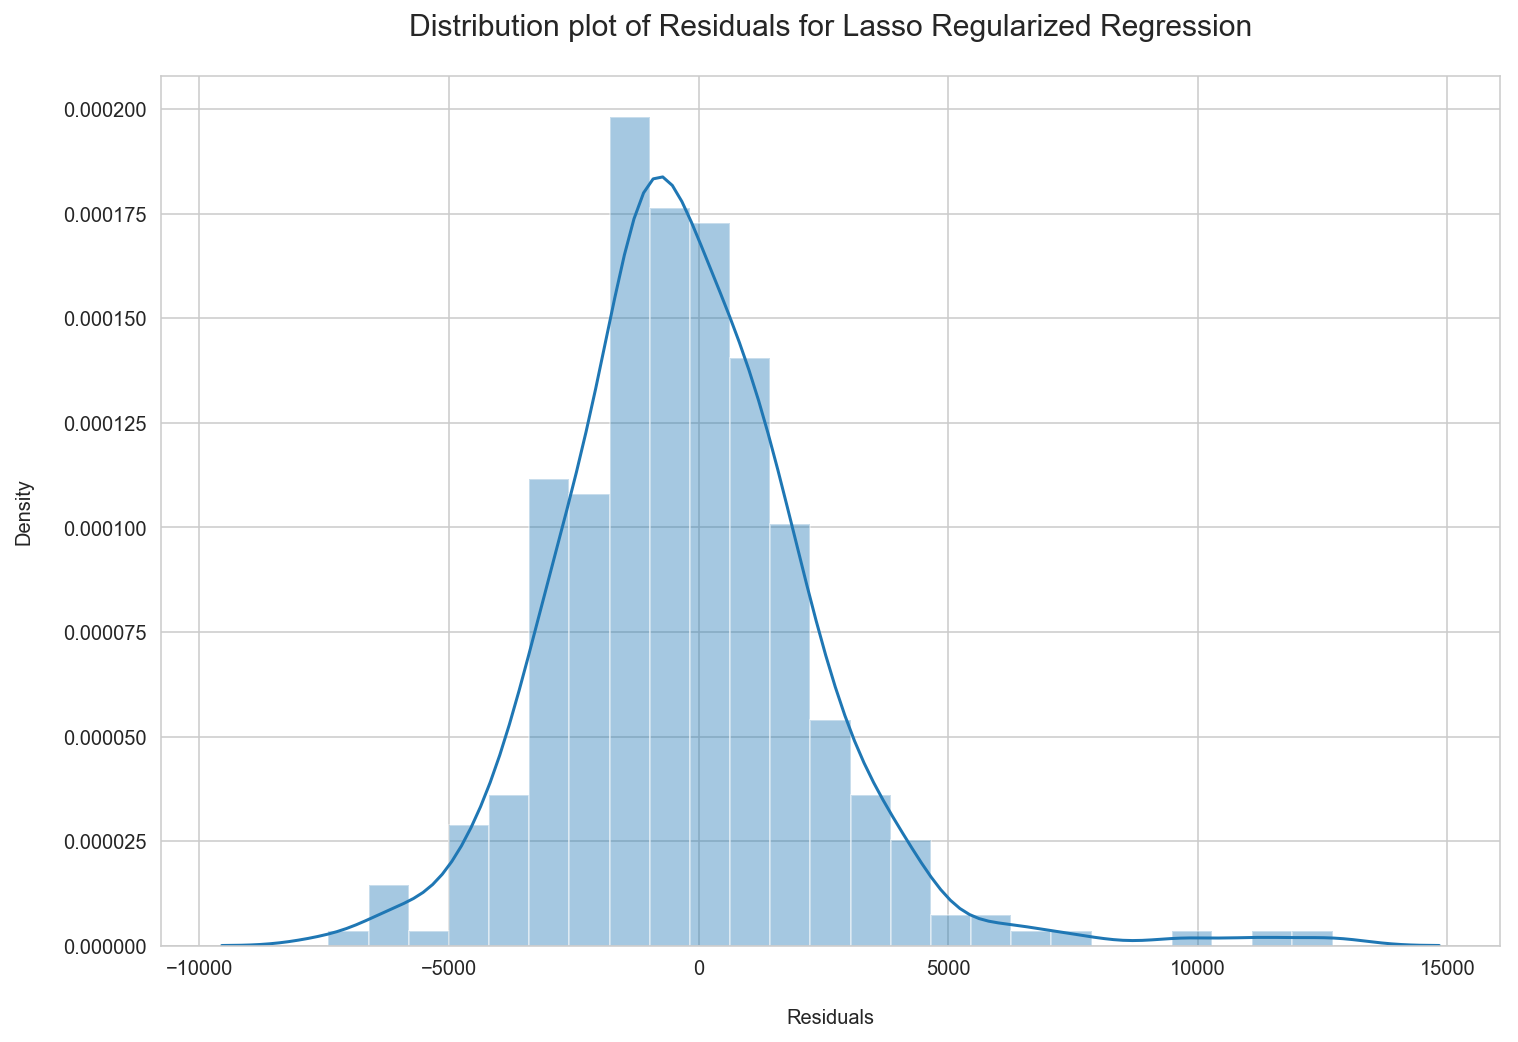

In [34]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, X_train, y_train, cv=5)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

lasso.fit(X_train, y_train)

print("Train score:", lasso.score(X_train, y_train))
print("Test score:", lasso.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lasso.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lasso.predict(X_test)))

show_predictions(lasso, 'Lasso Regularized Regression')
plot_residuals(lasso, 'Lasso Regularized Regression')